In [ ]:
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive



"Hyperparameter Analysis of the TransBiM Model on the First Dataset(Ds1)"


In [ ]:
dropout 0.1

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt

# تعریف دیتاست سفارشی
class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return torch.tensor(self.data[idx], dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.long)

# تابع برای بارگذاری داده‌ها به عنوان DataLoader
def load_data_as_dataloader(file_paths, labels, batch_size, percentage=1.0):
    data = []
    for file_path in file_paths:
        data.append(np.load(file_path))
    data = np.concatenate(data, axis=0)

    # استفاده از درصدی از داده‌ها
    num_samples = data.shape[0]
    subset_size = int(num_samples * percentage)
    data = data[:subset_size]
    labels = labels[:subset_size]

    dataset = CustomDataset(data, labels)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return dataloader

# مدل ترنسفورمر با لایه‌های BiLSTM در PyTorch
class TransformerWithBiLSTM(nn.Module):
    def __init__(self, input_dim, num_classes, num_heads=8, num_layers=2, lstm_hidden_dim=32, dropout_rate=0.1):
        super(TransformerWithBiLSTM, self).__init__()

        # لایه‌های BiLSTM
        self.bilstm = nn.LSTM(input_size=input_dim, hidden_size=lstm_hidden_dim,
                              num_layers=num_layers, batch_first=True, bidirectional=True, dropout=dropout_rate)

        self.attention_layers = nn.ModuleList([
            nn.MultiheadAttention(embed_dim=lstm_hidden_dim * 2, num_heads=num_heads) for _ in range(num_layers)
        ])

        self.layer_norm = nn.LayerNorm(lstm_hidden_dim * 2)
        self.fc1 = nn.Linear(lstm_hidden_dim * 2, 64)  # کاهش ابعاد لایه خطی
        self.dropout = nn.Dropout(dropout_rate)        # تغییر نرخ Dropout
        self.fc2 = nn.Linear(64, num_classes)          # سازگاری با ابعاد جدید

    def forward(self, x):
        # عبور از لایه BiLSTM
        lstm_out, _ = self.bilstm(x)

        # عبور از لایه‌های ترنسفورمر
        lstm_out = lstm_out.transpose(0, 1)  # برای سازگاری با PyTorch
        for attention in self.attention_layers:
            lstm_out, _ = attention(lstm_out, lstm_out, lstm_out)

        lstm_out = lstm_out.transpose(0, 1)  # بازگشت به شکل اولیه
        lstm_out = self.layer_norm(lstm_out)
        lstm_out = torch.mean(lstm_out, dim=1)  # GlobalAveragePooling
        lstm_out = torch.relu(self.fc1(lstm_out))
        lstm_out = self.dropout(lstm_out)       # اعمال Dropout
        lstm_out = self.fc2(lstm_out)           # عدم نیاز به Softmax چون CrossEntropyLoss آن را خودکار انجام می‌دهد
        return lstm_out

# تابع آموزش مدل
def train_transformer_model(train_loader, val_loader, input_dim, num_classes, model_save_path, plot_save_path, epochs=100, batch_size=32):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # ایجاد مدل و انتقال به GPU
    model = TransformerWithBiLSTM(input_dim=input_dim, num_classes=num_classes)
    model.to(device)

    optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=1e-4)  # استفاده از AdamW
    criterion = nn.CrossEntropyLoss()

    # تنظیم نرخ یادگیری
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)

    # لیست‌های ذخیره تاریخچه خطا و دقت
    train_loss_history = []
    val_loss_history = []

    best_val_accuracy = 0.0
    early_stopping_counter = 0  # شمارش برای Early Stopping
    patience = 10  # تعداد ایپوک‌ها برای توقف

    # آموزش مدل
    for epoch in range(epochs):
        model.train()
        total_train_loss = 0
        correct_train = 0
        total_train = 0

        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_train += batch_y.size(0)
            correct_train += (predicted == batch_y).sum().item()

        train_accuracy = 100 * correct_train / total_train

        # اعتبارسنجی مدل
        model.eval()
        total_val_loss = 0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for val_X, val_y in val_loader:
                val_X, val_y = val_X.to(device), val_y.to(device)
                outputs = model(val_X)
                loss = criterion(outputs, val_y)
                total_val_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total_val += val_y.size(0)
                correct_val += (predicted == val_y).sum().item()

        val_accuracy = 100 * correct_val / total_val

        train_loss_history.append(total_train_loss / len(train_loader))
        val_loss_history.append(total_val_loss / len(val_loader))

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {total_train_loss / len(train_loader):.4f}, Val Loss: {total_val_loss / len(val_loader):.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Accuracy: {val_accuracy:.2f}%")

        # ذخیره مدل اگر دقت اعتبارسنجی بهبود یافته باشد
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            torch.save(model.state_dict(), model_save_path)
            print(f"New best model saved with Val Accuracy: {val_accuracy:.2f}%")
            early_stopping_counter = 0  # بازنشانی شمارش
        else:
            early_stopping_counter += 1  # افزایش شمارش

        # بروزرسانی نرخ یادگیری
        scheduler.step(total_val_loss)  # به روز رسانی نرخ یادگیری با توجه به ولیدیشن Loss

        # اگر دقت ولیدیشن بهبود نیافت، آموزش متوقف شود
        if early_stopping_counter >= patience:
            print(f"Early stopping triggered after {epoch + 1} epochs.")
            break

    # ذخیره نمودارها
    plt.figure(figsize=(10, 5))
    plt.plot(train_loss_history, label='Train Loss')
    plt.plot(val_loss_history, label='Val Loss')
    plt.title('Model Performance')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(plot_save_path)
    plt.close()
    print(f"Plots saved to {plot_save_path}")

# فراخوانی تابع train_transformer_model

# مسیر فایل‌ها
save_paths_X = [
    '/content/drive/MyDrive/LM-RESULT2/resized_X_TRAIN_batch_1.npy',
    '/content/drive/MyDrive/LM-RESULT2/resized_X_TRAIN_batch_2.npy',
    '/content/drive/MyDrive/LM-RESULT2/resized_X_TRAIN_batch_3.npy',
    '/content/drive/MyDrive/LM-RESULT2/resized_X_TRAIN_batch_4.npy',
    '/content/drive/MyDrive/LM-RESULT2/resized_X_TRAIN_batch_5.npy',
    '/content/drive/MyDrive/LM-RESULT2/resized_X_TRAIN_batch_6.npy'
]
val_save_path_X = '/content/drive/MyDrive/LM-RESULT2/resized_X_val.npy'
val_label_csv_path = '/content/drive/MyDrive/LM-RESULT2/y_val_final.csv'

# بارگذاری برچسب‌ها
train_labels = np.loadtxt('/content/drive/MyDrive/LM-RESULT2/y_train_final.csv', delimiter=',', dtype=int)
val_labels = np.loadtxt(val_label_csv_path, delimiter=',', dtype=int)

# آماده‌سازی داده‌ها به عنوان DataLoader برای 100 درصد داده‌ها
train_loader = load_data_as_dataloader(save_paths_X, train_labels, batch_size=32, percentage=1.0)
val_loader = load_data_as_dataloader([val_save_path_X], val_labels, batch_size=32, percentage=1.0)

# تنظیمات مدل و آموزش با 100 ایپوک
input_dim = 1024  # ابعاد ورودی داده‌ها (باید با داده‌ها سازگار باشد)
num_classes = 2   # تعداد کلاس‌ها (برچسب‌ها)

train_transformer_model(
    train_loader,          # داده‌های آموزشی
    val_loader,            # داده‌های اعتبارسنجی
    input_dim=input_dim,   # ابعاد ورودی
    num_classes=num_classes,  # تعداد کلاس‌ها
    model_save_path='/content/drive/MyDrive/LM-RESULT2/best22_model.pth',  # مسیر ذخیره مدل
    plot_save_path='/content/drive/MyDrive/LM-RESULT2/training22_plot.png',  # مسیر ذخیره نمودار
    epochs=100,            # تعداد ایپوک‌ها
    batch_size=32          # اندازه بچ
)


Epoch 1/100, Train Loss: 0.5687, Val Loss: 0.4085, Train Accuracy: 68.92%, Val Accuracy: 83.43%
New best model saved with Val Accuracy: 83.43%
Epoch 2/100, Train Loss: 0.3704, Val Loss: 0.3578, Train Accuracy: 84.83%, Val Accuracy: 85.36%
New best model saved with Val Accuracy: 85.36%
Epoch 3/100, Train Loss: 0.3164, Val Loss: 0.3538, Train Accuracy: 87.76%, Val Accuracy: 85.43%
New best model saved with Val Accuracy: 85.43%
Epoch 4/100, Train Loss: 0.2845, Val Loss: 0.3196, Train Accuracy: 89.28%, Val Accuracy: 86.83%
New best model saved with Val Accuracy: 86.83%
Epoch 5/100, Train Loss: 0.2604, Val Loss: 0.3034, Train Accuracy: 89.98%, Val Accuracy: 87.96%
New best model saved with Val Accuracy: 87.96%
Epoch 6/100, Train Loss: 0.2413, Val Loss: 0.2859, Train Accuracy: 90.78%, Val Accuracy: 88.76%
New best model saved with Val Accuracy: 88.76%
Epoch 7/100, Train Loss: 0.2244, Val Loss: 0.2904, Train Accuracy: 91.60%, Val Accuracy: 88.96%
New best model saved with Val Accuracy: 88.96%

<ipython-input-3-302916163efc>:76: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_load_path, map_location=device))


Sensitivity:     89.10%
Specificity:     90.91%
Accuracy:        90.03%
F1 Score:        89.71%
MCC:             80.04%
auROC:           95.23%


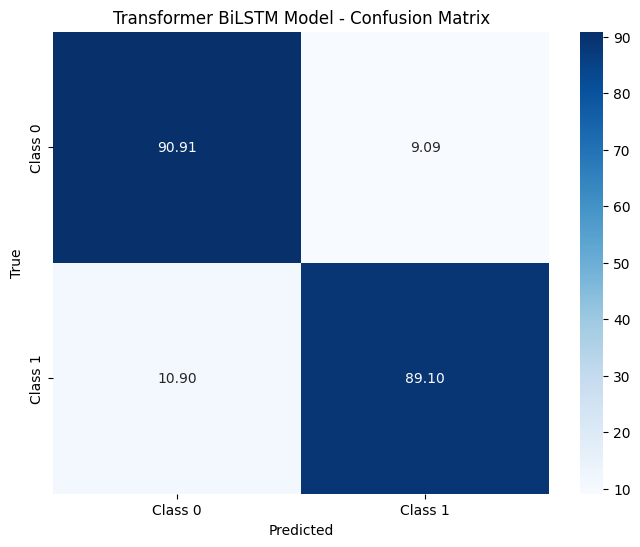

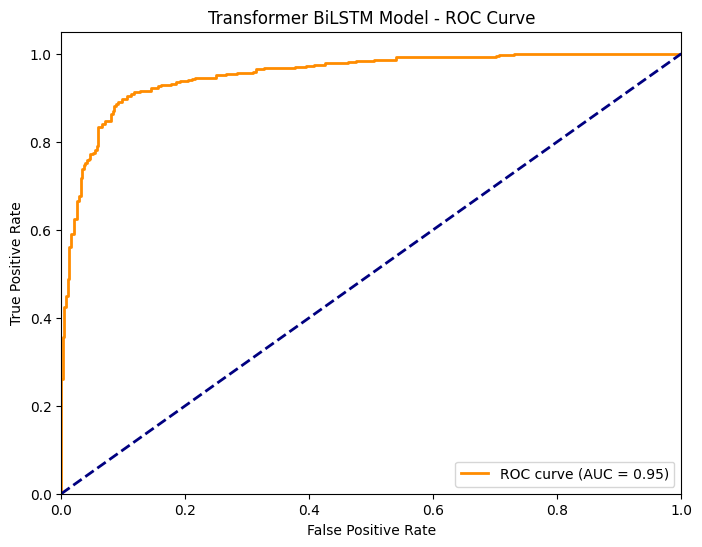

In [ ]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, roc_auc_score, matthews_corrcoef, roc_curve
import seaborn as sns
import matplotlib.pyplot as plt
import os

# تعریف دیتاست سفارشی برای تست
class CustomTestDataset(Dataset):
    def __init__(self, data, labels=None):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if self.labels is not None:
            return torch.tensor(self.data[idx], dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.long)
        else:
            return torch.tensor(self.data[idx], dtype=torch.float32)

# تابع برای بارگذاری داده‌های تست به عنوان DataLoader
def load_test_data_as_dataloader(file_paths, labels=None, batch_size=32):
    data = []
    for file_path in file_paths:
        data.append(np.load(file_path))
    data = np.concatenate(data, axis=0)
    dataset = CustomTestDataset(data, labels)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    return dataloader

# مدل ترنسفورمر با BiLSTM برای تست
class TransformerWithBiLSTM(nn.Module):
    def __init__(self, input_dim, num_classes, num_heads=8, num_layers=2, lstm_hidden_dim=32, dropout_rate=0.1):
        super(TransformerWithBiLSTM, self).__init__()

        # لایه‌های BiLSTM
        self.bilstm = nn.LSTM(input_size=input_dim, hidden_size=lstm_hidden_dim,
                              num_layers=num_layers, batch_first=True, bidirectional=True, dropout=dropout_rate)

        self.attention_layers = nn.ModuleList([nn.MultiheadAttention(embed_dim=lstm_hidden_dim * 2, num_heads=num_heads) for _ in range(num_layers)])

        self.layer_norm = nn.LayerNorm(lstm_hidden_dim * 2)
        self.fc1 = nn.Linear(lstm_hidden_dim * 2, 64)  # کاهش ابعاد لایه خطی
        self.dropout = nn.Dropout(dropout_rate)        # تغییر نرخ Dropout
        self.fc2 = nn.Linear(64, num_classes)          # سازگاری با ابعاد جدید

    def forward(self, x):
        # عبور از لایه BiLSTM
        lstm_out, _ = self.bilstm(x)

        # عبور از لایه‌های ترنسفورمر
        lstm_out = lstm_out.transpose(0, 1)  # برای سازگاری با PyTorch
        for attention in self.attention_layers:
            lstm_out, _ = attention(lstm_out, lstm_out, lstm_out)

        lstm_out = lstm_out.transpose(0, 1)  # بازگشت به شکل اولیه
        lstm_out = self.layer_norm(lstm_out)
        lstm_out = torch.mean(lstm_out, dim=1)  # GlobalAveragePooling
        lstm_out = torch.relu(self.fc1(lstm_out))
        lstm_out = self.dropout(lstm_out)       # اعمال Dropout
        lstm_out = torch.softmax(self.fc2(lstm_out), dim=-1)
        return lstm_out

# تابع تست مدل
def test_transformer_model(test_loader, model_load_path, input_dim=1024, num_classes=2):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = TransformerWithBiLSTM(input_dim=input_dim, num_classes=num_classes)
    model.to(device)

    # بارگذاری مدل ذخیره‌شده
    model.load_state_dict(torch.load(model_load_path, map_location=device))
    model.eval()

    all_predictions = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for data, labels in test_loader:
            data, labels = data.to(device), labels.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(outputs.cpu().numpy()[:, 1])  # احتمال برچسب مثبت

    all_probs = np.array(all_probs)
    return np.array(all_labels), np.array(all_predictions), all_probs

# محاسبه و نمایش معیارهای عملکرد
def calculate_metrics(y_true, y_pred_labels, y_pred_probs):
    cm = confusion_matrix(y_true, y_pred_labels)
    tn, fp, fn, tp = cm.ravel()
    sensitivity = tp / (tp + fn) * 100
    specificity = tn / (tn + fp) * 100
    accuracy = accuracy_score(y_true, y_pred_labels) * 100
    f1 = f1_score(y_true, y_pred_labels) * 100
    mcc = matthews_corrcoef(y_true, y_pred_labels) * 100
    auroc = roc_auc_score(y_true, y_pred_probs) * 100
    print(f"Sensitivity:     {sensitivity:.2f}%")
    print(f"Specificity:     {specificity:.2f}%")
    print(f"Accuracy:        {accuracy:.2f}%")
    print(f"F1 Score:        {f1:.2f}%")
    print(f"MCC:             {mcc:.2f}%")
    print(f"auROC:           {auroc:.2f}%")

# نمایش ماتریس کانفیوژن درصدی و ذخیره تصویر
def display_conf_matrix(y_true, y_pred_labels, title, filename):
    cm = confusion_matrix(y_true, y_pred_labels)
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_percent, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=['Class 0', 'Class 1'],
                yticklabels=['Class 0', 'Class 1'])
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig(filename)
    plt.show()

# رسم نمودار ROC
def plot_roc_curve(y_true, y_pred_probs, title, filename):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_score(y_true, y_pred_probs):.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.savefig(filename)
    plt.show()

# مسیر فایل‌های تست
test_save_paths_X = ['/content/drive/MyDrive/LM-RESULT2/resized_X_TEST.npy']
test_label_csv_path = '/content/drive/MyDrive/LM-RESULT2/y_test_final.csv'

# بارگذاری برچسب‌های تست
y_test = np.loadtxt(test_label_csv_path, delimiter=',', dtype=int)

# آماده‌سازی داده‌ها به عنوان DataLoader برای تست
test_loader = load_test_data_as_dataloader(test_save_paths_X, labels=y_test, batch_size=32)

# مسیر مدل ذخیره شده
model_load_path = '/content/drive/MyDrive/LM-RESULT2/best22_model.pth'

# تست مدل
y_true, y_pred_labels, predicted_probs = test_transformer_model(test_loader, model_load_path)

# محاسبه معیارها
calculate_metrics(y_true, y_pred_labels, predicted_probs)

# ایجاد دایرکتوری برای ذخیره تصاویر در صورت عدم وجود
output_dir = '/content/drive/MyDrive/my_project/LMPred_AMP_Prediction/Figuresfinal'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# نمایش و ذخیره ماتریس کانفیوژن
output_file_cm = os.path.join(output_dir, 'Transformer_BiLSTM3_Model_CM.png')
display_conf_matrix(y_true, y_pred_labels, 'Transformer BiLSTM Model - Confusion Matrix', output_file_cm)

# نمایش و ذخیره نمودار ROC
output_file_roc = os.path.join(output_dir, 'Transformer_BiLSTM3_Model_ROC.png')
plot_roc_curve(y_true, predicted_probs, 'Transformer BiLSTM Model - ROC Curve', output_file_roc)


In [ ]:
0.2 dropout

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt

# تعریف دیتاست سفارشی
class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return torch.tensor(self.data[idx], dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.long)

# تابع برای بارگذاری داده‌ها به عنوان DataLoader
def load_data_as_dataloader(file_paths, labels, batch_size, percentage=1.0):
    data = []
    for file_path in file_paths:
        data.append(np.load(file_path))
    data = np.concatenate(data, axis=0)

    # استفاده از درصدی از داده‌ها
    num_samples = data.shape[0]
    subset_size = int(num_samples * percentage)
    data = data[:subset_size]
    labels = labels[:subset_size]

    dataset = CustomDataset(data, labels)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return dataloader

# مدل ترنسفورمر با لایه‌های BiLSTM در PyTorch
class TransformerWithBiLSTM(nn.Module):
    def __init__(self, input_dim, num_classes, num_heads=8, num_layers=2, lstm_hidden_dim=32, dropout_rate=0.2):
        super(TransformerWithBiLSTM, self).__init__()

        # لایه‌های BiLSTM
        self.bilstm = nn.LSTM(input_size=input_dim, hidden_size=lstm_hidden_dim,
                              num_layers=num_layers, batch_first=True, bidirectional=True, dropout=dropout_rate)

        self.attention_layers = nn.ModuleList([
            nn.MultiheadAttention(embed_dim=lstm_hidden_dim * 2, num_heads=num_heads) for _ in range(num_layers)
        ])

        self.layer_norm = nn.LayerNorm(lstm_hidden_dim * 2)
        self.fc1 = nn.Linear(lstm_hidden_dim * 2, 64)  # کاهش ابعاد لایه خطی
        self.dropout = nn.Dropout(dropout_rate)        # تغییر نرخ Dropout
        self.fc2 = nn.Linear(64, num_classes)          # سازگاری با ابعاد جدید

    def forward(self, x):
        # عبور از لایه BiLSTM
        lstm_out, _ = self.bilstm(x)

        # عبور از لایه‌های ترنسفورمر
        lstm_out = lstm_out.transpose(0, 1)  # برای سازگاری با PyTorch
        for attention in self.attention_layers:
            lstm_out, _ = attention(lstm_out, lstm_out, lstm_out)

        lstm_out = lstm_out.transpose(0, 1)  # بازگشت به شکل اولیه
        lstm_out = self.layer_norm(lstm_out)
        lstm_out = torch.mean(lstm_out, dim=1)  # GlobalAveragePooling
        lstm_out = torch.relu(self.fc1(lstm_out))
        lstm_out = self.dropout(lstm_out)       # اعمال Dropout
        lstm_out = self.fc2(lstm_out)           # عدم نیاز به Softmax چون CrossEntropyLoss آن را خودکار انجام می‌دهد
        return lstm_out

# تابع آموزش مدل
def train_transformer_model(train_loader, val_loader, input_dim, num_classes, model_save_path, plot_save_path, epochs=100, batch_size=32):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # ایجاد مدل و انتقال به GPU
    model = TransformerWithBiLSTM(input_dim=input_dim, num_classes=num_classes)
    model.to(device)

    optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=1e-4)  # استفاده از AdamW
    criterion = nn.CrossEntropyLoss()

    # تنظیم نرخ یادگیری
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)

    # لیست‌های ذخیره تاریخچه خطا و دقت
    train_loss_history = []
    val_loss_history = []

    best_val_accuracy = 0.0
    early_stopping_counter = 0  # شمارش برای Early Stopping
    patience = 10  # تعداد ایپوک‌ها برای توقف

    # آموزش مدل
    for epoch in range(epochs):
        model.train()
        total_train_loss = 0
        correct_train = 0
        total_train = 0

        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_train += batch_y.size(0)
            correct_train += (predicted == batch_y).sum().item()

        train_accuracy = 100 * correct_train / total_train

        # اعتبارسنجی مدل
        model.eval()
        total_val_loss = 0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for val_X, val_y in val_loader:
                val_X, val_y = val_X.to(device), val_y.to(device)
                outputs = model(val_X)
                loss = criterion(outputs, val_y)
                total_val_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total_val += val_y.size(0)
                correct_val += (predicted == val_y).sum().item()

        val_accuracy = 100 * correct_val / total_val

        train_loss_history.append(total_train_loss / len(train_loader))
        val_loss_history.append(total_val_loss / len(val_loader))

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {total_train_loss / len(train_loader):.4f}, Val Loss: {total_val_loss / len(val_loader):.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Accuracy: {val_accuracy:.2f}%")

        # ذخیره مدل اگر دقت اعتبارسنجی بهبود یافته باشد
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            torch.save(model.state_dict(), model_save_path)
            print(f"New best model saved with Val Accuracy: {val_accuracy:.2f}%")
            early_stopping_counter = 0  # بازنشانی شمارش
        else:
            early_stopping_counter += 1  # افزایش شمارش

        # بروزرسانی نرخ یادگیری
        scheduler.step(total_val_loss)  # به روز رسانی نرخ یادگیری با توجه به ولیدیشن Loss

        # اگر دقت ولیدیشن بهبود نیافت، آموزش متوقف شود
        if early_stopping_counter >= patience:
            print(f"Early stopping triggered after {epoch + 1} epochs.")
            break

    # ذخیره نمودارها
    plt.figure(figsize=(10, 5))
    plt.plot(train_loss_history, label='Train Loss')
    plt.plot(val_loss_history, label='Val Loss')
    plt.title('Model Performance')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(plot_save_path)
    plt.close()
    print(f"Plots saved to {plot_save_path}")

# فراخوانی تابع train_transformer_model

# مسیر فایل‌ها
save_paths_X = [
    '/content/drive/MyDrive/LM-RESULT2/resized_X_TRAIN_batch_1.npy',
    '/content/drive/MyDrive/LM-RESULT2/resized_X_TRAIN_batch_2.npy',
    '/content/drive/MyDrive/LM-RESULT2/resized_X_TRAIN_batch_3.npy',
    '/content/drive/MyDrive/LM-RESULT2/resized_X_TRAIN_batch_4.npy',
    '/content/drive/MyDrive/LM-RESULT2/resized_X_TRAIN_batch_5.npy',
    '/content/drive/MyDrive/LM-RESULT2/resized_X_TRAIN_batch_6.npy'
]
val_save_path_X = '/content/drive/MyDrive/LM-RESULT2/resized_X_val.npy'
val_label_csv_path = '/content/drive/MyDrive/LM-RESULT2/y_val_final.csv'

# بارگذاری برچسب‌ها
train_labels = np.loadtxt('/content/drive/MyDrive/LM-RESULT2/y_train_final.csv', delimiter=',', dtype=int)
val_labels = np.loadtxt(val_label_csv_path, delimiter=',', dtype=int)

# آماده‌سازی داده‌ها به عنوان DataLoader برای 100 درصد داده‌ها
train_loader = load_data_as_dataloader(save_paths_X, train_labels, batch_size=32, percentage=1.0)
val_loader = load_data_as_dataloader([val_save_path_X], val_labels, batch_size=32, percentage=1.0)

# تنظیمات مدل و آموزش با 100 ایپوک
input_dim = 1024  # ابعاد ورودی داده‌ها (باید با داده‌ها سازگار باشد)
num_classes = 2   # تعداد کلاس‌ها (برچسب‌ها)

train_transformer_model(
    train_loader,          # داده‌های آموزشی
    val_loader,            # داده‌های اعتبارسنجی
    input_dim=input_dim,   # ابعاد ورودی
    num_classes=num_classes,  # تعداد کلاس‌ها
    model_save_path='/content/drive/MyDrive/LM-RESULT2/best23_model.pth',  # مسیر ذخیره مدل
    plot_save_path='/content/drive/MyDrive/LM-RESULT2/training23_plot.png',  # مسیر ذخیره نمودار
    epochs=100,            # تعداد ایپوک‌ها
    batch_size=32          # اندازه بچ
)


Epoch 1/100, Train Loss: 0.5638, Val Loss: 0.4407, Train Accuracy: 69.64%, Val Accuracy: 80.17%
New best model saved with Val Accuracy: 80.17%
Epoch 2/100, Train Loss: 0.3629, Val Loss: 0.3887, Train Accuracy: 85.46%, Val Accuracy: 83.23%
New best model saved with Val Accuracy: 83.23%
Epoch 3/100, Train Loss: 0.3142, Val Loss: 0.3271, Train Accuracy: 88.16%, Val Accuracy: 86.63%
New best model saved with Val Accuracy: 86.63%
Epoch 4/100, Train Loss: 0.2803, Val Loss: 0.3058, Train Accuracy: 89.30%, Val Accuracy: 88.69%
New best model saved with Val Accuracy: 88.69%
Epoch 5/100, Train Loss: 0.2607, Val Loss: 0.3191, Train Accuracy: 90.78%, Val Accuracy: 87.89%
Epoch 6/100, Train Loss: 0.2512, Val Loss: 0.2921, Train Accuracy: 90.72%, Val Accuracy: 88.96%
New best model saved with Val Accuracy: 88.96%
Epoch 7/100, Train Loss: 0.2348, Val Loss: 0.2878, Train Accuracy: 91.86%, Val Accuracy: 89.02%
New best model saved with Val Accuracy: 89.02%
Epoch 8/100, Train Loss: 0.2247, Val Loss: 0.2

<ipython-input-3-287f93dd5ceb>:76: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_load_path, map_location=device))


Sensitivity:     90.19%
Specificity:     90.65%
Accuracy:        90.43%
F1 Score:        90.19%
MCC:             80.84%
auROC:           95.57%


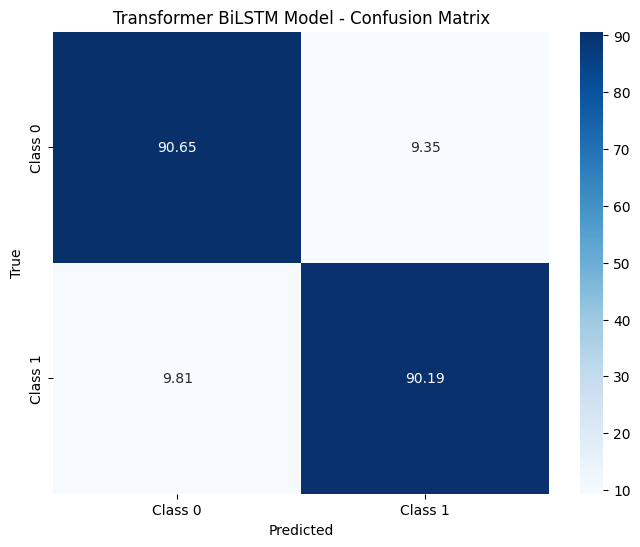

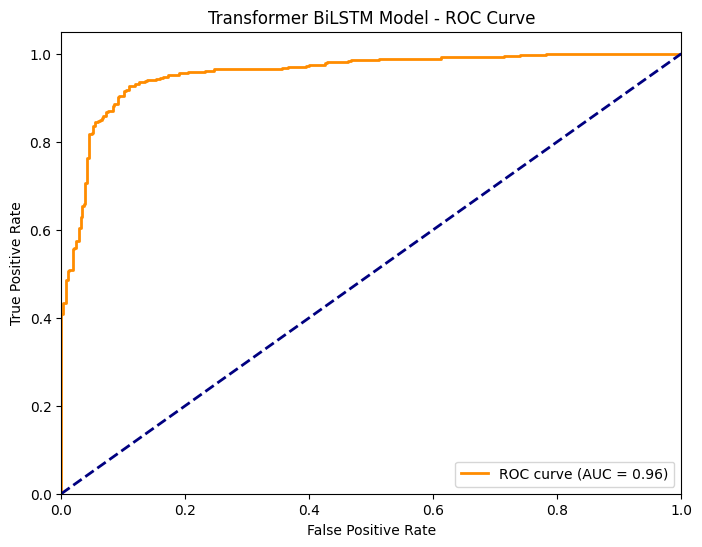

In [ ]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, roc_auc_score, matthews_corrcoef, roc_curve
import seaborn as sns
import matplotlib.pyplot as plt
import os

# تعریف دیتاست سفارشی برای تست
class CustomTestDataset(Dataset):
    def __init__(self, data, labels=None):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if self.labels is not None:
            return torch.tensor(self.data[idx], dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.long)
        else:
            return torch.tensor(self.data[idx], dtype=torch.float32)

# تابع برای بارگذاری داده‌های تست به عنوان DataLoader
def load_test_data_as_dataloader(file_paths, labels=None, batch_size=32):
    data = []
    for file_path in file_paths:
        data.append(np.load(file_path))
    data = np.concatenate(data, axis=0)
    dataset = CustomTestDataset(data, labels)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    return dataloader

# مدل ترنسفورمر با BiLSTM برای تست
class TransformerWithBiLSTM(nn.Module):
    def __init__(self, input_dim, num_classes, num_heads=8, num_layers=2, lstm_hidden_dim=32, dropout_rate=0.2):
        super(TransformerWithBiLSTM, self).__init__()

        # لایه‌های BiLSTM
        self.bilstm = nn.LSTM(input_size=input_dim, hidden_size=lstm_hidden_dim,
                              num_layers=num_layers, batch_first=True, bidirectional=True, dropout=dropout_rate)

        self.attention_layers = nn.ModuleList([nn.MultiheadAttention(embed_dim=lstm_hidden_dim * 2, num_heads=num_heads) for _ in range(num_layers)])

        self.layer_norm = nn.LayerNorm(lstm_hidden_dim * 2)
        self.fc1 = nn.Linear(lstm_hidden_dim * 2, 64)  # کاهش ابعاد لایه خطی
        self.dropout = nn.Dropout(dropout_rate)        # تغییر نرخ Dropout
        self.fc2 = nn.Linear(64, num_classes)          # سازگاری با ابعاد جدید

    def forward(self, x):
        # عبور از لایه BiLSTM
        lstm_out, _ = self.bilstm(x)

        # عبور از لایه‌های ترنسفورمر
        lstm_out = lstm_out.transpose(0, 1)  # برای سازگاری با PyTorch
        for attention in self.attention_layers:
            lstm_out, _ = attention(lstm_out, lstm_out, lstm_out)

        lstm_out = lstm_out.transpose(0, 1)  # بازگشت به شکل اولیه
        lstm_out = self.layer_norm(lstm_out)
        lstm_out = torch.mean(lstm_out, dim=1)  # GlobalAveragePooling
        lstm_out = torch.relu(self.fc1(lstm_out))
        lstm_out = self.dropout(lstm_out)       # اعمال Dropout
        lstm_out = torch.softmax(self.fc2(lstm_out), dim=-1)
        return lstm_out

# تابع تست مدل
def test_transformer_model(test_loader, model_load_path, input_dim=1024, num_classes=2):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = TransformerWithBiLSTM(input_dim=input_dim, num_classes=num_classes)
    model.to(device)

    # بارگذاری مدل ذخیره‌شده
    model.load_state_dict(torch.load(model_load_path, map_location=device))
    model.eval()

    all_predictions = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for data, labels in test_loader:
            data, labels = data.to(device), labels.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(outputs.cpu().numpy()[:, 1])  # احتمال برچسب مثبت

    all_probs = np.array(all_probs)
    return np.array(all_labels), np.array(all_predictions), all_probs

# محاسبه و نمایش معیارهای عملکرد
def calculate_metrics(y_true, y_pred_labels, y_pred_probs):
    cm = confusion_matrix(y_true, y_pred_labels)
    tn, fp, fn, tp = cm.ravel()
    sensitivity = tp / (tp + fn) * 100
    specificity = tn / (tn + fp) * 100
    accuracy = accuracy_score(y_true, y_pred_labels) * 100
    f1 = f1_score(y_true, y_pred_labels) * 100
    mcc = matthews_corrcoef(y_true, y_pred_labels) * 100
    auroc = roc_auc_score(y_true, y_pred_probs) * 100
    print(f"Sensitivity:     {sensitivity:.2f}%")
    print(f"Specificity:     {specificity:.2f}%")
    print(f"Accuracy:        {accuracy:.2f}%")
    print(f"F1 Score:        {f1:.2f}%")
    print(f"MCC:             {mcc:.2f}%")
    print(f"auROC:           {auroc:.2f}%")

# نمایش ماتریس کانفیوژن درصدی و ذخیره تصویر
def display_conf_matrix(y_true, y_pred_labels, title, filename):
    cm = confusion_matrix(y_true, y_pred_labels)
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_percent, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=['Class 0', 'Class 1'],
                yticklabels=['Class 0', 'Class 1'])
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig(filename)
    plt.show()

# رسم نمودار ROC
def plot_roc_curve(y_true, y_pred_probs, title, filename):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_score(y_true, y_pred_probs):.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.savefig(filename)
    plt.show()

# مسیر فایل‌های تست
test_save_paths_X = ['/content/drive/MyDrive/LM-RESULT2/resized_X_TEST.npy']
test_label_csv_path = '/content/drive/MyDrive/LM-RESULT2/y_test_final.csv'

# بارگذاری برچسب‌های تست
y_test = np.loadtxt(test_label_csv_path, delimiter=',', dtype=int)

# آماده‌سازی داده‌ها به عنوان DataLoader برای تست
test_loader = load_test_data_as_dataloader(test_save_paths_X, labels=y_test, batch_size=32)

# مسیر مدل ذخیره شده
model_load_path = '/content/drive/MyDrive/LM-RESULT2/best23_model.pth'

# تست مدل
y_true, y_pred_labels, predicted_probs = test_transformer_model(test_loader, model_load_path)

# محاسبه معیارها
calculate_metrics(y_true, y_pred_labels, predicted_probs)

# ایجاد دایرکتوری برای ذخیره تصاویر در صورت عدم وجود
output_dir = '/content/drive/MyDrive/my_project/LMPred_AMP_Prediction/Figuresfinal'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# نمایش و ذخیره ماتریس کانفیوژن
output_file_cm = os.path.join(output_dir, 'Transformer_BiLSTM3_Model_CM.png')
display_conf_matrix(y_true, y_pred_labels, 'Transformer BiLSTM Model - Confusion Matrix', output_file_cm)

# نمایش و ذخیره نمودار ROC
output_file_roc = os.path.join(output_dir, 'Transformer_BiLSTM3_Model_ROC.png')
plot_roc_curve(y_true, predicted_probs, 'Transformer BiLSTM Model - ROC Curve', output_file_roc)


In [ ]:
0.4 dropout

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt

# تعریف دیتاست سفارشی
class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return torch.tensor(self.data[idx], dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.long)

# تابع برای بارگذاری داده‌ها به عنوان DataLoader
def load_data_as_dataloader(file_paths, labels, batch_size, percentage=1.0):
    data = []
    for file_path in file_paths:
        data.append(np.load(file_path))
    data = np.concatenate(data, axis=0)

    # استفاده از درصدی از داده‌ها
    num_samples = data.shape[0]
    subset_size = int(num_samples * percentage)
    data = data[:subset_size]
    labels = labels[:subset_size]

    dataset = CustomDataset(data, labels)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return dataloader

# مدل ترنسفورمر با لایه‌های BiLSTM در PyTorch
class TransformerWithBiLSTM(nn.Module):
    def __init__(self, input_dim, num_classes, num_heads=8, num_layers=2, lstm_hidden_dim=32, dropout_rate=0.4):
        super(TransformerWithBiLSTM, self).__init__()

        # لایه‌های BiLSTM
        self.bilstm = nn.LSTM(input_size=input_dim, hidden_size=lstm_hidden_dim,
                              num_layers=num_layers, batch_first=True, bidirectional=True, dropout=dropout_rate)

        self.attention_layers = nn.ModuleList([
            nn.MultiheadAttention(embed_dim=lstm_hidden_dim * 2, num_heads=num_heads) for _ in range(num_layers)
        ])

        self.layer_norm = nn.LayerNorm(lstm_hidden_dim * 2)
        self.fc1 = nn.Linear(lstm_hidden_dim * 2, 64)  # کاهش ابعاد لایه خطی
        self.dropout = nn.Dropout(dropout_rate)        # تغییر نرخ Dropout
        self.fc2 = nn.Linear(64, num_classes)          # سازگاری با ابعاد جدید

    def forward(self, x):
        # عبور از لایه BiLSTM
        lstm_out, _ = self.bilstm(x)

        # عبور از لایه‌های ترنسفورمر
        lstm_out = lstm_out.transpose(0, 1)  # برای سازگاری با PyTorch
        for attention in self.attention_layers:
            lstm_out, _ = attention(lstm_out, lstm_out, lstm_out)

        lstm_out = lstm_out.transpose(0, 1)  # بازگشت به شکل اولیه
        lstm_out = self.layer_norm(lstm_out)
        lstm_out = torch.mean(lstm_out, dim=1)  # GlobalAveragePooling
        lstm_out = torch.relu(self.fc1(lstm_out))
        lstm_out = self.dropout(lstm_out)       # اعمال Dropout
        lstm_out = self.fc2(lstm_out)           # عدم نیاز به Softmax چون CrossEntropyLoss آن را خودکار انجام می‌دهد
        return lstm_out

# تابع آموزش مدل
def train_transformer_model(train_loader, val_loader, input_dim, num_classes, model_save_path, plot_save_path, epochs=100, batch_size=32):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # ایجاد مدل و انتقال به GPU
    model = TransformerWithBiLSTM(input_dim=input_dim, num_classes=num_classes)
    model.to(device)

    optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=1e-4)  # استفاده از AdamW
    criterion = nn.CrossEntropyLoss()

    # تنظیم نرخ یادگیری
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)

    # لیست‌های ذخیره تاریخچه خطا و دقت
    train_loss_history = []
    val_loss_history = []

    best_val_accuracy = 0.0
    early_stopping_counter = 0  # شمارش برای Early Stopping
    patience = 10  # تعداد ایپوک‌ها برای توقف

    # آموزش مدل
    for epoch in range(epochs):
        model.train()
        total_train_loss = 0
        correct_train = 0
        total_train = 0

        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_train += batch_y.size(0)
            correct_train += (predicted == batch_y).sum().item()

        train_accuracy = 100 * correct_train / total_train

        # اعتبارسنجی مدل
        model.eval()
        total_val_loss = 0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for val_X, val_y in val_loader:
                val_X, val_y = val_X.to(device), val_y.to(device)
                outputs = model(val_X)
                loss = criterion(outputs, val_y)
                total_val_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total_val += val_y.size(0)
                correct_val += (predicted == val_y).sum().item()

        val_accuracy = 100 * correct_val / total_val

        train_loss_history.append(total_train_loss / len(train_loader))
        val_loss_history.append(total_val_loss / len(val_loader))

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {total_train_loss / len(train_loader):.4f}, Val Loss: {total_val_loss / len(val_loader):.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Accuracy: {val_accuracy:.2f}%")

        # ذخیره مدل اگر دقت اعتبارسنجی بهبود یافته باشد
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            torch.save(model.state_dict(), model_save_path)
            print(f"New best model saved with Val Accuracy: {val_accuracy:.2f}%")
            early_stopping_counter = 0  # بازنشانی شمارش
        else:
            early_stopping_counter += 1  # افزایش شمارش

        # بروزرسانی نرخ یادگیری
        scheduler.step(total_val_loss)  # به روز رسانی نرخ یادگیری با توجه به ولیدیشن Loss

        # اگر دقت ولیدیشن بهبود نیافت، آموزش متوقف شود
        if early_stopping_counter >= patience:
            print(f"Early stopping triggered after {epoch + 1} epochs.")
            break

    # ذخیره نمودارها
    plt.figure(figsize=(10, 5))
    plt.plot(train_loss_history, label='Train Loss')
    plt.plot(val_loss_history, label='Val Loss')
    plt.title('Model Performance')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(plot_save_path)
    plt.close()
    print(f"Plots saved to {plot_save_path}")

# فراخوانی تابع train_transformer_model

# مسیر فایل‌ها
save_paths_X = [
    '/content/drive/MyDrive/LM-RESULT2/resized_X_TRAIN_batch_1.npy',
    '/content/drive/MyDrive/LM-RESULT2/resized_X_TRAIN_batch_2.npy',
    '/content/drive/MyDrive/LM-RESULT2/resized_X_TRAIN_batch_3.npy',
    '/content/drive/MyDrive/LM-RESULT2/resized_X_TRAIN_batch_4.npy',
    '/content/drive/MyDrive/LM-RESULT2/resized_X_TRAIN_batch_5.npy',
    '/content/drive/MyDrive/LM-RESULT2/resized_X_TRAIN_batch_6.npy'
]
val_save_path_X = '/content/drive/MyDrive/LM-RESULT2/resized_X_val.npy'
val_label_csv_path = '/content/drive/MyDrive/LM-RESULT2/y_val_final.csv'

# بارگذاری برچسب‌ها
train_labels = np.loadtxt('/content/drive/MyDrive/LM-RESULT2/y_train_final.csv', delimiter=',', dtype=int)
val_labels = np.loadtxt(val_label_csv_path, delimiter=',', dtype=int)

# آماده‌سازی داده‌ها به عنوان DataLoader برای 100 درصد داده‌ها
train_loader = load_data_as_dataloader(save_paths_X, train_labels, batch_size=32, percentage=1.0)
val_loader = load_data_as_dataloader([val_save_path_X], val_labels, batch_size=32, percentage=1.0)

# تنظیمات مدل و آموزش با 100 ایپوک
input_dim = 1024  # ابعاد ورودی داده‌ها (باید با داده‌ها سازگار باشد)
num_classes = 2   # تعداد کلاس‌ها (برچسب‌ها)

train_transformer_model(
    train_loader,          # داده‌های آموزشی
    val_loader,            # داده‌های اعتبارسنجی
    input_dim=input_dim,   # ابعاد ورودی
    num_classes=num_classes,  # تعداد کلاس‌ها
    model_save_path='/content/drive/MyDrive/LM-RESULT2/best24_model.pth',  # مسیر ذخیره مدل
    plot_save_path='/content/drive/MyDrive/LM-RESULT2/training24_plot.png',  # مسیر ذخیره نمودار
    epochs=100,            # تعداد ایپوک‌ها
    batch_size=32          # اندازه بچ
)


Epoch 1/100, Train Loss: 0.6246, Val Loss: 0.4338, Train Accuracy: 63.26%, Val Accuracy: 81.90%
New best model saved with Val Accuracy: 81.90%
Epoch 2/100, Train Loss: 0.3853, Val Loss: 0.4250, Train Accuracy: 84.57%, Val Accuracy: 81.17%
Epoch 3/100, Train Loss: 0.3336, Val Loss: 0.3364, Train Accuracy: 87.47%, Val Accuracy: 86.56%
New best model saved with Val Accuracy: 86.56%
Epoch 4/100, Train Loss: 0.3002, Val Loss: 0.3870, Train Accuracy: 88.98%, Val Accuracy: 83.90%
Epoch 5/100, Train Loss: 0.2784, Val Loss: 0.3034, Train Accuracy: 89.91%, Val Accuracy: 88.02%
New best model saved with Val Accuracy: 88.02%
Epoch 6/100, Train Loss: 0.2542, Val Loss: 0.2850, Train Accuracy: 91.16%, Val Accuracy: 89.02%
New best model saved with Val Accuracy: 89.02%
Epoch 7/100, Train Loss: 0.2481, Val Loss: 0.2797, Train Accuracy: 91.01%, Val Accuracy: 90.02%
New best model saved with Val Accuracy: 90.02%
Epoch 8/100, Train Loss: 0.2356, Val Loss: 0.2858, Train Accuracy: 91.85%, Val Accuracy: 89.4

<ipython-input-2-6590562bc498>:76: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_load_path, map_location=device))


Sensitivity:     87.74%
Specificity:     91.17%
Accuracy:        89.49%
F1 Score:        89.07%
MCC:             79.00%
auROC:           94.44%


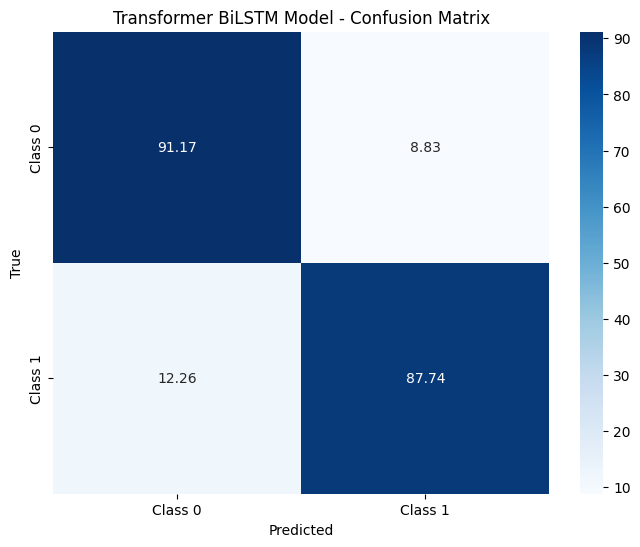

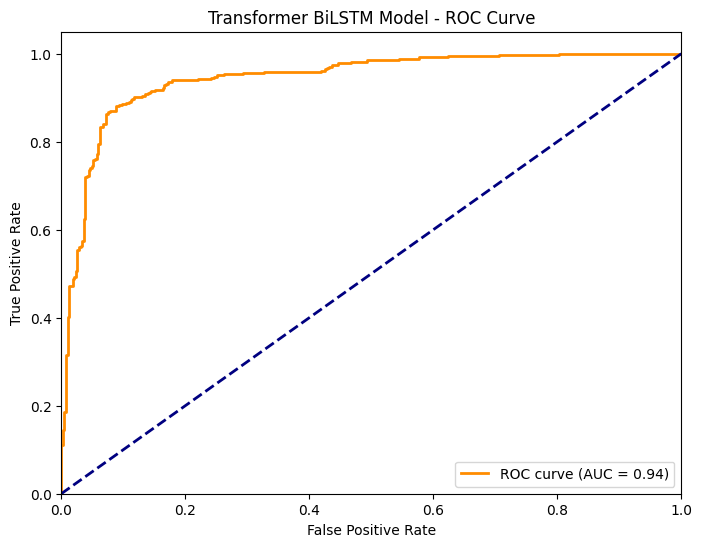

In [ ]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, roc_auc_score, matthews_corrcoef, roc_curve
import seaborn as sns
import matplotlib.pyplot as plt
import os

# تعریف دیتاست سفارشی برای تست
class CustomTestDataset(Dataset):
    def __init__(self, data, labels=None):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if self.labels is not None:
            return torch.tensor(self.data[idx], dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.long)
        else:
            return torch.tensor(self.data[idx], dtype=torch.float32)

# تابع برای بارگذاری داده‌های تست به عنوان DataLoader
def load_test_data_as_dataloader(file_paths, labels=None, batch_size=32):
    data = []
    for file_path in file_paths:
        data.append(np.load(file_path))
    data = np.concatenate(data, axis=0)
    dataset = CustomTestDataset(data, labels)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    return dataloader

# مدل ترنسفورمر با BiLSTM برای تست
class TransformerWithBiLSTM(nn.Module):
    def __init__(self, input_dim, num_classes, num_heads=8, num_layers=2, lstm_hidden_dim=32, dropout_rate=0.4):
        super(TransformerWithBiLSTM, self).__init__()

        # لایه‌های BiLSTM
        self.bilstm = nn.LSTM(input_size=input_dim, hidden_size=lstm_hidden_dim,
                              num_layers=num_layers, batch_first=True, bidirectional=True, dropout=dropout_rate)

        self.attention_layers = nn.ModuleList([nn.MultiheadAttention(embed_dim=lstm_hidden_dim * 2, num_heads=num_heads) for _ in range(num_layers)])

        self.layer_norm = nn.LayerNorm(lstm_hidden_dim * 2)
        self.fc1 = nn.Linear(lstm_hidden_dim * 2, 64)  # کاهش ابعاد لایه خطی
        self.dropout = nn.Dropout(dropout_rate)        # تغییر نرخ Dropout
        self.fc2 = nn.Linear(64, num_classes)          # سازگاری با ابعاد جدید

    def forward(self, x):
        # عبور از لایه BiLSTM
        lstm_out, _ = self.bilstm(x)

        # عبور از لایه‌های ترنسفورمر
        lstm_out = lstm_out.transpose(0, 1)  # برای سازگاری با PyTorch
        for attention in self.attention_layers:
            lstm_out, _ = attention(lstm_out, lstm_out, lstm_out)

        lstm_out = lstm_out.transpose(0, 1)  # بازگشت به شکل اولیه
        lstm_out = self.layer_norm(lstm_out)
        lstm_out = torch.mean(lstm_out, dim=1)  # GlobalAveragePooling
        lstm_out = torch.relu(self.fc1(lstm_out))
        lstm_out = self.dropout(lstm_out)       # اعمال Dropout
        lstm_out = torch.softmax(self.fc2(lstm_out), dim=-1)
        return lstm_out

# تابع تست مدل
def test_transformer_model(test_loader, model_load_path, input_dim=1024, num_classes=2):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = TransformerWithBiLSTM(input_dim=input_dim, num_classes=num_classes)
    model.to(device)

    # بارگذاری مدل ذخیره‌شده
    model.load_state_dict(torch.load(model_load_path, map_location=device))
    model.eval()

    all_predictions = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for data, labels in test_loader:
            data, labels = data.to(device), labels.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(outputs.cpu().numpy()[:, 1])  # احتمال برچسب مثبت

    all_probs = np.array(all_probs)
    return np.array(all_labels), np.array(all_predictions), all_probs

# محاسبه و نمایش معیارهای عملکرد
def calculate_metrics(y_true, y_pred_labels, y_pred_probs):
    cm = confusion_matrix(y_true, y_pred_labels)
    tn, fp, fn, tp = cm.ravel()
    sensitivity = tp / (tp + fn) * 100
    specificity = tn / (tn + fp) * 100
    accuracy = accuracy_score(y_true, y_pred_labels) * 100
    f1 = f1_score(y_true, y_pred_labels) * 100
    mcc = matthews_corrcoef(y_true, y_pred_labels) * 100
    auroc = roc_auc_score(y_true, y_pred_probs) * 100
    print(f"Sensitivity:     {sensitivity:.2f}%")
    print(f"Specificity:     {specificity:.2f}%")
    print(f"Accuracy:        {accuracy:.2f}%")
    print(f"F1 Score:        {f1:.2f}%")
    print(f"MCC:             {mcc:.2f}%")
    print(f"auROC:           {auroc:.2f}%")

# نمایش ماتریس کانفیوژن درصدی و ذخیره تصویر
def display_conf_matrix(y_true, y_pred_labels, title, filename):
    cm = confusion_matrix(y_true, y_pred_labels)
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_percent, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=['Class 0', 'Class 1'],
                yticklabels=['Class 0', 'Class 1'])
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig(filename)
    plt.show()

# رسم نمودار ROC
def plot_roc_curve(y_true, y_pred_probs, title, filename):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_score(y_true, y_pred_probs):.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.savefig(filename)
    plt.show()

# مسیر فایل‌های تست
test_save_paths_X = ['/content/drive/MyDrive/LM-RESULT2/resized_X_TEST.npy']
test_label_csv_path = '/content/drive/MyDrive/LM-RESULT2/y_test_final.csv'

# بارگذاری برچسب‌های تست
y_test = np.loadtxt(test_label_csv_path, delimiter=',', dtype=int)

# آماده‌سازی داده‌ها به عنوان DataLoader برای تست
test_loader = load_test_data_as_dataloader(test_save_paths_X, labels=y_test, batch_size=32)

# مسیر مدل ذخیره شده
model_load_path = '/content/drive/MyDrive/LM-RESULT2/best24_model.pth'

# تست مدل
y_true, y_pred_labels, predicted_probs = test_transformer_model(test_loader, model_load_path)

# محاسبه معیارها
calculate_metrics(y_true, y_pred_labels, predicted_probs)

# ایجاد دایرکتوری برای ذخیره تصاویر در صورت عدم وجود
output_dir = '/content/drive/MyDrive/my_project/LMPred_AMP_Prediction/Figuresfinal'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# نمایش و ذخیره ماتریس کانفیوژن
output_file_cm = os.path.join(output_dir, 'Transformer_BiLSTM3_Model_CM.png')
display_conf_matrix(y_true, y_pred_labels, 'Transformer BiLSTM Model - Confusion Matrix', output_file_cm)

# نمایش و ذخیره نمودار ROC
output_file_roc = os.path.join(output_dir, 'Transformer_BiLSTM3_Model_ROC.png')
plot_roc_curve(y_true, predicted_probs, 'Transformer BiLSTM Model - ROC Curve', output_file_roc)


In [ ]:
0.5dropout

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt

# تعریف دیتاست سفارشی
class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return torch.tensor(self.data[idx], dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.long)

# تابع برای بارگذاری داده‌ها به عنوان DataLoader
def load_data_as_dataloader(file_paths, labels, batch_size, percentage=1.0):
    data = []
    for file_path in file_paths:
        data.append(np.load(file_path))
    data = np.concatenate(data, axis=0)

    # استفاده از درصدی از داده‌ها
    num_samples = data.shape[0]
    subset_size = int(num_samples * percentage)
    data = data[:subset_size]
    labels = labels[:subset_size]

    dataset = CustomDataset(data, labels)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return dataloader

# مدل ترنسفورمر با لایه‌های BiLSTM در PyTorch
class TransformerWithBiLSTM(nn.Module):
    def __init__(self, input_dim, num_classes, num_heads=8, num_layers=2, lstm_hidden_dim=32, dropout_rate=0.5):
        super(TransformerWithBiLSTM, self).__init__()

        # لایه‌های BiLSTM
        self.bilstm = nn.LSTM(input_size=input_dim, hidden_size=lstm_hidden_dim,
                              num_layers=num_layers, batch_first=True, bidirectional=True, dropout=dropout_rate)

        self.attention_layers = nn.ModuleList([
            nn.MultiheadAttention(embed_dim=lstm_hidden_dim * 2, num_heads=num_heads) for _ in range(num_layers)
        ])

        self.layer_norm = nn.LayerNorm(lstm_hidden_dim * 2)
        self.fc1 = nn.Linear(lstm_hidden_dim * 2, 64)  # کاهش ابعاد لایه خطی
        self.dropout = nn.Dropout(dropout_rate)        # تغییر نرخ Dropout
        self.fc2 = nn.Linear(64, num_classes)          # سازگاری با ابعاد جدید

    def forward(self, x):
        # عبور از لایه BiLSTM
        lstm_out, _ = self.bilstm(x)

        # عبور از لایه‌های ترنسفورمر
        lstm_out = lstm_out.transpose(0, 1)  # برای سازگاری با PyTorch
        for attention in self.attention_layers:
            lstm_out, _ = attention(lstm_out, lstm_out, lstm_out)

        lstm_out = lstm_out.transpose(0, 1)  # بازگشت به شکل اولیه
        lstm_out = self.layer_norm(lstm_out)
        lstm_out = torch.mean(lstm_out, dim=1)  # GlobalAveragePooling
        lstm_out = torch.relu(self.fc1(lstm_out))
        lstm_out = self.dropout(lstm_out)       # اعمال Dropout
        lstm_out = self.fc2(lstm_out)           # عدم نیاز به Softmax چون CrossEntropyLoss آن را خودکار انجام می‌دهد
        return lstm_out

# تابع آموزش مدل
def train_transformer_model(train_loader, val_loader, input_dim, num_classes, model_save_path, plot_save_path, epochs=100, batch_size=32):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # ایجاد مدل و انتقال به GPU
    model = TransformerWithBiLSTM(input_dim=input_dim, num_classes=num_classes)
    model.to(device)

    optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=1e-4)  # استفاده از AdamW
    criterion = nn.CrossEntropyLoss()

    # تنظیم نرخ یادگیری
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)

    # لیست‌های ذخیره تاریخچه خطا و دقت
    train_loss_history = []
    val_loss_history = []

    best_val_accuracy = 0.0
    early_stopping_counter = 0  # شمارش برای Early Stopping
    patience = 10  # تعداد ایپوک‌ها برای توقف

    # آموزش مدل
    for epoch in range(epochs):
        model.train()
        total_train_loss = 0
        correct_train = 0
        total_train = 0

        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_train += batch_y.size(0)
            correct_train += (predicted == batch_y).sum().item()

        train_accuracy = 100 * correct_train / total_train

        # اعتبارسنجی مدل
        model.eval()
        total_val_loss = 0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for val_X, val_y in val_loader:
                val_X, val_y = val_X.to(device), val_y.to(device)
                outputs = model(val_X)
                loss = criterion(outputs, val_y)
                total_val_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total_val += val_y.size(0)
                correct_val += (predicted == val_y).sum().item()

        val_accuracy = 100 * correct_val / total_val

        train_loss_history.append(total_train_loss / len(train_loader))
        val_loss_history.append(total_val_loss / len(val_loader))

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {total_train_loss / len(train_loader):.4f}, Val Loss: {total_val_loss / len(val_loader):.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Accuracy: {val_accuracy:.2f}%")

        # ذخیره مدل اگر دقت اعتبارسنجی بهبود یافته باشد
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            torch.save(model.state_dict(), model_save_path)
            print(f"New best model saved with Val Accuracy: {val_accuracy:.2f}%")
            early_stopping_counter = 0  # بازنشانی شمارش
        else:
            early_stopping_counter += 1  # افزایش شمارش

        # بروزرسانی نرخ یادگیری
        scheduler.step(total_val_loss)  # به روز رسانی نرخ یادگیری با توجه به ولیدیشن Loss

        # اگر دقت ولیدیشن بهبود نیافت، آموزش متوقف شود
        if early_stopping_counter >= patience:
            print(f"Early stopping triggered after {epoch + 1} epochs.")
            break

    # ذخیره نمودارها
    plt.figure(figsize=(10, 5))
    plt.plot(train_loss_history, label='Train Loss')
    plt.plot(val_loss_history, label='Val Loss')
    plt.title('Model Performance')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(plot_save_path)
    plt.close()
    print(f"Plots saved to {plot_save_path}")

# فراخوانی تابع train_transformer_model

# مسیر فایل‌ها
save_paths_X = [
    '/content/drive/MyDrive/LM-RESULT2/resized_X_TRAIN_batch_1.npy',
    '/content/drive/MyDrive/LM-RESULT2/resized_X_TRAIN_batch_2.npy',
    '/content/drive/MyDrive/LM-RESULT2/resized_X_TRAIN_batch_3.npy',
    '/content/drive/MyDrive/LM-RESULT2/resized_X_TRAIN_batch_4.npy',
    '/content/drive/MyDrive/LM-RESULT2/resized_X_TRAIN_batch_5.npy',
    '/content/drive/MyDrive/LM-RESULT2/resized_X_TRAIN_batch_6.npy'
]
val_save_path_X = '/content/drive/MyDrive/LM-RESULT2/resized_X_val.npy'
val_label_csv_path = '/content/drive/MyDrive/LM-RESULT2/y_val_final.csv'

# بارگذاری برچسب‌ها
train_labels = np.loadtxt('/content/drive/MyDrive/LM-RESULT2/y_train_final.csv', delimiter=',', dtype=int)
val_labels = np.loadtxt(val_label_csv_path, delimiter=',', dtype=int)

# آماده‌سازی داده‌ها به عنوان DataLoader برای 100 درصد داده‌ها
train_loader = load_data_as_dataloader(save_paths_X, train_labels, batch_size=32, percentage=1.0)
val_loader = load_data_as_dataloader([val_save_path_X], val_labels, batch_size=32, percentage=1.0)

# تنظیمات مدل و آموزش با 100 ایپوک
input_dim = 1024  # ابعاد ورودی داده‌ها (باید با داده‌ها سازگار باشد)
num_classes = 2   # تعداد کلاس‌ها (برچسب‌ها)

train_transformer_model(
    train_loader,          # داده‌های آموزشی
    val_loader,            # داده‌های اعتبارسنجی
    input_dim=input_dim,   # ابعاد ورودی
    num_classes=num_classes,  # تعداد کلاس‌ها
    model_save_path='/content/drive/MyDrive/LM-RESULT2/best25_model.pth',  # مسیر ذخیره مدل
    plot_save_path='/content/drive/MyDrive/LM-RESULT2/training25_plot.png',  # مسیر ذخیره نمودار
    epochs=100,            # تعداد ایپوک‌ها
    batch_size=32          # اندازه بچ
)


Epoch 1/100, Train Loss: 0.6084, Val Loss: 0.4278, Train Accuracy: 66.30%, Val Accuracy: 82.10%
New best model saved with Val Accuracy: 82.10%
Epoch 2/100, Train Loss: 0.3855, Val Loss: 0.3704, Train Accuracy: 84.45%, Val Accuracy: 84.96%
New best model saved with Val Accuracy: 84.96%
Epoch 3/100, Train Loss: 0.3384, Val Loss: 0.3518, Train Accuracy: 87.23%, Val Accuracy: 86.36%
New best model saved with Val Accuracy: 86.36%
Epoch 4/100, Train Loss: 0.3126, Val Loss: 0.3613, Train Accuracy: 88.29%, Val Accuracy: 85.43%
Epoch 5/100, Train Loss: 0.2876, Val Loss: 0.3174, Train Accuracy: 89.93%, Val Accuracy: 87.89%
New best model saved with Val Accuracy: 87.89%
Epoch 6/100, Train Loss: 0.2680, Val Loss: 0.3207, Train Accuracy: 90.29%, Val Accuracy: 87.29%
Epoch 7/100, Train Loss: 0.2559, Val Loss: 0.2941, Train Accuracy: 90.93%, Val Accuracy: 89.02%
New best model saved with Val Accuracy: 89.02%
Epoch 8/100, Train Loss: 0.2382, Val Loss: 0.2912, Train Accuracy: 91.45%, Val Accuracy: 89.0

<ipython-input-3-d9515586a56e>:76: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_load_path, map_location=device))


Sensitivity:     89.65%
Specificity:     90.13%
Accuracy:        89.89%
F1 Score:        89.65%
MCC:             79.78%
auROC:           94.34%


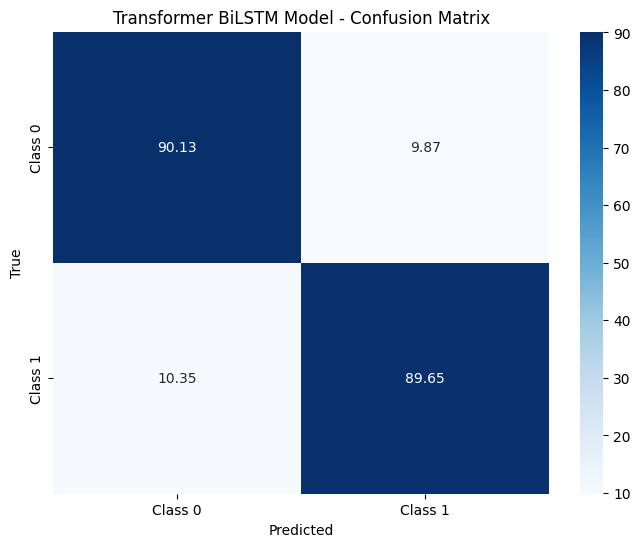

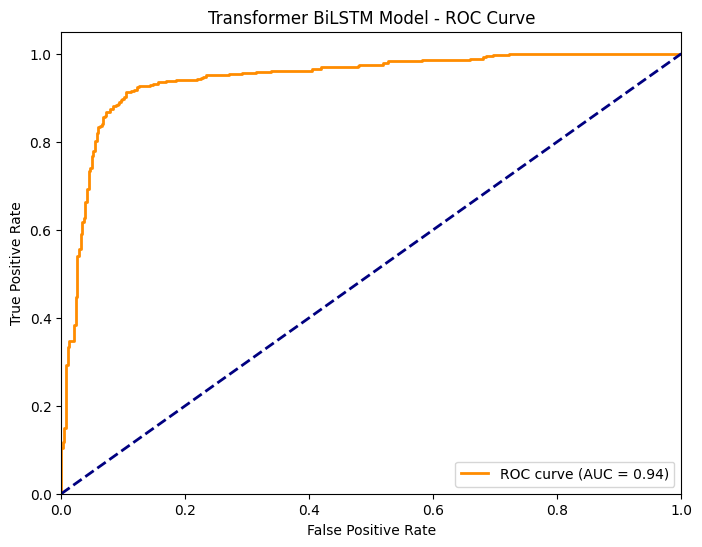

In [ ]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, roc_auc_score, matthews_corrcoef, roc_curve
import seaborn as sns
import matplotlib.pyplot as plt
import os

# تعریف دیتاست سفارشی برای تست
class CustomTestDataset(Dataset):
    def __init__(self, data, labels=None):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if self.labels is not None:
            return torch.tensor(self.data[idx], dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.long)
        else:
            return torch.tensor(self.data[idx], dtype=torch.float32)

# تابع برای بارگذاری داده‌های تست به عنوان DataLoader
def load_test_data_as_dataloader(file_paths, labels=None, batch_size=32):
    data = []
    for file_path in file_paths:
        data.append(np.load(file_path))
    data = np.concatenate(data, axis=0)
    dataset = CustomTestDataset(data, labels)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    return dataloader

# مدل ترنسفورمر با BiLSTM برای تست
class TransformerWithBiLSTM(nn.Module):
    def __init__(self, input_dim, num_classes, num_heads=8, num_layers=2, lstm_hidden_dim=32, dropout_rate=0.5):
        super(TransformerWithBiLSTM, self).__init__()

        # لایه‌های BiLSTM
        self.bilstm = nn.LSTM(input_size=input_dim, hidden_size=lstm_hidden_dim,
                              num_layers=num_layers, batch_first=True, bidirectional=True, dropout=dropout_rate)

        self.attention_layers = nn.ModuleList([nn.MultiheadAttention(embed_dim=lstm_hidden_dim * 2, num_heads=num_heads) for _ in range(num_layers)])

        self.layer_norm = nn.LayerNorm(lstm_hidden_dim * 2)
        self.fc1 = nn.Linear(lstm_hidden_dim * 2, 64)  # کاهش ابعاد لایه خطی
        self.dropout = nn.Dropout(dropout_rate)        # تغییر نرخ Dropout
        self.fc2 = nn.Linear(64, num_classes)          # سازگاری با ابعاد جدید

    def forward(self, x):
        # عبور از لایه BiLSTM
        lstm_out, _ = self.bilstm(x)

        # عبور از لایه‌های ترنسفورمر
        lstm_out = lstm_out.transpose(0, 1)  # برای سازگاری با PyTorch
        for attention in self.attention_layers:
            lstm_out, _ = attention(lstm_out, lstm_out, lstm_out)

        lstm_out = lstm_out.transpose(0, 1)  # بازگشت به شکل اولیه
        lstm_out = self.layer_norm(lstm_out)
        lstm_out = torch.mean(lstm_out, dim=1)  # GlobalAveragePooling
        lstm_out = torch.relu(self.fc1(lstm_out))
        lstm_out = self.dropout(lstm_out)       # اعمال Dropout
        lstm_out = torch.softmax(self.fc2(lstm_out), dim=-1)
        return lstm_out

# تابع تست مدل
def test_transformer_model(test_loader, model_load_path, input_dim=1024, num_classes=2):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = TransformerWithBiLSTM(input_dim=input_dim, num_classes=num_classes)
    model.to(device)

    # بارگذاری مدل ذخیره‌شده
    model.load_state_dict(torch.load(model_load_path, map_location=device))
    model.eval()

    all_predictions = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for data, labels in test_loader:
            data, labels = data.to(device), labels.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(outputs.cpu().numpy()[:, 1])  # احتمال برچسب مثبت

    all_probs = np.array(all_probs)
    return np.array(all_labels), np.array(all_predictions), all_probs

# محاسبه و نمایش معیارهای عملکرد
def calculate_metrics(y_true, y_pred_labels, y_pred_probs):
    cm = confusion_matrix(y_true, y_pred_labels)
    tn, fp, fn, tp = cm.ravel()
    sensitivity = tp / (tp + fn) * 100
    specificity = tn / (tn + fp) * 100
    accuracy = accuracy_score(y_true, y_pred_labels) * 100
    f1 = f1_score(y_true, y_pred_labels) * 100
    mcc = matthews_corrcoef(y_true, y_pred_labels) * 100
    auroc = roc_auc_score(y_true, y_pred_probs) * 100
    print(f"Sensitivity:     {sensitivity:.2f}%")
    print(f"Specificity:     {specificity:.2f}%")
    print(f"Accuracy:        {accuracy:.2f}%")
    print(f"F1 Score:        {f1:.2f}%")
    print(f"MCC:             {mcc:.2f}%")
    print(f"auROC:           {auroc:.2f}%")

# نمایش ماتریس کانفیوژن درصدی و ذخیره تصویر
def display_conf_matrix(y_true, y_pred_labels, title, filename):
    cm = confusion_matrix(y_true, y_pred_labels)
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_percent, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=['Class 0', 'Class 1'],
                yticklabels=['Class 0', 'Class 1'])
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig(filename)
    plt.show()

# رسم نمودار ROC
def plot_roc_curve(y_true, y_pred_probs, title, filename):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_score(y_true, y_pred_probs):.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.savefig(filename)
    plt.show()

# مسیر فایل‌های تست
test_save_paths_X = ['/content/drive/MyDrive/LM-RESULT2/resized_X_TEST.npy']
test_label_csv_path = '/content/drive/MyDrive/LM-RESULT2/y_test_final.csv'

# بارگذاری برچسب‌های تست
y_test = np.loadtxt(test_label_csv_path, delimiter=',', dtype=int)

# آماده‌سازی داده‌ها به عنوان DataLoader برای تست
test_loader = load_test_data_as_dataloader(test_save_paths_X, labels=y_test, batch_size=32)

# مسیر مدل ذخیره شده
model_load_path = '/content/drive/MyDrive/LM-RESULT2/best25_model.pth'

# تست مدل
y_true, y_pred_labels, predicted_probs = test_transformer_model(test_loader, model_load_path)

# محاسبه معیارها
calculate_metrics(y_true, y_pred_labels, predicted_probs)

# ایجاد دایرکتوری برای ذخیره تصاویر در صورت عدم وجود
output_dir = '/content/drive/MyDrive/my_project/LMPred_AMP_Prediction/Figuresfinal'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# نمایش و ذخیره ماتریس کانفیوژن
output_file_cm = os.path.join(output_dir, 'Transformer_BiLSTM3_Model_CM.png')
display_conf_matrix(y_true, y_pred_labels, 'Transformer BiLSTM Model - Confusion Matrix', output_file_cm)

# نمایش و ذخیره نمودار ROC
output_file_roc = os.path.join(output_dir, 'Transformer_BiLSTM3_Model_ROC.png')
plot_roc_curve(y_true, predicted_probs, 'Transformer BiLSTM Model - ROC Curve', output_file_roc)


In [ ]:
irنرخ یادگیری 0.001

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt

# تعریف دیتاست سفارشی
class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return torch.tensor(self.data[idx], dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.long)

# تابع برای بارگذاری داده‌ها به عنوان DataLoader
def load_data_as_dataloader(file_paths, labels, batch_size, percentage=1.0):
    data = []
    for file_path in file_paths:
        data.append(np.load(file_path))
    data = np.concatenate(data, axis=0)

    # استفاده از درصدی از داده‌ها
    num_samples = data.shape[0]
    subset_size = int(num_samples * percentage)
    data = data[:subset_size]
    labels = labels[:subset_size]

    dataset = CustomDataset(data, labels)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return dataloader

# مدل ترنسفورمر با لایه‌های BiLSTM در PyTorch
class TransformerWithBiLSTM(nn.Module):
    def __init__(self, input_dim, num_classes, num_heads=8, num_layers=2, lstm_hidden_dim=32, dropout_rate=0.3):
        super(TransformerWithBiLSTM, self).__init__()

        # لایه‌های BiLSTM
        self.bilstm = nn.LSTM(input_size=input_dim, hidden_size=lstm_hidden_dim,
                              num_layers=num_layers, batch_first=True, bidirectional=True, dropout=dropout_rate)

        self.attention_layers = nn.ModuleList([
            nn.MultiheadAttention(embed_dim=lstm_hidden_dim * 2, num_heads=num_heads) for _ in range(num_layers)
        ])

        self.layer_norm = nn.LayerNorm(lstm_hidden_dim * 2)
        self.fc1 = nn.Linear(lstm_hidden_dim * 2, 64)  # کاهش ابعاد لایه خطی
        self.dropout = nn.Dropout(dropout_rate)        # تغییر نرخ Dropout
        self.fc2 = nn.Linear(64, num_classes)          # سازگاری با ابعاد جدید

    def forward(self, x):
        # عبور از لایه BiLSTM
        lstm_out, _ = self.bilstm(x)

        # عبور از لایه‌های ترنسفورمر
        lstm_out = lstm_out.transpose(0, 1)  # برای سازگاری با PyTorch
        for attention in self.attention_layers:
            lstm_out, _ = attention(lstm_out, lstm_out, lstm_out)

        lstm_out = lstm_out.transpose(0, 1)  # بازگشت به شکل اولیه
        lstm_out = self.layer_norm(lstm_out)
        lstm_out = torch.mean(lstm_out, dim=1)  # GlobalAveragePooling
        lstm_out = torch.relu(self.fc1(lstm_out))
        lstm_out = self.dropout(lstm_out)       # اعمال Dropout
        lstm_out = self.fc2(lstm_out)           # عدم نیاز به Softmax چون CrossEntropyLoss آن را خودکار انجام می‌دهد
        return lstm_out

# تابع آموزش مدل
def train_transformer_model(train_loader, val_loader, input_dim, num_classes, model_save_path, plot_save_path, epochs=100, batch_size=32):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # ایجاد مدل و انتقال به GPU
    model = TransformerWithBiLSTM(input_dim=input_dim, num_classes=num_classes)
    model.to(device)

    optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)  # استفاده از AdamW
    criterion = nn.CrossEntropyLoss()

    # تنظیم نرخ یادگیری
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)

    # لیست‌های ذخیره تاریخچه خطا و دقت
    train_loss_history = []
    val_loss_history = []

    best_val_accuracy = 0.0
    early_stopping_counter = 0  # شمارش برای Early Stopping
    patience = 10  # تعداد ایپوک‌ها برای توقف

    # آموزش مدل
    for epoch in range(epochs):
        model.train()
        total_train_loss = 0
        correct_train = 0
        total_train = 0

        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_train += batch_y.size(0)
            correct_train += (predicted == batch_y).sum().item()

        train_accuracy = 100 * correct_train / total_train

        # اعتبارسنجی مدل
        model.eval()
        total_val_loss = 0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for val_X, val_y in val_loader:
                val_X, val_y = val_X.to(device), val_y.to(device)
                outputs = model(val_X)
                loss = criterion(outputs, val_y)
                total_val_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total_val += val_y.size(0)
                correct_val += (predicted == val_y).sum().item()

        val_accuracy = 100 * correct_val / total_val

        train_loss_history.append(total_train_loss / len(train_loader))
        val_loss_history.append(total_val_loss / len(val_loader))

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {total_train_loss / len(train_loader):.4f}, Val Loss: {total_val_loss / len(val_loader):.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Accuracy: {val_accuracy:.2f}%")

        # ذخیره مدل اگر دقت اعتبارسنجی بهبود یافته باشد
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            torch.save(model.state_dict(), model_save_path)
            print(f"New best model saved with Val Accuracy: {val_accuracy:.2f}%")
            early_stopping_counter = 0  # بازنشانی شمارش
        else:
            early_stopping_counter += 1  # افزایش شمارش

        # بروزرسانی نرخ یادگیری
        scheduler.step(total_val_loss)  # به روز رسانی نرخ یادگیری با توجه به ولیدیشن Loss

        # اگر دقت ولیدیشن بهبود نیافت، آموزش متوقف شود
        if early_stopping_counter >= patience:
            print(f"Early stopping triggered after {epoch + 1} epochs.")
            break

    # ذخیره نمودارها
    plt.figure(figsize=(10, 5))
    plt.plot(train_loss_history, label='Train Loss')
    plt.plot(val_loss_history, label='Val Loss')
    plt.title('Model Performance')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(plot_save_path)
    plt.close()
    print(f"Plots saved to {plot_save_path}")

# فراخوانی تابع train_transformer_model

# مسیر فایل‌ها
save_paths_X = [
    '/content/drive/MyDrive/LM-RESULT2/resized_X_TRAIN_batch_1.npy',
    '/content/drive/MyDrive/LM-RESULT2/resized_X_TRAIN_batch_2.npy',
    '/content/drive/MyDrive/LM-RESULT2/resized_X_TRAIN_batch_3.npy',
    '/content/drive/MyDrive/LM-RESULT2/resized_X_TRAIN_batch_4.npy',
    '/content/drive/MyDrive/LM-RESULT2/resized_X_TRAIN_batch_5.npy',
    '/content/drive/MyDrive/LM-RESULT2/resized_X_TRAIN_batch_6.npy'
]
val_save_path_X = '/content/drive/MyDrive/LM-RESULT2/resized_X_val.npy'
val_label_csv_path = '/content/drive/MyDrive/LM-RESULT2/y_val_final.csv'

# بارگذاری برچسب‌ها
train_labels = np.loadtxt('/content/drive/MyDrive/LM-RESULT2/y_train_final.csv', delimiter=',', dtype=int)
val_labels = np.loadtxt(val_label_csv_path, delimiter=',', dtype=int)

# آماده‌سازی داده‌ها به عنوان DataLoader برای 100 درصد داده‌ها
train_loader = load_data_as_dataloader(save_paths_X, train_labels, batch_size=32, percentage=1.0)
val_loader = load_data_as_dataloader([val_save_path_X], val_labels, batch_size=32, percentage=1.0)

# تنظیمات مدل و آموزش با 100 ایپوک
input_dim = 1024  # ابعاد ورودی داده‌ها (باید با داده‌ها سازگار باشد)
num_classes = 2   # تعداد کلاس‌ها (برچسب‌ها)

train_transformer_model(
    train_loader,          # داده‌های آموزشی
    val_loader,            # داده‌های اعتبارسنجی
    input_dim=input_dim,   # ابعاد ورودی
    num_classes=num_classes,  # تعداد کلاس‌ها
    model_save_path='/content/drive/MyDrive/LM-RESULT2/best26_model.pth',  # مسیر ذخیره مدل
    plot_save_path='/content/drive/MyDrive/LM-RESULT2/training26_plot.png',  # مسیر ذخیره نمودار
    epochs=100,            # تعداد ایپوک‌ها
    batch_size=32          # اندازه بچ
)


Epoch 1/100, Train Loss: 0.4300, Val Loss: 0.3136, Train Accuracy: 80.17%, Val Accuracy: 87.96%
New best model saved with Val Accuracy: 87.96%
Epoch 2/100, Train Loss: 0.2792, Val Loss: 0.2762, Train Accuracy: 89.74%, Val Accuracy: 89.49%
New best model saved with Val Accuracy: 89.49%
Epoch 3/100, Train Loss: 0.2392, Val Loss: 0.2813, Train Accuracy: 91.54%, Val Accuracy: 89.69%
New best model saved with Val Accuracy: 89.69%
Epoch 4/100, Train Loss: 0.2044, Val Loss: 0.2712, Train Accuracy: 93.04%, Val Accuracy: 89.69%
Epoch 5/100, Train Loss: 0.1638, Val Loss: 0.3012, Train Accuracy: 94.34%, Val Accuracy: 90.29%
New best model saved with Val Accuracy: 90.29%
Epoch 6/100, Train Loss: 0.1279, Val Loss: 0.3836, Train Accuracy: 95.69%, Val Accuracy: 89.49%
Epoch 7/100, Train Loss: 0.1312, Val Loss: 0.3844, Train Accuracy: 95.72%, Val Accuracy: 87.62%
Epoch 8/100, Train Loss: 0.1070, Val Loss: 0.3604, Train Accuracy: 96.37%, Val Accuracy: 88.69%
Epoch 9/100, Train Loss: 0.0705, Val Loss: 0

<ipython-input-2-e947b64b769d>:76: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_load_path, map_location=device))


Sensitivity:     90.19%
Specificity:     91.43%
Accuracy:        90.82%
F1 Score:        90.56%
MCC:             81.64%
auROC:           95.39%


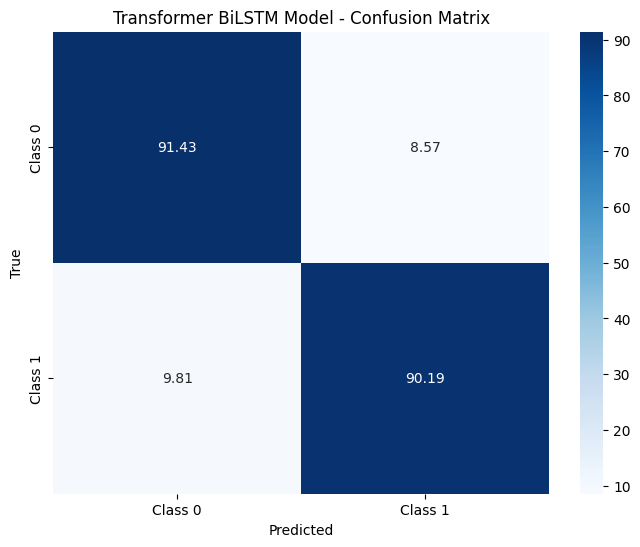

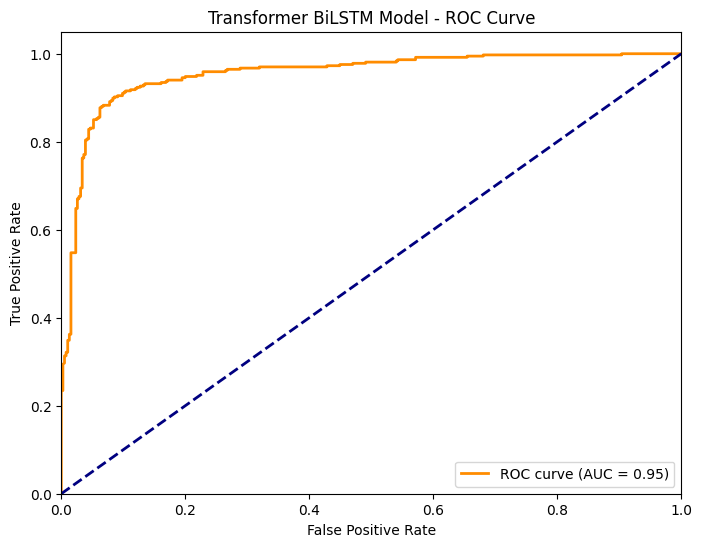

In [ ]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, roc_auc_score, matthews_corrcoef, roc_curve
import seaborn as sns
import matplotlib.pyplot as plt
import os

# تعریف دیتاست سفارشی برای تست
class CustomTestDataset(Dataset):
    def __init__(self, data, labels=None):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if self.labels is not None:
            return torch.tensor(self.data[idx], dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.long)
        else:
            return torch.tensor(self.data[idx], dtype=torch.float32)

# تابع برای بارگذاری داده‌های تست به عنوان DataLoader
def load_test_data_as_dataloader(file_paths, labels=None, batch_size=32):
    data = []
    for file_path in file_paths:
        data.append(np.load(file_path))
    data = np.concatenate(data, axis=0)
    dataset = CustomTestDataset(data, labels)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    return dataloader

# مدل ترنسفورمر با BiLSTM برای تست
class TransformerWithBiLSTM(nn.Module):
    def __init__(self, input_dim, num_classes, num_heads=8, num_layers=2, lstm_hidden_dim=32, dropout_rate=0.3):
        super(TransformerWithBiLSTM, self).__init__()

        # لایه‌های BiLSTM
        self.bilstm = nn.LSTM(input_size=input_dim, hidden_size=lstm_hidden_dim,
                              num_layers=num_layers, batch_first=True, bidirectional=True, dropout=dropout_rate)

        self.attention_layers = nn.ModuleList([nn.MultiheadAttention(embed_dim=lstm_hidden_dim * 2, num_heads=num_heads) for _ in range(num_layers)])

        self.layer_norm = nn.LayerNorm(lstm_hidden_dim * 2)
        self.fc1 = nn.Linear(lstm_hidden_dim * 2, 64)  # کاهش ابعاد لایه خطی
        self.dropout = nn.Dropout(dropout_rate)        # تغییر نرخ Dropout
        self.fc2 = nn.Linear(64, num_classes)          # سازگاری با ابعاد جدید

    def forward(self, x):
        # عبور از لایه BiLSTM
        lstm_out, _ = self.bilstm(x)

        # عبور از لایه‌های ترنسفورمر
        lstm_out = lstm_out.transpose(0, 1)  # برای سازگاری با PyTorch
        for attention in self.attention_layers:
            lstm_out, _ = attention(lstm_out, lstm_out, lstm_out)

        lstm_out = lstm_out.transpose(0, 1)  # بازگشت به شکل اولیه
        lstm_out = self.layer_norm(lstm_out)
        lstm_out = torch.mean(lstm_out, dim=1)  # GlobalAveragePooling
        lstm_out = torch.relu(self.fc1(lstm_out))
        lstm_out = self.dropout(lstm_out)       # اعمال Dropout
        lstm_out = torch.softmax(self.fc2(lstm_out), dim=-1)
        return lstm_out

# تابع تست مدل
def test_transformer_model(test_loader, model_load_path, input_dim=1024, num_classes=2):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = TransformerWithBiLSTM(input_dim=input_dim, num_classes=num_classes)
    model.to(device)

    # بارگذاری مدل ذخیره‌شده
    model.load_state_dict(torch.load(model_load_path, map_location=device))
    model.eval()

    all_predictions = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for data, labels in test_loader:
            data, labels = data.to(device), labels.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(outputs.cpu().numpy()[:, 1])  # احتمال برچسب مثبت

    all_probs = np.array(all_probs)
    return np.array(all_labels), np.array(all_predictions), all_probs

# محاسبه و نمایش معیارهای عملکرد
def calculate_metrics(y_true, y_pred_labels, y_pred_probs):
    cm = confusion_matrix(y_true, y_pred_labels)
    tn, fp, fn, tp = cm.ravel()
    sensitivity = tp / (tp + fn) * 100
    specificity = tn / (tn + fp) * 100
    accuracy = accuracy_score(y_true, y_pred_labels) * 100
    f1 = f1_score(y_true, y_pred_labels) * 100
    mcc = matthews_corrcoef(y_true, y_pred_labels) * 100
    auroc = roc_auc_score(y_true, y_pred_probs) * 100
    print(f"Sensitivity:     {sensitivity:.2f}%")
    print(f"Specificity:     {specificity:.2f}%")
    print(f"Accuracy:        {accuracy:.2f}%")
    print(f"F1 Score:        {f1:.2f}%")
    print(f"MCC:             {mcc:.2f}%")
    print(f"auROC:           {auroc:.2f}%")

# نمایش ماتریس کانفیوژن درصدی و ذخیره تصویر
def display_conf_matrix(y_true, y_pred_labels, title, filename):
    cm = confusion_matrix(y_true, y_pred_labels)
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_percent, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=['Class 0', 'Class 1'],
                yticklabels=['Class 0', 'Class 1'])
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig(filename)
    plt.show()

# رسم نمودار ROC
def plot_roc_curve(y_true, y_pred_probs, title, filename):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_score(y_true, y_pred_probs):.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.savefig(filename)
    plt.show()

# مسیر فایل‌های تست
test_save_paths_X = ['/content/drive/MyDrive/LM-RESULT2/resized_X_TEST.npy']
test_label_csv_path = '/content/drive/MyDrive/LM-RESULT2/y_test_final.csv'

# بارگذاری برچسب‌های تست
y_test = np.loadtxt(test_label_csv_path, delimiter=',', dtype=int)

# آماده‌سازی داده‌ها به عنوان DataLoader برای تست
test_loader = load_test_data_as_dataloader(test_save_paths_X, labels=y_test, batch_size=32)

# مسیر مدل ذخیره شده
model_load_path = '/content/drive/MyDrive/LM-RESULT2/best26_model.pth'

# تست مدل
y_true, y_pred_labels, predicted_probs = test_transformer_model(test_loader, model_load_path)

# محاسبه معیارها
calculate_metrics(y_true, y_pred_labels, predicted_probs)

# ایجاد دایرکتوری برای ذخیره تصاویر در صورت عدم وجود
output_dir = '/content/drive/MyDrive/my_project/LMPred_AMP_Prediction/Figuresfinal'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# نمایش و ذخیره ماتریس کانفیوژن
output_file_cm = os.path.join(output_dir, 'Transformer_BiLSTM3_Model_CM.png')
display_conf_matrix(y_true, y_pred_labels, 'Transformer BiLSTM Model - Confusion Matrix', output_file_cm)

# نمایش و ذخیره نمودار ROC
output_file_roc = os.path.join(output_dir, 'Transformer_BiLSTM3_Model_ROC.png')
plot_roc_curve(y_true, predicted_probs, 'Transformer BiLSTM Model - ROC Curve', output_file_roc)


In [ ]:
ir 0.004

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt

# تعریف دیتاست سفارشی
class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return torch.tensor(self.data[idx], dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.long)

# تابع برای بارگذاری داده‌ها به عنوان DataLoader
def load_data_as_dataloader(file_paths, labels, batch_size, percentage=1.0):
    data = []
    for file_path in file_paths:
        data.append(np.load(file_path))
    data = np.concatenate(data, axis=0)

    # استفاده از درصدی از داده‌ها
    num_samples = data.shape[0]
    subset_size = int(num_samples * percentage)
    data = data[:subset_size]
    labels = labels[:subset_size]

    dataset = CustomDataset(data, labels)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return dataloader

# مدل ترنسفورمر با لایه‌های BiLSTM در PyTorch
class TransformerWithBiLSTM(nn.Module):
    def __init__(self, input_dim, num_classes, num_heads=8, num_layers=2, lstm_hidden_dim=32, dropout_rate=0.3):
        super(TransformerWithBiLSTM, self).__init__()

        # لایه‌های BiLSTM
        self.bilstm = nn.LSTM(input_size=input_dim, hidden_size=lstm_hidden_dim,
                              num_layers=num_layers, batch_first=True, bidirectional=True, dropout=dropout_rate)

        self.attention_layers = nn.ModuleList([
            nn.MultiheadAttention(embed_dim=lstm_hidden_dim * 2, num_heads=num_heads) for _ in range(num_layers)
        ])

        self.layer_norm = nn.LayerNorm(lstm_hidden_dim * 2)
        self.fc1 = nn.Linear(lstm_hidden_dim * 2, 64)  # کاهش ابعاد لایه خطی
        self.dropout = nn.Dropout(dropout_rate)        # تغییر نرخ Dropout
        self.fc2 = nn.Linear(64, num_classes)          # سازگاری با ابعاد جدید

    def forward(self, x):
        # عبور از لایه BiLSTM
        lstm_out, _ = self.bilstm(x)

        # عبور از لایه‌های ترنسفورمر
        lstm_out = lstm_out.transpose(0, 1)  # برای سازگاری با PyTorch
        for attention in self.attention_layers:
            lstm_out, _ = attention(lstm_out, lstm_out, lstm_out)

        lstm_out = lstm_out.transpose(0, 1)  # بازگشت به شکل اولیه
        lstm_out = self.layer_norm(lstm_out)
        lstm_out = torch.mean(lstm_out, dim=1)  # GlobalAveragePooling
        lstm_out = torch.relu(self.fc1(lstm_out))
        lstm_out = self.dropout(lstm_out)       # اعمال Dropout
        lstm_out = self.fc2(lstm_out)           # عدم نیاز به Softmax چون CrossEntropyLoss آن را خودکار انجام می‌دهد
        return lstm_out

# تابع آموزش مدل
def train_transformer_model(train_loader, val_loader, input_dim, num_classes, model_save_path, plot_save_path, epochs=100, batch_size=32):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # ایجاد مدل و انتقال به GPU
    model = TransformerWithBiLSTM(input_dim=input_dim, num_classes=num_classes)
    model.to(device)

    optimizer = optim.AdamW(model.parameters(), lr=0.004, weight_decay=1e-4)  # استفاده از AdamW
    criterion = nn.CrossEntropyLoss()

    # تنظیم نرخ یادگیری
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)

    # لیست‌های ذخیره تاریخچه خطا و دقت
    train_loss_history = []
    val_loss_history = []

    best_val_accuracy = 0.0
    early_stopping_counter = 0  # شمارش برای Early Stopping
    patience = 10  # تعداد ایپوک‌ها برای توقف

    # آموزش مدل
    for epoch in range(epochs):
        model.train()
        total_train_loss = 0
        correct_train = 0
        total_train = 0

        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_train += batch_y.size(0)
            correct_train += (predicted == batch_y).sum().item()

        train_accuracy = 100 * correct_train / total_train

        # اعتبارسنجی مدل
        model.eval()
        total_val_loss = 0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for val_X, val_y in val_loader:
                val_X, val_y = val_X.to(device), val_y.to(device)
                outputs = model(val_X)
                loss = criterion(outputs, val_y)
                total_val_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total_val += val_y.size(0)
                correct_val += (predicted == val_y).sum().item()

        val_accuracy = 100 * correct_val / total_val

        train_loss_history.append(total_train_loss / len(train_loader))
        val_loss_history.append(total_val_loss / len(val_loader))

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {total_train_loss / len(train_loader):.4f}, Val Loss: {total_val_loss / len(val_loader):.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Accuracy: {val_accuracy:.2f}%")

        # ذخیره مدل اگر دقت اعتبارسنجی بهبود یافته باشد
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            torch.save(model.state_dict(), model_save_path)
            print(f"New best model saved with Val Accuracy: {val_accuracy:.2f}%")
            early_stopping_counter = 0  # بازنشانی شمارش
        else:
            early_stopping_counter += 1  # افزایش شمارش

        # بروزرسانی نرخ یادگیری
        scheduler.step(total_val_loss)  # به روز رسانی نرخ یادگیری با توجه به ولیدیشن Loss

        # اگر دقت ولیدیشن بهبود نیافت، آموزش متوقف شود
        if early_stopping_counter >= patience:
            print(f"Early stopping triggered after {epoch + 1} epochs.")
            break

    # ذخیره نمودارها
    plt.figure(figsize=(10, 5))
    plt.plot(train_loss_history, label='Train Loss')
    plt.plot(val_loss_history, label='Val Loss')
    plt.title('Model Performance')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(plot_save_path)
    plt.close()
    print(f"Plots saved to {plot_save_path}")

# فراخوانی تابع train_transformer_model

# مسیر فایل‌ها
save_paths_X = [
    '/content/drive/MyDrive/LM-RESULT2/resized_X_TRAIN_batch_1.npy',
    '/content/drive/MyDrive/LM-RESULT2/resized_X_TRAIN_batch_2.npy',
    '/content/drive/MyDrive/LM-RESULT2/resized_X_TRAIN_batch_3.npy',
    '/content/drive/MyDrive/LM-RESULT2/resized_X_TRAIN_batch_4.npy',
    '/content/drive/MyDrive/LM-RESULT2/resized_X_TRAIN_batch_5.npy',
    '/content/drive/MyDrive/LM-RESULT2/resized_X_TRAIN_batch_6.npy'
]
val_save_path_X = '/content/drive/MyDrive/LM-RESULT2/resized_X_val.npy'
val_label_csv_path = '/content/drive/MyDrive/LM-RESULT2/y_val_final.csv'

# بارگذاری برچسب‌ها
train_labels = np.loadtxt('/content/drive/MyDrive/LM-RESULT2/y_train_final.csv', delimiter=',', dtype=int)
val_labels = np.loadtxt(val_label_csv_path, delimiter=',', dtype=int)

# آماده‌سازی داده‌ها به عنوان DataLoader برای 100 درصد داده‌ها
train_loader = load_data_as_dataloader(save_paths_X, train_labels, batch_size=32, percentage=1.0)
val_loader = load_data_as_dataloader([val_save_path_X], val_labels, batch_size=32, percentage=1.0)

# تنظیمات مدل و آموزش با 100 ایپوک
input_dim = 1024  # ابعاد ورودی داده‌ها (باید با داده‌ها سازگار باشد)
num_classes = 2   # تعداد کلاس‌ها (برچسب‌ها)

train_transformer_model(
    train_loader,          # داده‌های آموزشی
    val_loader,            # داده‌های اعتبارسنجی
    input_dim=input_dim,   # ابعاد ورودی
    num_classes=num_classes,  # تعداد کلاس‌ها
    model_save_path='/content/drive/MyDrive/LM-RESULT2/best27_model.pth',  # مسیر ذخیره مدل
    plot_save_path='/content/drive/MyDrive/LM-RESULT2/training27_plot.png',  # مسیر ذخیره نمودار
    epochs=100,            # تعداد ایپوک‌ها
    batch_size=32          # اندازه بچ
)


Epoch 1/100, Train Loss: 0.4781, Val Loss: 0.4856, Train Accuracy: 76.49%, Val Accuracy: 81.90%
New best model saved with Val Accuracy: 81.90%
Epoch 2/100, Train Loss: 0.3509, Val Loss: 0.3393, Train Accuracy: 87.17%, Val Accuracy: 86.96%
New best model saved with Val Accuracy: 86.96%
Epoch 3/100, Train Loss: 0.2852, Val Loss: 0.3397, Train Accuracy: 89.83%, Val Accuracy: 87.36%
New best model saved with Val Accuracy: 87.36%
Epoch 4/100, Train Loss: 0.2542, Val Loss: 0.3385, Train Accuracy: 90.88%, Val Accuracy: 88.76%
New best model saved with Val Accuracy: 88.76%
Epoch 5/100, Train Loss: 0.2120, Val Loss: 0.3112, Train Accuracy: 92.91%, Val Accuracy: 89.35%
New best model saved with Val Accuracy: 89.35%
Epoch 6/100, Train Loss: 0.1816, Val Loss: 0.3157, Train Accuracy: 94.16%, Val Accuracy: 89.62%
New best model saved with Val Accuracy: 89.62%
Epoch 7/100, Train Loss: 0.1631, Val Loss: 0.3802, Train Accuracy: 94.75%, Val Accuracy: 88.96%
Epoch 8/100, Train Loss: 0.1843, Val Loss: 0.3

<ipython-input-2-7bd3d4827fe7>:76: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_load_path, map_location=device))


Sensitivity:     91.28%
Specificity:     89.61%
Accuracy:        90.43%
F1 Score:        90.30%
MCC:             80.87%
auROC:           95.20%


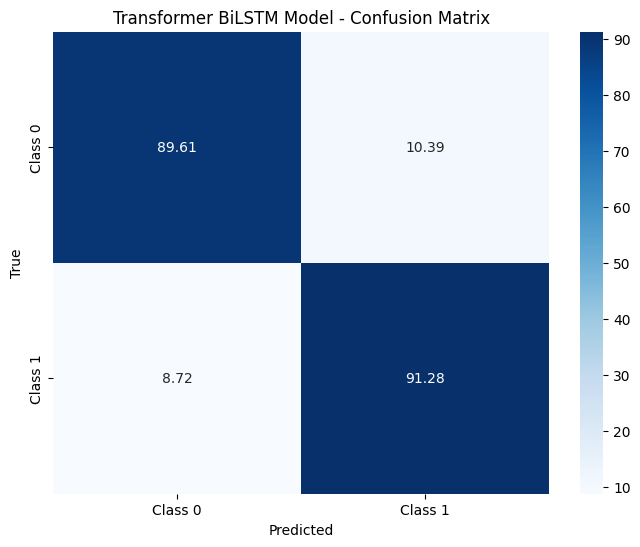

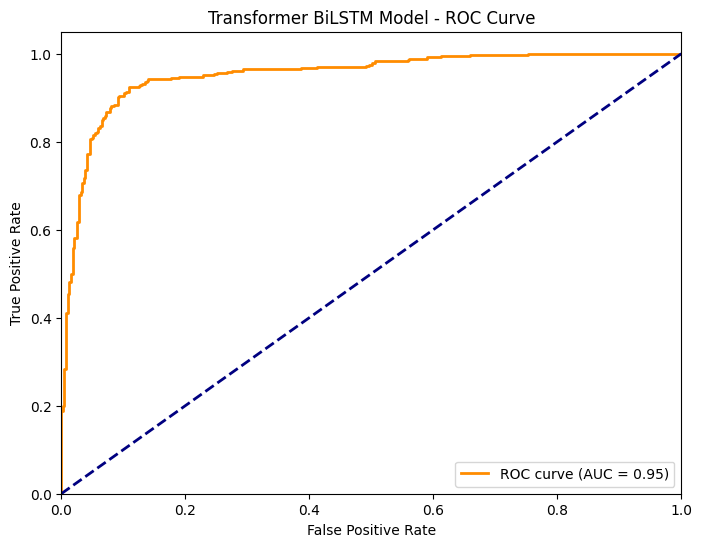

In [ ]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, roc_auc_score, matthews_corrcoef, roc_curve
import seaborn as sns
import matplotlib.pyplot as plt
import os

# تعریف دیتاست سفارشی برای تست
class CustomTestDataset(Dataset):
    def __init__(self, data, labels=None):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if self.labels is not None:
            return torch.tensor(self.data[idx], dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.long)
        else:
            return torch.tensor(self.data[idx], dtype=torch.float32)

# تابع برای بارگذاری داده‌های تست به عنوان DataLoader
def load_test_data_as_dataloader(file_paths, labels=None, batch_size=32):
    data = []
    for file_path in file_paths:
        data.append(np.load(file_path))
    data = np.concatenate(data, axis=0)
    dataset = CustomTestDataset(data, labels)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    return dataloader

# مدل ترنسفورمر با BiLSTM برای تست
class TransformerWithBiLSTM(nn.Module):
    def __init__(self, input_dim, num_classes, num_heads=8, num_layers=2, lstm_hidden_dim=32, dropout_rate=0.3):
        super(TransformerWithBiLSTM, self).__init__()

        # لایه‌های BiLSTM
        self.bilstm = nn.LSTM(input_size=input_dim, hidden_size=lstm_hidden_dim,
                              num_layers=num_layers, batch_first=True, bidirectional=True, dropout=dropout_rate)

        self.attention_layers = nn.ModuleList([nn.MultiheadAttention(embed_dim=lstm_hidden_dim * 2, num_heads=num_heads) for _ in range(num_layers)])

        self.layer_norm = nn.LayerNorm(lstm_hidden_dim * 2)
        self.fc1 = nn.Linear(lstm_hidden_dim * 2, 64)  # کاهش ابعاد لایه خطی
        self.dropout = nn.Dropout(dropout_rate)        # تغییر نرخ Dropout
        self.fc2 = nn.Linear(64, num_classes)          # سازگاری با ابعاد جدید

    def forward(self, x):
        # عبور از لایه BiLSTM
        lstm_out, _ = self.bilstm(x)

        # عبور از لایه‌های ترنسفورمر
        lstm_out = lstm_out.transpose(0, 1)  # برای سازگاری با PyTorch
        for attention in self.attention_layers:
            lstm_out, _ = attention(lstm_out, lstm_out, lstm_out)

        lstm_out = lstm_out.transpose(0, 1)  # بازگشت به شکل اولیه
        lstm_out = self.layer_norm(lstm_out)
        lstm_out = torch.mean(lstm_out, dim=1)  # GlobalAveragePooling
        lstm_out = torch.relu(self.fc1(lstm_out))
        lstm_out = self.dropout(lstm_out)       # اعمال Dropout
        lstm_out = torch.softmax(self.fc2(lstm_out), dim=-1)
        return lstm_out

# تابع تست مدل
def test_transformer_model(test_loader, model_load_path, input_dim=1024, num_classes=2):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = TransformerWithBiLSTM(input_dim=input_dim, num_classes=num_classes)
    model.to(device)

    # بارگذاری مدل ذخیره‌شده
    model.load_state_dict(torch.load(model_load_path, map_location=device))
    model.eval()

    all_predictions = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for data, labels in test_loader:
            data, labels = data.to(device), labels.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(outputs.cpu().numpy()[:, 1])  # احتمال برچسب مثبت

    all_probs = np.array(all_probs)
    return np.array(all_labels), np.array(all_predictions), all_probs

# محاسبه و نمایش معیارهای عملکرد
def calculate_metrics(y_true, y_pred_labels, y_pred_probs):
    cm = confusion_matrix(y_true, y_pred_labels)
    tn, fp, fn, tp = cm.ravel()
    sensitivity = tp / (tp + fn) * 100
    specificity = tn / (tn + fp) * 100
    accuracy = accuracy_score(y_true, y_pred_labels) * 100
    f1 = f1_score(y_true, y_pred_labels) * 100
    mcc = matthews_corrcoef(y_true, y_pred_labels) * 100
    auroc = roc_auc_score(y_true, y_pred_probs) * 100
    print(f"Sensitivity:     {sensitivity:.2f}%")
    print(f"Specificity:     {specificity:.2f}%")
    print(f"Accuracy:        {accuracy:.2f}%")
    print(f"F1 Score:        {f1:.2f}%")
    print(f"MCC:             {mcc:.2f}%")
    print(f"auROC:           {auroc:.2f}%")

# نمایش ماتریس کانفیوژن درصدی و ذخیره تصویر
def display_conf_matrix(y_true, y_pred_labels, title, filename):
    cm = confusion_matrix(y_true, y_pred_labels)
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_percent, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=['Class 0', 'Class 1'],
                yticklabels=['Class 0', 'Class 1'])
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig(filename)
    plt.show()

# رسم نمودار ROC
def plot_roc_curve(y_true, y_pred_probs, title, filename):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_score(y_true, y_pred_probs):.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.savefig(filename)
    plt.show()

# مسیر فایل‌های تست
test_save_paths_X = ['/content/drive/MyDrive/LM-RESULT2/resized_X_TEST.npy']
test_label_csv_path = '/content/drive/MyDrive/LM-RESULT2/y_test_final.csv'

# بارگذاری برچسب‌های تست
y_test = np.loadtxt(test_label_csv_path, delimiter=',', dtype=int)

# آماده‌سازی داده‌ها به عنوان DataLoader برای تست
test_loader = load_test_data_as_dataloader(test_save_paths_X, labels=y_test, batch_size=32)

# مسیر مدل ذخیره شده
model_load_path = '/content/drive/MyDrive/LM-RESULT2/best27_model.pth'

# تست مدل
y_true, y_pred_labels, predicted_probs = test_transformer_model(test_loader, model_load_path)

# محاسبه معیارها
calculate_metrics(y_true, y_pred_labels, predicted_probs)

# ایجاد دایرکتوری برای ذخیره تصاویر در صورت عدم وجود
output_dir = '/content/drive/MyDrive/my_project/LMPred_AMP_Prediction/Figuresfinal'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# نمایش و ذخیره ماتریس کانفیوژن
output_file_cm = os.path.join(output_dir, 'Transformer_BiLSTM3_Model_CM.png')
display_conf_matrix(y_true, y_pred_labels, 'Transformer BiLSTM Model - Confusion Matrix', output_file_cm)

# نمایش و ذخیره نمودار ROC
output_file_roc = os.path.join(output_dir, 'Transformer_BiLSTM3_Model_ROC.png')
plot_roc_curve(y_true, predicted_probs, 'Transformer BiLSTM Model - ROC Curve', output_file_roc)


In [ ]:
0.0002 ir

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt

# تعریف دیتاست سفارشی
class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return torch.tensor(self.data[idx], dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.long)

# تابع برای بارگذاری داده‌ها به عنوان DataLoader
def load_data_as_dataloader(file_paths, labels, batch_size, percentage=1.0):
    data = []
    for file_path in file_paths:
        data.append(np.load(file_path))
    data = np.concatenate(data, axis=0)

    # استفاده از درصدی از داده‌ها
    num_samples = data.shape[0]
    subset_size = int(num_samples * percentage)
    data = data[:subset_size]
    labels = labels[:subset_size]

    dataset = CustomDataset(data, labels)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return dataloader

# مدل ترنسفورمر با لایه‌های BiLSTM در PyTorch
class TransformerWithBiLSTM(nn.Module):
    def __init__(self, input_dim, num_classes, num_heads=8, num_layers=2, lstm_hidden_dim=32, dropout_rate=0.3):
        super(TransformerWithBiLSTM, self).__init__()

        # لایه‌های BiLSTM
        self.bilstm = nn.LSTM(input_size=input_dim, hidden_size=lstm_hidden_dim,
                              num_layers=num_layers, batch_first=True, bidirectional=True, dropout=dropout_rate)

        self.attention_layers = nn.ModuleList([
            nn.MultiheadAttention(embed_dim=lstm_hidden_dim * 2, num_heads=num_heads) for _ in range(num_layers)
        ])

        self.layer_norm = nn.LayerNorm(lstm_hidden_dim * 2)
        self.fc1 = nn.Linear(lstm_hidden_dim * 2, 64)  # کاهش ابعاد لایه خطی
        self.dropout = nn.Dropout(dropout_rate)        # تغییر نرخ Dropout
        self.fc2 = nn.Linear(64, num_classes)          # سازگاری با ابعاد جدید

    def forward(self, x):
        # عبور از لایه BiLSTM
        lstm_out, _ = self.bilstm(x)

        # عبور از لایه‌های ترنسفورمر
        lstm_out = lstm_out.transpose(0, 1)  # برای سازگاری با PyTorch
        for attention in self.attention_layers:
            lstm_out, _ = attention(lstm_out, lstm_out, lstm_out)

        lstm_out = lstm_out.transpose(0, 1)  # بازگشت به شکل اولیه
        lstm_out = self.layer_norm(lstm_out)
        lstm_out = torch.mean(lstm_out, dim=1)  # GlobalAveragePooling
        lstm_out = torch.relu(self.fc1(lstm_out))
        lstm_out = self.dropout(lstm_out)       # اعمال Dropout
        lstm_out = self.fc2(lstm_out)           # عدم نیاز به Softmax چون CrossEntropyLoss آن را خودکار انجام می‌دهد
        return lstm_out

# تابع آموزش مدل
def train_transformer_model(train_loader, val_loader, input_dim, num_classes, model_save_path, plot_save_path, epochs=100, batch_size=32):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # ایجاد مدل و انتقال به GPU
    model = TransformerWithBiLSTM(input_dim=input_dim, num_classes=num_classes)
    model.to(device)

    optimizer = optim.AdamW(model.parameters(), lr=0.0002, weight_decay=1e-4)  # استفاده از AdamW
    criterion = nn.CrossEntropyLoss()

    # تنظیم نرخ یادگیری
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)

    # لیست‌های ذخیره تاریخچه خطا و دقت
    train_loss_history = []
    val_loss_history = []

    best_val_accuracy = 0.0
    early_stopping_counter = 0  # شمارش برای Early Stopping
    patience = 10  # تعداد ایپوک‌ها برای توقف

    # آموزش مدل
    for epoch in range(epochs):
        model.train()
        total_train_loss = 0
        correct_train = 0
        total_train = 0

        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_train += batch_y.size(0)
            correct_train += (predicted == batch_y).sum().item()

        train_accuracy = 100 * correct_train / total_train

        # اعتبارسنجی مدل
        model.eval()
        total_val_loss = 0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for val_X, val_y in val_loader:
                val_X, val_y = val_X.to(device), val_y.to(device)
                outputs = model(val_X)
                loss = criterion(outputs, val_y)
                total_val_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total_val += val_y.size(0)
                correct_val += (predicted == val_y).sum().item()

        val_accuracy = 100 * correct_val / total_val

        train_loss_history.append(total_train_loss / len(train_loader))
        val_loss_history.append(total_val_loss / len(val_loader))

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {total_train_loss / len(train_loader):.4f}, Val Loss: {total_val_loss / len(val_loader):.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Accuracy: {val_accuracy:.2f}%")

        # ذخیره مدل اگر دقت اعتبارسنجی بهبود یافته باشد
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            torch.save(model.state_dict(), model_save_path)
            print(f"New best model saved with Val Accuracy: {val_accuracy:.2f}%")
            early_stopping_counter = 0  # بازنشانی شمارش
        else:
            early_stopping_counter += 1  # افزایش شمارش

        # بروزرسانی نرخ یادگیری
        scheduler.step(total_val_loss)  # به روز رسانی نرخ یادگیری با توجه به ولیدیشن Loss

        # اگر دقت ولیدیشن بهبود نیافت، آموزش متوقف شود
        if early_stopping_counter >= patience:
            print(f"Early stopping triggered after {epoch + 1} epochs.")
            break

    # ذخیره نمودارها
    plt.figure(figsize=(10, 5))
    plt.plot(train_loss_history, label='Train Loss')
    plt.plot(val_loss_history, label='Val Loss')
    plt.title('Model Performance')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(plot_save_path)
    plt.close()
    print(f"Plots saved to {plot_save_path}")

# فراخوانی تابع train_transformer_model

# مسیر فایل‌ها
save_paths_X = [
    '/content/drive/MyDrive/LM-RESULT2/resized_X_TRAIN_batch_1.npy',
    '/content/drive/MyDrive/LM-RESULT2/resized_X_TRAIN_batch_2.npy',
    '/content/drive/MyDrive/LM-RESULT2/resized_X_TRAIN_batch_3.npy',
    '/content/drive/MyDrive/LM-RESULT2/resized_X_TRAIN_batch_4.npy',
    '/content/drive/MyDrive/LM-RESULT2/resized_X_TRAIN_batch_5.npy',
    '/content/drive/MyDrive/LM-RESULT2/resized_X_TRAIN_batch_6.npy'
]
val_save_path_X = '/content/drive/MyDrive/LM-RESULT2/resized_X_val.npy'
val_label_csv_path = '/content/drive/MyDrive/LM-RESULT2/y_val_final.csv'

# بارگذاری برچسب‌ها
train_labels = np.loadtxt('/content/drive/MyDrive/LM-RESULT2/y_train_final.csv', delimiter=',', dtype=int)
val_labels = np.loadtxt(val_label_csv_path, delimiter=',', dtype=int)

# آماده‌سازی داده‌ها به عنوان DataLoader برای 100 درصد داده‌ها
train_loader = load_data_as_dataloader(save_paths_X, train_labels, batch_size=32, percentage=1.0)
val_loader = load_data_as_dataloader([val_save_path_X], val_labels, batch_size=32, percentage=1.0)

# تنظیمات مدل و آموزش با 100 ایپوک
input_dim = 1024  # ابعاد ورودی داده‌ها (باید با داده‌ها سازگار باشد)
num_classes = 2   # تعداد کلاس‌ها (برچسب‌ها)

train_transformer_model(
    train_loader,          # داده‌های آموزشی
    val_loader,            # داده‌های اعتبارسنجی
    input_dim=input_dim,   # ابعاد ورودی
    num_classes=num_classes,  # تعداد کلاس‌ها
    model_save_path='/content/drive/MyDrive/LM-RESULT2/best28_model.pth',  # مسیر ذخیره مدل
    plot_save_path='/content/drive/MyDrive/LM-RESULT2/training28_plot.png',  # مسیر ذخیره نمودار
    epochs=100,            # تعداد ایپوک‌ها
    batch_size=32          # اندازه بچ
)


Epoch 1/100, Train Loss: 0.5567, Val Loss: 0.3792, Train Accuracy: 69.47%, Val Accuracy: 84.63%
New best model saved with Val Accuracy: 84.63%
Epoch 2/100, Train Loss: 0.3396, Val Loss: 0.3133, Train Accuracy: 86.75%, Val Accuracy: 87.56%
New best model saved with Val Accuracy: 87.56%
Epoch 3/100, Train Loss: 0.2900, Val Loss: 0.3401, Train Accuracy: 89.13%, Val Accuracy: 86.76%
Epoch 4/100, Train Loss: 0.2610, Val Loss: 0.2951, Train Accuracy: 90.33%, Val Accuracy: 89.49%
New best model saved with Val Accuracy: 89.49%
Epoch 5/100, Train Loss: 0.2375, Val Loss: 0.2915, Train Accuracy: 91.86%, Val Accuracy: 89.09%
Epoch 6/100, Train Loss: 0.2150, Val Loss: 0.2776, Train Accuracy: 92.26%, Val Accuracy: 89.69%
New best model saved with Val Accuracy: 89.69%
Epoch 7/100, Train Loss: 0.1904, Val Loss: 0.2952, Train Accuracy: 93.46%, Val Accuracy: 90.15%
New best model saved with Val Accuracy: 90.15%
Epoch 8/100, Train Loss: 0.1751, Val Loss: 0.2965, Train Accuracy: 93.97%, Val Accuracy: 89.8

<ipython-input-2-2fb2dc9576a5>:76: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_load_path, map_location=device))


Sensitivity:     89.92%
Specificity:     91.43%
Accuracy:        90.69%
F1 Score:        90.41%
MCC:             81.37%
auROC:           94.35%


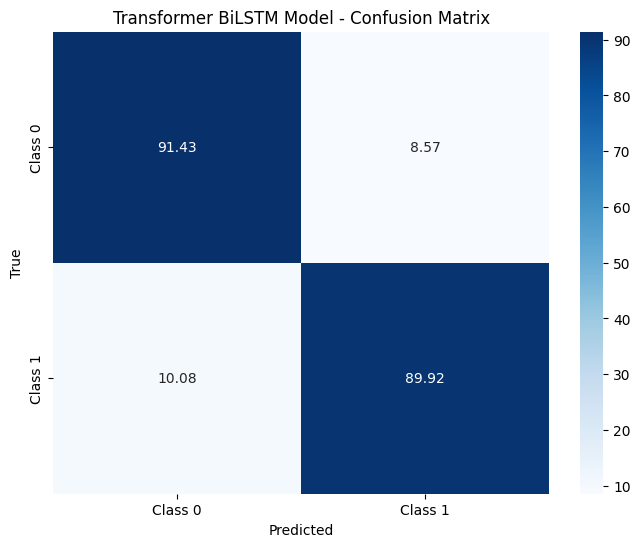

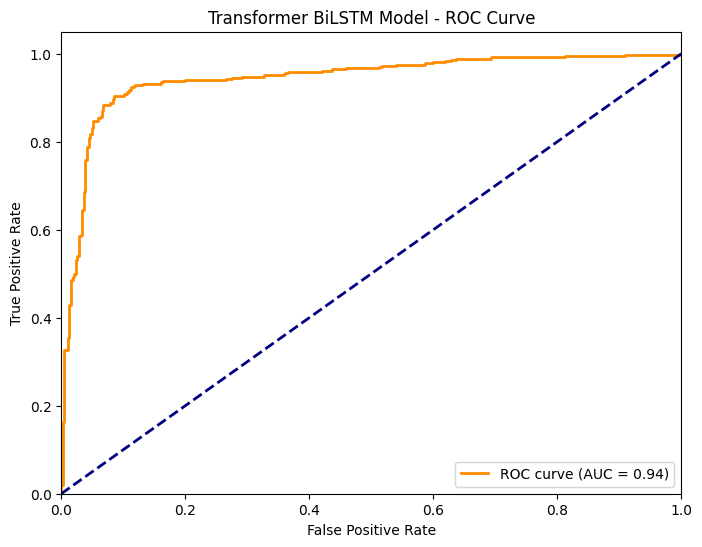

In [ ]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, roc_auc_score, matthews_corrcoef, roc_curve
import seaborn as sns
import matplotlib.pyplot as plt
import os

# تعریف دیتاست سفارشی برای تست
class CustomTestDataset(Dataset):
    def __init__(self, data, labels=None):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if self.labels is not None:
            return torch.tensor(self.data[idx], dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.long)
        else:
            return torch.tensor(self.data[idx], dtype=torch.float32)

# تابع برای بارگذاری داده‌های تست به عنوان DataLoader
def load_test_data_as_dataloader(file_paths, labels=None, batch_size=32):
    data = []
    for file_path in file_paths:
        data.append(np.load(file_path))
    data = np.concatenate(data, axis=0)
    dataset = CustomTestDataset(data, labels)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    return dataloader

# مدل ترنسفورمر با BiLSTM برای تست
class TransformerWithBiLSTM(nn.Module):
    def __init__(self, input_dim, num_classes, num_heads=8, num_layers=2, lstm_hidden_dim=32, dropout_rate=0.3):
        super(TransformerWithBiLSTM, self).__init__()

        # لایه‌های BiLSTM
        self.bilstm = nn.LSTM(input_size=input_dim, hidden_size=lstm_hidden_dim,
                              num_layers=num_layers, batch_first=True, bidirectional=True, dropout=dropout_rate)

        self.attention_layers = nn.ModuleList([nn.MultiheadAttention(embed_dim=lstm_hidden_dim * 2, num_heads=num_heads) for _ in range(num_layers)])

        self.layer_norm = nn.LayerNorm(lstm_hidden_dim * 2)
        self.fc1 = nn.Linear(lstm_hidden_dim * 2, 64)  # کاهش ابعاد لایه خطی
        self.dropout = nn.Dropout(dropout_rate)        # تغییر نرخ Dropout
        self.fc2 = nn.Linear(64, num_classes)          # سازگاری با ابعاد جدید

    def forward(self, x):
        # عبور از لایه BiLSTM
        lstm_out, _ = self.bilstm(x)

        # عبور از لایه‌های ترنسفورمر
        lstm_out = lstm_out.transpose(0, 1)  # برای سازگاری با PyTorch
        for attention in self.attention_layers:
            lstm_out, _ = attention(lstm_out, lstm_out, lstm_out)

        lstm_out = lstm_out.transpose(0, 1)  # بازگشت به شکل اولیه
        lstm_out = self.layer_norm(lstm_out)
        lstm_out = torch.mean(lstm_out, dim=1)  # GlobalAveragePooling
        lstm_out = torch.relu(self.fc1(lstm_out))
        lstm_out = self.dropout(lstm_out)       # اعمال Dropout
        lstm_out = torch.softmax(self.fc2(lstm_out), dim=-1)
        return lstm_out

# تابع تست مدل
def test_transformer_model(test_loader, model_load_path, input_dim=1024, num_classes=2):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = TransformerWithBiLSTM(input_dim=input_dim, num_classes=num_classes)
    model.to(device)

    # بارگذاری مدل ذخیره‌شده
    model.load_state_dict(torch.load(model_load_path, map_location=device))
    model.eval()

    all_predictions = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for data, labels in test_loader:
            data, labels = data.to(device), labels.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(outputs.cpu().numpy()[:, 1])  # احتمال برچسب مثبت

    all_probs = np.array(all_probs)
    return np.array(all_labels), np.array(all_predictions), all_probs

# محاسبه و نمایش معیارهای عملکرد
def calculate_metrics(y_true, y_pred_labels, y_pred_probs):
    cm = confusion_matrix(y_true, y_pred_labels)
    tn, fp, fn, tp = cm.ravel()
    sensitivity = tp / (tp + fn) * 100
    specificity = tn / (tn + fp) * 100
    accuracy = accuracy_score(y_true, y_pred_labels) * 100
    f1 = f1_score(y_true, y_pred_labels) * 100
    mcc = matthews_corrcoef(y_true, y_pred_labels) * 100
    auroc = roc_auc_score(y_true, y_pred_probs) * 100
    print(f"Sensitivity:     {sensitivity:.2f}%")
    print(f"Specificity:     {specificity:.2f}%")
    print(f"Accuracy:        {accuracy:.2f}%")
    print(f"F1 Score:        {f1:.2f}%")
    print(f"MCC:             {mcc:.2f}%")
    print(f"auROC:           {auroc:.2f}%")

# نمایش ماتریس کانفیوژن درصدی و ذخیره تصویر
def display_conf_matrix(y_true, y_pred_labels, title, filename):
    cm = confusion_matrix(y_true, y_pred_labels)
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_percent, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=['Class 0', 'Class 1'],
                yticklabels=['Class 0', 'Class 1'])
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig(filename)
    plt.show()

# رسم نمودار ROC
def plot_roc_curve(y_true, y_pred_probs, title, filename):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_score(y_true, y_pred_probs):.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.savefig(filename)
    plt.show()

# مسیر فایل‌های تست
test_save_paths_X = ['/content/drive/MyDrive/LM-RESULT2/resized_X_TEST.npy']
test_label_csv_path = '/content/drive/MyDrive/LM-RESULT2/y_test_final.csv'

# بارگذاری برچسب‌های تست
y_test = np.loadtxt(test_label_csv_path, delimiter=',', dtype=int)

# آماده‌سازی داده‌ها به عنوان DataLoader برای تست
test_loader = load_test_data_as_dataloader(test_save_paths_X, labels=y_test, batch_size=32)

# مسیر مدل ذخیره شده
model_load_path = '/content/drive/MyDrive/LM-RESULT2/best28_model.pth'

# تست مدل
y_true, y_pred_labels, predicted_probs = test_transformer_model(test_loader, model_load_path)

# محاسبه معیارها
calculate_metrics(y_true, y_pred_labels, predicted_probs)

# ایجاد دایرکتوری برای ذخیره تصاویر در صورت عدم وجود
output_dir = '/content/drive/MyDrive/my_project/LMPred_AMP_Prediction/Figuresfinal'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# نمایش و ذخیره ماتریس کانفیوژن
output_file_cm = os.path.join(output_dir, 'Transformer_BiLSTM3_Model_CM.png')
display_conf_matrix(y_true, y_pred_labels, 'Transformer BiLSTM Model - Confusion Matrix', output_file_cm)

# نمایش و ذخیره نمودار ROC
output_file_roc = os.path.join(output_dir, 'Transformer_BiLSTM3_Model_ROC.png')
plot_roc_curve(y_true, predicted_probs, 'Transformer BiLSTM Model - ROC Curve', output_file_roc)


In [ ]:
0.0005 ir

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt

# تعریف دیتاست سفارشی
class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return torch.tensor(self.data[idx], dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.long)

# تابع برای بارگذاری داده‌ها به عنوان DataLoader
def load_data_as_dataloader(file_paths, labels, batch_size, percentage=1.0):
    data = []
    for file_path in file_paths:
        data.append(np.load(file_path))
    data = np.concatenate(data, axis=0)

    # استفاده از درصدی از داده‌ها
    num_samples = data.shape[0]
    subset_size = int(num_samples * percentage)
    data = data[:subset_size]
    labels = labels[:subset_size]

    dataset = CustomDataset(data, labels)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return dataloader

# مدل ترنسفورمر با لایه‌های BiLSTM در PyTorch
class TransformerWithBiLSTM(nn.Module):
    def __init__(self, input_dim, num_classes, num_heads=8, num_layers=2, lstm_hidden_dim=32, dropout_rate=0.3):
        super(TransformerWithBiLSTM, self).__init__()

        # لایه‌های BiLSTM
        self.bilstm = nn.LSTM(input_size=input_dim, hidden_size=lstm_hidden_dim,
                              num_layers=num_layers, batch_first=True, bidirectional=True, dropout=dropout_rate)

        self.attention_layers = nn.ModuleList([
            nn.MultiheadAttention(embed_dim=lstm_hidden_dim * 2, num_heads=num_heads) for _ in range(num_layers)
        ])

        self.layer_norm = nn.LayerNorm(lstm_hidden_dim * 2)
        self.fc1 = nn.Linear(lstm_hidden_dim * 2, 64)  # کاهش ابعاد لایه خطی
        self.dropout = nn.Dropout(dropout_rate)        # تغییر نرخ Dropout
        self.fc2 = nn.Linear(64, num_classes)          # سازگاری با ابعاد جدید

    def forward(self, x):
        # عبور از لایه BiLSTM
        lstm_out, _ = self.bilstm(x)

        # عبور از لایه‌های ترنسفورمر
        lstm_out = lstm_out.transpose(0, 1)  # برای سازگاری با PyTorch
        for attention in self.attention_layers:
            lstm_out, _ = attention(lstm_out, lstm_out, lstm_out)

        lstm_out = lstm_out.transpose(0, 1)  # بازگشت به شکل اولیه
        lstm_out = self.layer_norm(lstm_out)
        lstm_out = torch.mean(lstm_out, dim=1)  # GlobalAveragePooling
        lstm_out = torch.relu(self.fc1(lstm_out))
        lstm_out = self.dropout(lstm_out)       # اعمال Dropout
        lstm_out = self.fc2(lstm_out)           # عدم نیاز به Softmax چون CrossEntropyLoss آن را خودکار انجام می‌دهد
        return lstm_out

# تابع آموزش مدل
def train_transformer_model(train_loader, val_loader, input_dim, num_classes, model_save_path, plot_save_path, epochs=100, batch_size=32):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # ایجاد مدل و انتقال به GPU
    model = TransformerWithBiLSTM(input_dim=input_dim, num_classes=num_classes)
    model.to(device)

    optimizer = optim.AdamW(model.parameters(), lr=0.0005, weight_decay=1e-4)  # استفاده از AdamW
    criterion = nn.CrossEntropyLoss()

    # تنظیم نرخ یادگیری
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)

    # لیست‌های ذخیره تاریخچه خطا و دقت
    train_loss_history = []
    val_loss_history = []

    best_val_accuracy = 0.0
    early_stopping_counter = 0  # شمارش برای Early Stopping
    patience = 10  # تعداد ایپوک‌ها برای توقف

    # آموزش مدل
    for epoch in range(epochs):
        model.train()
        total_train_loss = 0
        correct_train = 0
        total_train = 0

        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_train += batch_y.size(0)
            correct_train += (predicted == batch_y).sum().item()

        train_accuracy = 100 * correct_train / total_train

        # اعتبارسنجی مدل
        model.eval()
        total_val_loss = 0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for val_X, val_y in val_loader:
                val_X, val_y = val_X.to(device), val_y.to(device)
                outputs = model(val_X)
                loss = criterion(outputs, val_y)
                total_val_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total_val += val_y.size(0)
                correct_val += (predicted == val_y).sum().item()

        val_accuracy = 100 * correct_val / total_val

        train_loss_history.append(total_train_loss / len(train_loader))
        val_loss_history.append(total_val_loss / len(val_loader))

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {total_train_loss / len(train_loader):.4f}, Val Loss: {total_val_loss / len(val_loader):.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Accuracy: {val_accuracy:.2f}%")

        # ذخیره مدل اگر دقت اعتبارسنجی بهبود یافته باشد
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            torch.save(model.state_dict(), model_save_path)
            print(f"New best model saved with Val Accuracy: {val_accuracy:.2f}%")
            early_stopping_counter = 0  # بازنشانی شمارش
        else:
            early_stopping_counter += 1  # افزایش شمارش

        # بروزرسانی نرخ یادگیری
        scheduler.step(total_val_loss)  # به روز رسانی نرخ یادگیری با توجه به ولیدیشن Loss

        # اگر دقت ولیدیشن بهبود نیافت، آموزش متوقف شود
        if early_stopping_counter >= patience:
            print(f"Early stopping triggered after {epoch + 1} epochs.")
            break

    # ذخیره نمودارها
    plt.figure(figsize=(10, 5))
    plt.plot(train_loss_history, label='Train Loss')
    plt.plot(val_loss_history, label='Val Loss')
    plt.title('Model Performance')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(plot_save_path)
    plt.close()
    print(f"Plots saved to {plot_save_path}")

# فراخوانی تابع train_transformer_model

# مسیر فایل‌ها
save_paths_X = [
    '/content/drive/MyDrive/LM-RESULT2/resized_X_TRAIN_batch_1.npy',
    '/content/drive/MyDrive/LM-RESULT2/resized_X_TRAIN_batch_2.npy',
    '/content/drive/MyDrive/LM-RESULT2/resized_X_TRAIN_batch_3.npy',
    '/content/drive/MyDrive/LM-RESULT2/resized_X_TRAIN_batch_4.npy',
    '/content/drive/MyDrive/LM-RESULT2/resized_X_TRAIN_batch_5.npy',
    '/content/drive/MyDrive/LM-RESULT2/resized_X_TRAIN_batch_6.npy'
]
val_save_path_X = '/content/drive/MyDrive/LM-RESULT2/resized_X_val.npy'
val_label_csv_path = '/content/drive/MyDrive/LM-RESULT2/y_val_final.csv'

# بارگذاری برچسب‌ها
train_labels = np.loadtxt('/content/drive/MyDrive/LM-RESULT2/y_train_final.csv', delimiter=',', dtype=int)
val_labels = np.loadtxt(val_label_csv_path, delimiter=',', dtype=int)

# آماده‌سازی داده‌ها به عنوان DataLoader برای 100 درصد داده‌ها
train_loader = load_data_as_dataloader(save_paths_X, train_labels, batch_size=32, percentage=1.0)
val_loader = load_data_as_dataloader([val_save_path_X], val_labels, batch_size=32, percentage=1.0)

# تنظیمات مدل و آموزش با 100 ایپوک
input_dim = 1024  # ابعاد ورودی داده‌ها (باید با داده‌ها سازگار باشد)
num_classes = 2   # تعداد کلاس‌ها (برچسب‌ها)

train_transformer_model(
    train_loader,          # داده‌های آموزشی
    val_loader,            # داده‌های اعتبارسنجی
    input_dim=input_dim,   # ابعاد ورودی
    num_classes=num_classes,  # تعداد کلاس‌ها
    model_save_path='/content/drive/MyDrive/LM-RESULT2/best29_model.pth',  # مسیر ذخیره مدل
    plot_save_path='/content/drive/MyDrive/LM-RESULT2/training29_plot.png',  # مسیر ذخیره نمودار
    epochs=100,            # تعداد ایپوک‌ها
    batch_size=32          # اندازه بچ
)


Epoch 1/100, Train Loss: 0.4756, Val Loss: 0.3381, Train Accuracy: 76.18%, Val Accuracy: 85.83%
New best model saved with Val Accuracy: 85.83%
Epoch 2/100, Train Loss: 0.2902, Val Loss: 0.3150, Train Accuracy: 88.96%, Val Accuracy: 88.09%
New best model saved with Val Accuracy: 88.09%
Epoch 3/100, Train Loss: 0.2495, Val Loss: 0.2976, Train Accuracy: 90.52%, Val Accuracy: 89.16%
New best model saved with Val Accuracy: 89.16%
Epoch 4/100, Train Loss: 0.2012, Val Loss: 0.2773, Train Accuracy: 92.57%, Val Accuracy: 89.62%
New best model saved with Val Accuracy: 89.62%
Epoch 5/100, Train Loss: 0.1807, Val Loss: 0.2609, Train Accuracy: 93.59%, Val Accuracy: 89.62%
Epoch 6/100, Train Loss: 0.1360, Val Loss: 0.3216, Train Accuracy: 95.27%, Val Accuracy: 89.75%
New best model saved with Val Accuracy: 89.75%
Epoch 7/100, Train Loss: 0.1170, Val Loss: 0.4094, Train Accuracy: 96.07%, Val Accuracy: 88.82%
Epoch 8/100, Train Loss: 0.1050, Val Loss: 0.3700, Train Accuracy: 96.35%, Val Accuracy: 89.6

<ipython-input-2-be4013c90f02>:76: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_load_path, map_location=device))


Sensitivity:     91.01%
Specificity:     90.91%
Accuracy:        90.96%
F1 Score:        90.76%
MCC:             81.91%
auROC:           95.00%


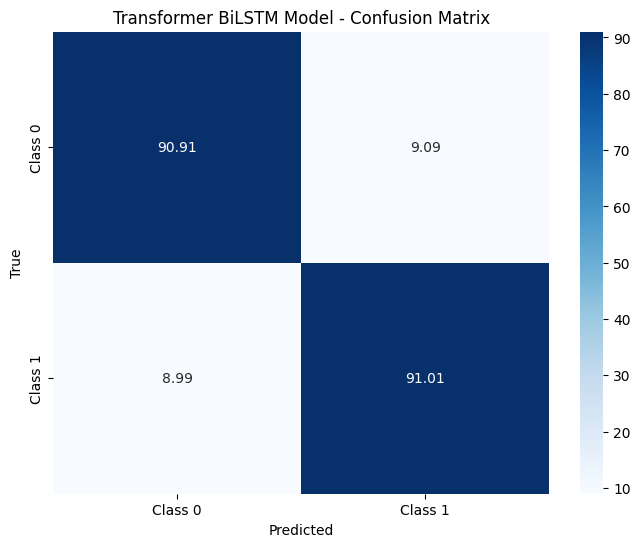

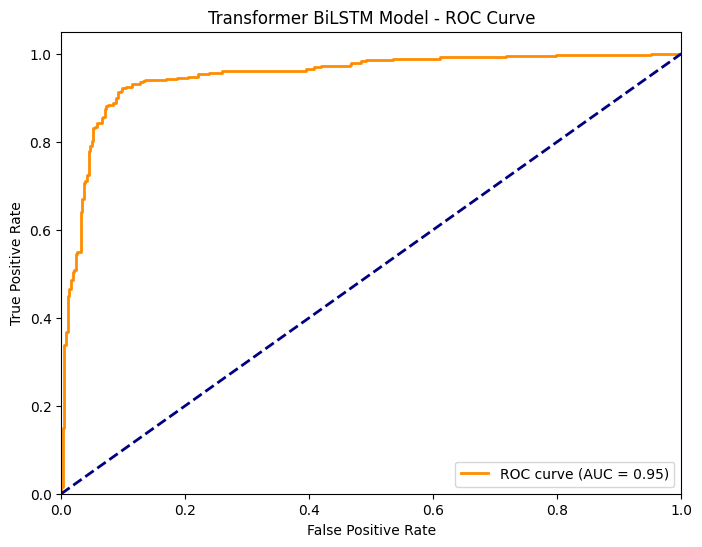

In [ ]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, roc_auc_score, matthews_corrcoef, roc_curve
import seaborn as sns
import matplotlib.pyplot as plt
import os

# تعریف دیتاست سفارشی برای تست
class CustomTestDataset(Dataset):
    def __init__(self, data, labels=None):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if self.labels is not None:
            return torch.tensor(self.data[idx], dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.long)
        else:
            return torch.tensor(self.data[idx], dtype=torch.float32)

# تابع برای بارگذاری داده‌های تست به عنوان DataLoader
def load_test_data_as_dataloader(file_paths, labels=None, batch_size=32):
    data = []
    for file_path in file_paths:
        data.append(np.load(file_path))
    data = np.concatenate(data, axis=0)
    dataset = CustomTestDataset(data, labels)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    return dataloader

# مدل ترنسفورمر با BiLSTM برای تست
class TransformerWithBiLSTM(nn.Module):
    def __init__(self, input_dim, num_classes, num_heads=8, num_layers=2, lstm_hidden_dim=32, dropout_rate=0.3):
        super(TransformerWithBiLSTM, self).__init__()

        # لایه‌های BiLSTM
        self.bilstm = nn.LSTM(input_size=input_dim, hidden_size=lstm_hidden_dim,
                              num_layers=num_layers, batch_first=True, bidirectional=True, dropout=dropout_rate)

        self.attention_layers = nn.ModuleList([nn.MultiheadAttention(embed_dim=lstm_hidden_dim * 2, num_heads=num_heads) for _ in range(num_layers)])

        self.layer_norm = nn.LayerNorm(lstm_hidden_dim * 2)
        self.fc1 = nn.Linear(lstm_hidden_dim * 2, 64)  # کاهش ابعاد لایه خطی
        self.dropout = nn.Dropout(dropout_rate)        # تغییر نرخ Dropout
        self.fc2 = nn.Linear(64, num_classes)          # سازگاری با ابعاد جدید

    def forward(self, x):
        # عبور از لایه BiLSTM
        lstm_out, _ = self.bilstm(x)

        # عبور از لایه‌های ترنسفورمر
        lstm_out = lstm_out.transpose(0, 1)  # برای سازگاری با PyTorch
        for attention in self.attention_layers:
            lstm_out, _ = attention(lstm_out, lstm_out, lstm_out)

        lstm_out = lstm_out.transpose(0, 1)  # بازگشت به شکل اولیه
        lstm_out = self.layer_norm(lstm_out)
        lstm_out = torch.mean(lstm_out, dim=1)  # GlobalAveragePooling
        lstm_out = torch.relu(self.fc1(lstm_out))
        lstm_out = self.dropout(lstm_out)       # اعمال Dropout
        lstm_out = torch.softmax(self.fc2(lstm_out), dim=-1)
        return lstm_out

# تابع تست مدل
def test_transformer_model(test_loader, model_load_path, input_dim=1024, num_classes=2):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = TransformerWithBiLSTM(input_dim=input_dim, num_classes=num_classes)
    model.to(device)

    # بارگذاری مدل ذخیره‌شده
    model.load_state_dict(torch.load(model_load_path, map_location=device))
    model.eval()

    all_predictions = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for data, labels in test_loader:
            data, labels = data.to(device), labels.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(outputs.cpu().numpy()[:, 1])  # احتمال برچسب مثبت

    all_probs = np.array(all_probs)
    return np.array(all_labels), np.array(all_predictions), all_probs

# محاسبه و نمایش معیارهای عملکرد
def calculate_metrics(y_true, y_pred_labels, y_pred_probs):
    cm = confusion_matrix(y_true, y_pred_labels)
    tn, fp, fn, tp = cm.ravel()
    sensitivity = tp / (tp + fn) * 100
    specificity = tn / (tn + fp) * 100
    accuracy = accuracy_score(y_true, y_pred_labels) * 100
    f1 = f1_score(y_true, y_pred_labels) * 100
    mcc = matthews_corrcoef(y_true, y_pred_labels) * 100
    auroc = roc_auc_score(y_true, y_pred_probs) * 100
    print(f"Sensitivity:     {sensitivity:.2f}%")
    print(f"Specificity:     {specificity:.2f}%")
    print(f"Accuracy:        {accuracy:.2f}%")
    print(f"F1 Score:        {f1:.2f}%")
    print(f"MCC:             {mcc:.2f}%")
    print(f"auROC:           {auroc:.2f}%")

# نمایش ماتریس کانفیوژن درصدی و ذخیره تصویر
def display_conf_matrix(y_true, y_pred_labels, title, filename):
    cm = confusion_matrix(y_true, y_pred_labels)
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_percent, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=['Class 0', 'Class 1'],
                yticklabels=['Class 0', 'Class 1'])
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig(filename)
    plt.show()

# رسم نمودار ROC
def plot_roc_curve(y_true, y_pred_probs, title, filename):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_score(y_true, y_pred_probs):.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.savefig(filename)
    plt.show()

# مسیر فایل‌های تست
test_save_paths_X = ['/content/drive/MyDrive/LM-RESULT2/resized_X_TEST.npy']
test_label_csv_path = '/content/drive/MyDrive/LM-RESULT2/y_test_final.csv'

# بارگذاری برچسب‌های تست
y_test = np.loadtxt(test_label_csv_path, delimiter=',', dtype=int)

# آماده‌سازی داده‌ها به عنوان DataLoader برای تست
test_loader = load_test_data_as_dataloader(test_save_paths_X, labels=y_test, batch_size=32)

# مسیر مدل ذخیره شده
model_load_path = '/content/drive/MyDrive/LM-RESULT2/best29_model.pth'

# تست مدل
y_true, y_pred_labels, predicted_probs = test_transformer_model(test_loader, model_load_path)

# محاسبه معیارها
calculate_metrics(y_true, y_pred_labels, predicted_probs)

# ایجاد دایرکتوری برای ذخیره تصاویر در صورت عدم وجود
output_dir = '/content/drive/MyDrive/my_project/LMPred_AMP_Prediction/Figuresfinal'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# نمایش و ذخیره ماتریس کانفیوژن
output_file_cm = os.path.join(output_dir, 'Transformer_BiLSTM3_Model_CM.png')
display_conf_matrix(y_true, y_pred_labels, 'Transformer BiLSTM Model - Confusion Matrix', output_file_cm)

# نمایش و ذخیره نمودار ROC
output_file_roc = os.path.join(output_dir, 'Transformer_BiLSTM3_Model_ROC.png')
plot_roc_curve(y_true, predicted_probs, 'Transformer BiLSTM Model - ROC Curve', output_file_roc)


In [ ]:
num layer 1

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt

# تعریف دیتاست سفارشی
class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return torch.tensor(self.data[idx], dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.long)

# تابع برای بارگذاری داده‌ها به عنوان DataLoader
def load_data_as_dataloader(file_paths, labels, batch_size, percentage=1.0):
    data = []
    for file_path in file_paths:
        data.append(np.load(file_path))
    data = np.concatenate(data, axis=0)

    # استفاده از درصدی از داده‌ها
    num_samples = data.shape[0]
    subset_size = int(num_samples * percentage)
    data = data[:subset_size]
    labels = labels[:subset_size]

    dataset = CustomDataset(data, labels)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return dataloader

# مدل ترنسفورمر با لایه‌های BiLSTM در PyTorch
class TransformerWithBiLSTM(nn.Module):
    def __init__(self, input_dim, num_classes, num_heads=8, num_layers=1, lstm_hidden_dim=32, dropout_rate=0.3):
        super(TransformerWithBiLSTM, self).__init__()

        # لایه‌های BiLSTM
        self.bilstm = nn.LSTM(input_size=input_dim, hidden_size=lstm_hidden_dim,
                              num_layers=num_layers, batch_first=True, bidirectional=True, dropout=dropout_rate)

        self.attention_layers = nn.ModuleList([
            nn.MultiheadAttention(embed_dim=lstm_hidden_dim * 2, num_heads=num_heads) for _ in range(num_layers)
        ])

        self.layer_norm = nn.LayerNorm(lstm_hidden_dim * 2)
        self.fc1 = nn.Linear(lstm_hidden_dim * 2, 64)  # کاهش ابعاد لایه خطی
        self.dropout = nn.Dropout(dropout_rate)        # تغییر نرخ Dropout
        self.fc2 = nn.Linear(64, num_classes)          # سازگاری با ابعاد جدید

    def forward(self, x):
        # عبور از لایه BiLSTM
        lstm_out, _ = self.bilstm(x)

        # عبور از لایه‌های ترنسفورمر
        lstm_out = lstm_out.transpose(0, 1)  # برای سازگاری با PyTorch
        for attention in self.attention_layers:
            lstm_out, _ = attention(lstm_out, lstm_out, lstm_out)

        lstm_out = lstm_out.transpose(0, 1)  # بازگشت به شکل اولیه
        lstm_out = self.layer_norm(lstm_out)
        lstm_out = torch.mean(lstm_out, dim=1)  # GlobalAveragePooling
        lstm_out = torch.relu(self.fc1(lstm_out))
        lstm_out = self.dropout(lstm_out)       # اعمال Dropout
        lstm_out = self.fc2(lstm_out)           # عدم نیاز به Softmax چون CrossEntropyLoss آن را خودکار انجام می‌دهد
        return lstm_out

# تابع آموزش مدل
def train_transformer_model(train_loader, val_loader, input_dim, num_classes, model_save_path, plot_save_path, epochs=100, batch_size=32):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # ایجاد مدل و انتقال به GPU
    model = TransformerWithBiLSTM(input_dim=input_dim, num_classes=num_classes)
    model.to(device)

    optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=1e-4)  # استفاده از AdamW
    criterion = nn.CrossEntropyLoss()

    # تنظیم نرخ یادگیری
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)

    # لیست‌های ذخیره تاریخچه خطا و دقت
    train_loss_history = []
    val_loss_history = []

    best_val_accuracy = 0.0
    early_stopping_counter = 0  # شمارش برای Early Stopping
    patience = 10  # تعداد ایپوک‌ها برای توقف

    # آموزش مدل
    for epoch in range(epochs):
        model.train()
        total_train_loss = 0
        correct_train = 0
        total_train = 0

        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_train += batch_y.size(0)
            correct_train += (predicted == batch_y).sum().item()

        train_accuracy = 100 * correct_train / total_train

        # اعتبارسنجی مدل
        model.eval()
        total_val_loss = 0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for val_X, val_y in val_loader:
                val_X, val_y = val_X.to(device), val_y.to(device)
                outputs = model(val_X)
                loss = criterion(outputs, val_y)
                total_val_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total_val += val_y.size(0)
                correct_val += (predicted == val_y).sum().item()

        val_accuracy = 100 * correct_val / total_val

        train_loss_history.append(total_train_loss / len(train_loader))
        val_loss_history.append(total_val_loss / len(val_loader))

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {total_train_loss / len(train_loader):.4f}, Val Loss: {total_val_loss / len(val_loader):.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Accuracy: {val_accuracy:.2f}%")

        # ذخیره مدل اگر دقت اعتبارسنجی بهبود یافته باشد
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            torch.save(model.state_dict(), model_save_path)
            print(f"New best model saved with Val Accuracy: {val_accuracy:.2f}%")
            early_stopping_counter = 0  # بازنشانی شمارش
        else:
            early_stopping_counter += 1  # افزایش شمارش

        # بروزرسانی نرخ یادگیری
        scheduler.step(total_val_loss)  # به روز رسانی نرخ یادگیری با توجه به ولیدیشن Loss

        # اگر دقت ولیدیشن بهبود نیافت، آموزش متوقف شود
        if early_stopping_counter >= patience:
            print(f"Early stopping triggered after {epoch + 1} epochs.")
            break

    # ذخیره نمودارها
    plt.figure(figsize=(10, 5))
    plt.plot(train_loss_history, label='Train Loss')
    plt.plot(val_loss_history, label='Val Loss')
    plt.title('Model Performance')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(plot_save_path)
    plt.close()
    print(f"Plots saved to {plot_save_path}")

# فراخوانی تابع train_transformer_model

# مسیر فایل‌ها
save_paths_X = [
    '/content/drive/MyDrive/LM-RESULT2/resized_X_TRAIN_batch_1.npy',
    '/content/drive/MyDrive/LM-RESULT2/resized_X_TRAIN_batch_2.npy',
    '/content/drive/MyDrive/LM-RESULT2/resized_X_TRAIN_batch_3.npy',
    '/content/drive/MyDrive/LM-RESULT2/resized_X_TRAIN_batch_4.npy',
    '/content/drive/MyDrive/LM-RESULT2/resized_X_TRAIN_batch_5.npy',
    '/content/drive/MyDrive/LM-RESULT2/resized_X_TRAIN_batch_6.npy'
]
val_save_path_X = '/content/drive/MyDrive/LM-RESULT2/resized_X_val.npy'
val_label_csv_path = '/content/drive/MyDrive/LM-RESULT2/y_val_final.csv'

# بارگذاری برچسب‌ها
train_labels = np.loadtxt('/content/drive/MyDrive/LM-RESULT2/y_train_final.csv', delimiter=',', dtype=int)
val_labels = np.loadtxt(val_label_csv_path, delimiter=',', dtype=int)

# آماده‌سازی داده‌ها به عنوان DataLoader برای 100 درصد داده‌ها
train_loader = load_data_as_dataloader(save_paths_X, train_labels, batch_size=32, percentage=1.0)
val_loader = load_data_as_dataloader([val_save_path_X], val_labels, batch_size=32, percentage=1.0)

# تنظیمات مدل و آموزش با 100 ایپوک
input_dim = 1024  # ابعاد ورودی داده‌ها (باید با داده‌ها سازگار باشد)
num_classes = 2   # تعداد کلاس‌ها (برچسب‌ها)

train_transformer_model(
    train_loader,          # داده‌های آموزشی
    val_loader,            # داده‌های اعتبارسنجی
    input_dim=input_dim,   # ابعاد ورودی
    num_classes=num_classes,  # تعداد کلاس‌ها
    model_save_path='/content/drive/MyDrive/LM-RESULT2/best30_model.pth',  # مسیر ذخیره مدل
    plot_save_path='/content/drive/MyDrive/LM-RESULT2/training30_plot.png',  # مسیر ذخیره نمودار
    epochs=100,            # تعداد ایپوک‌ها
    batch_size=32          # اندازه بچ
)


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Epoch 1/100, Train Loss: 0.5973, Val Loss: 0.4418, Train Accuracy: 68.54%, Val Accuracy: 80.97%
New best model saved with Val Accuracy: 80.97%
Epoch 2/100, Train Loss: 0.3670, Val Loss: 0.3546, Train Accuracy: 85.04%, Val Accuracy: 85.16%
New best model saved with Val Accuracy: 85.16%
Epoch 3/100, Train Loss: 0.3088, Val Loss: 0.3213, Train Accuracy: 87.15%, Val Accuracy: 87.36%
New best model saved with Val Accuracy: 87.36%
Epoch 4/100, Train Loss: 0.2767, Val Loss: 0.3092, Train Accuracy: 88.99%, Val Accuracy: 87.76%
New best model saved with Val Accuracy: 87.76%
Epoch 5/100, Train Loss: 0.2578, Val Loss: 0.2995, Train Accuracy: 89.83%, Val Accuracy: 88.69%
New best model saved with Val Accuracy: 88.69%
Epoch 6/100, Train Loss: 0.2391, Val Loss: 0.2933, Train Accuracy: 90.86%, Val Accuracy: 89.35%
New best model saved with Val Accuracy: 89.35%
Epoch 7/100, Train Loss: 0.2207, Val Loss: 0.2937, Train Accuracy: 91.54%, Val Accuracy: 88.89%
Epoch 8/100, Train Loss: 0.2099, Val Loss: 0.2

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(
<ipython-input-2-bdcff341b80d>:76: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=

Sensitivity:     88.01%
Specificity:     90.39%
Accuracy:        89.23%
F1 Score:        88.86%
MCC:             78.45%
auROC:           95.19%


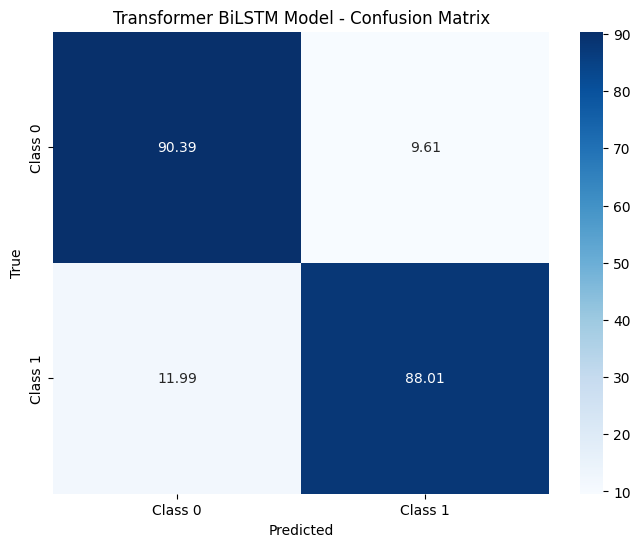

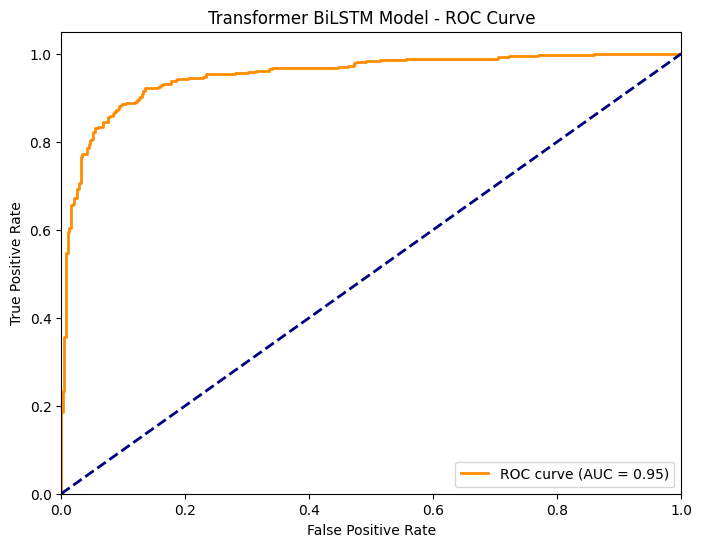

In [ ]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, roc_auc_score, matthews_corrcoef, roc_curve
import seaborn as sns
import matplotlib.pyplot as plt
import os

# تعریف دیتاست سفارشی برای تست
class CustomTestDataset(Dataset):
    def __init__(self, data, labels=None):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if self.labels is not None:
            return torch.tensor(self.data[idx], dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.long)
        else:
            return torch.tensor(self.data[idx], dtype=torch.float32)

# تابع برای بارگذاری داده‌های تست به عنوان DataLoader
def load_test_data_as_dataloader(file_paths, labels=None, batch_size=32):
    data = []
    for file_path in file_paths:
        data.append(np.load(file_path))
    data = np.concatenate(data, axis=0)
    dataset = CustomTestDataset(data, labels)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    return dataloader

# مدل ترنسفورمر با BiLSTM برای تست
class TransformerWithBiLSTM(nn.Module):
    def __init__(self, input_dim, num_classes, num_heads=8, num_layers=1, lstm_hidden_dim=32, dropout_rate=0.3):
        super(TransformerWithBiLSTM, self).__init__()

        # لایه‌های BiLSTM
        self.bilstm = nn.LSTM(input_size=input_dim, hidden_size=lstm_hidden_dim,
                              num_layers=num_layers, batch_first=True, bidirectional=True, dropout=dropout_rate)

        self.attention_layers = nn.ModuleList([nn.MultiheadAttention(embed_dim=lstm_hidden_dim * 2, num_heads=num_heads) for _ in range(num_layers)])

        self.layer_norm = nn.LayerNorm(lstm_hidden_dim * 2)
        self.fc1 = nn.Linear(lstm_hidden_dim * 2, 64)  # کاهش ابعاد لایه خطی
        self.dropout = nn.Dropout(dropout_rate)        # تغییر نرخ Dropout
        self.fc2 = nn.Linear(64, num_classes)          # سازگاری با ابعاد جدید

    def forward(self, x):
        # عبور از لایه BiLSTM
        lstm_out, _ = self.bilstm(x)

        # عبور از لایه‌های ترنسفورمر
        lstm_out = lstm_out.transpose(0, 1)  # برای سازگاری با PyTorch
        for attention in self.attention_layers:
            lstm_out, _ = attention(lstm_out, lstm_out, lstm_out)

        lstm_out = lstm_out.transpose(0, 1)  # بازگشت به شکل اولیه
        lstm_out = self.layer_norm(lstm_out)
        lstm_out = torch.mean(lstm_out, dim=1)  # GlobalAveragePooling
        lstm_out = torch.relu(self.fc1(lstm_out))
        lstm_out = self.dropout(lstm_out)       # اعمال Dropout
        lstm_out = torch.softmax(self.fc2(lstm_out), dim=-1)
        return lstm_out

# تابع تست مدل
def test_transformer_model(test_loader, model_load_path, input_dim=1024, num_classes=2):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = TransformerWithBiLSTM(input_dim=input_dim, num_classes=num_classes)
    model.to(device)

    # بارگذاری مدل ذخیره‌شده
    model.load_state_dict(torch.load(model_load_path, map_location=device))
    model.eval()

    all_predictions = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for data, labels in test_loader:
            data, labels = data.to(device), labels.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(outputs.cpu().numpy()[:, 1])  # احتمال برچسب مثبت

    all_probs = np.array(all_probs)
    return np.array(all_labels), np.array(all_predictions), all_probs

# محاسبه و نمایش معیارهای عملکرد
def calculate_metrics(y_true, y_pred_labels, y_pred_probs):
    cm = confusion_matrix(y_true, y_pred_labels)
    tn, fp, fn, tp = cm.ravel()
    sensitivity = tp / (tp + fn) * 100
    specificity = tn / (tn + fp) * 100
    accuracy = accuracy_score(y_true, y_pred_labels) * 100
    f1 = f1_score(y_true, y_pred_labels) * 100
    mcc = matthews_corrcoef(y_true, y_pred_labels) * 100
    auroc = roc_auc_score(y_true, y_pred_probs) * 100
    print(f"Sensitivity:     {sensitivity:.2f}%")
    print(f"Specificity:     {specificity:.2f}%")
    print(f"Accuracy:        {accuracy:.2f}%")
    print(f"F1 Score:        {f1:.2f}%")
    print(f"MCC:             {mcc:.2f}%")
    print(f"auROC:           {auroc:.2f}%")

# نمایش ماتریس کانفیوژن درصدی و ذخیره تصویر
def display_conf_matrix(y_true, y_pred_labels, title, filename):
    cm = confusion_matrix(y_true, y_pred_labels)
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_percent, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=['Class 0', 'Class 1'],
                yticklabels=['Class 0', 'Class 1'])
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig(filename)
    plt.show()

# رسم نمودار ROC
def plot_roc_curve(y_true, y_pred_probs, title, filename):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_score(y_true, y_pred_probs):.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.savefig(filename)
    plt.show()

# مسیر فایل‌های تست
test_save_paths_X = ['/content/drive/MyDrive/LM-RESULT2/resized_X_TEST.npy']
test_label_csv_path = '/content/drive/MyDrive/LM-RESULT2/y_test_final.csv'

# بارگذاری برچسب‌های تست
y_test = np.loadtxt(test_label_csv_path, delimiter=',', dtype=int)

# آماده‌سازی داده‌ها به عنوان DataLoader برای تست
test_loader = load_test_data_as_dataloader(test_save_paths_X, labels=y_test, batch_size=32)

# مسیر مدل ذخیره شده
model_load_path = '/content/drive/MyDrive/LM-RESULT2/best30_model.pth'

# تست مدل
y_true, y_pred_labels, predicted_probs = test_transformer_model(test_loader, model_load_path)

# محاسبه معیارها
calculate_metrics(y_true, y_pred_labels, predicted_probs)

# ایجاد دایرکتوری برای ذخیره تصاویر در صورت عدم وجود
output_dir = '/content/drive/MyDrive/my_project/LMPred_AMP_Prediction/Figuresfinal'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# نمایش و ذخیره ماتریس کانفیوژن
output_file_cm = os.path.join(output_dir, 'Transformer_BiLSTM3_Model_CM.png')
display_conf_matrix(y_true, y_pred_labels, 'Transformer BiLSTM Model - Confusion Matrix', output_file_cm)

# نمایش و ذخیره نمودار ROC
output_file_roc = os.path.join(output_dir, 'Transformer_BiLSTM3_Model_ROC.png')
plot_roc_curve(y_true, predicted_probs, 'Transformer BiLSTM Model - ROC Curve', output_file_roc)


In [ ]:
num layer 3

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt

# تعریف دیتاست سفارشی
class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return torch.tensor(self.data[idx], dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.long)

# تابع برای بارگذاری داده‌ها به عنوان DataLoader
def load_data_as_dataloader(file_paths, labels, batch_size, percentage=1.0):
    data = []
    for file_path in file_paths:
        data.append(np.load(file_path))
    data = np.concatenate(data, axis=0)

    # استفاده از درصدی از داده‌ها
    num_samples = data.shape[0]
    subset_size = int(num_samples * percentage)
    data = data[:subset_size]
    labels = labels[:subset_size]

    dataset = CustomDataset(data, labels)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return dataloader

# مدل ترنسفورمر با لایه‌های BiLSTM در PyTorch
class TransformerWithBiLSTM(nn.Module):
    def __init__(self, input_dim, num_classes, num_heads=8, num_layers=3, lstm_hidden_dim=32, dropout_rate=0.3):
        super(TransformerWithBiLSTM, self).__init__()

        # لایه‌های BiLSTM
        self.bilstm = nn.LSTM(input_size=input_dim, hidden_size=lstm_hidden_dim,
                              num_layers=num_layers, batch_first=True, bidirectional=True, dropout=dropout_rate)

        self.attention_layers = nn.ModuleList([
            nn.MultiheadAttention(embed_dim=lstm_hidden_dim * 2, num_heads=num_heads) for _ in range(num_layers)
        ])

        self.layer_norm = nn.LayerNorm(lstm_hidden_dim * 2)
        self.fc1 = nn.Linear(lstm_hidden_dim * 2, 64)  # کاهش ابعاد لایه خطی
        self.dropout = nn.Dropout(dropout_rate)        # تغییر نرخ Dropout
        self.fc2 = nn.Linear(64, num_classes)          # سازگاری با ابعاد جدید

    def forward(self, x):
        # عبور از لایه BiLSTM
        lstm_out, _ = self.bilstm(x)

        # عبور از لایه‌های ترنسفورمر
        lstm_out = lstm_out.transpose(0, 1)  # برای سازگاری با PyTorch
        for attention in self.attention_layers:
            lstm_out, _ = attention(lstm_out, lstm_out, lstm_out)

        lstm_out = lstm_out.transpose(0, 1)  # بازگشت به شکل اولیه
        lstm_out = self.layer_norm(lstm_out)
        lstm_out = torch.mean(lstm_out, dim=1)  # GlobalAveragePooling
        lstm_out = torch.relu(self.fc1(lstm_out))
        lstm_out = self.dropout(lstm_out)       # اعمال Dropout
        lstm_out = self.fc2(lstm_out)           # عدم نیاز به Softmax چون CrossEntropyLoss آن را خودکار انجام می‌دهد
        return lstm_out

# تابع آموزش مدل
def train_transformer_model(train_loader, val_loader, input_dim, num_classes, model_save_path, plot_save_path, epochs=100, batch_size=32):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # ایجاد مدل و انتقال به GPU
    model = TransformerWithBiLSTM(input_dim=input_dim, num_classes=num_classes)
    model.to(device)

    optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=1e-4)  # استفاده از AdamW
    criterion = nn.CrossEntropyLoss()

    # تنظیم نرخ یادگیری
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)

    # لیست‌های ذخیره تاریخچه خطا و دقت
    train_loss_history = []
    val_loss_history = []

    best_val_accuracy = 0.0
    early_stopping_counter = 0  # شمارش برای Early Stopping
    patience = 10  # تعداد ایپوک‌ها برای توقف

    # آموزش مدل
    for epoch in range(epochs):
        model.train()
        total_train_loss = 0
        correct_train = 0
        total_train = 0

        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_train += batch_y.size(0)
            correct_train += (predicted == batch_y).sum().item()

        train_accuracy = 100 * correct_train / total_train

        # اعتبارسنجی مدل
        model.eval()
        total_val_loss = 0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for val_X, val_y in val_loader:
                val_X, val_y = val_X.to(device), val_y.to(device)
                outputs = model(val_X)
                loss = criterion(outputs, val_y)
                total_val_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total_val += val_y.size(0)
                correct_val += (predicted == val_y).sum().item()

        val_accuracy = 100 * correct_val / total_val

        train_loss_history.append(total_train_loss / len(train_loader))
        val_loss_history.append(total_val_loss / len(val_loader))

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {total_train_loss / len(train_loader):.4f}, Val Loss: {total_val_loss / len(val_loader):.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Accuracy: {val_accuracy:.2f}%")

        # ذخیره مدل اگر دقت اعتبارسنجی بهبود یافته باشد
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            torch.save(model.state_dict(), model_save_path)
            print(f"New best model saved with Val Accuracy: {val_accuracy:.2f}%")
            early_stopping_counter = 0  # بازنشانی شمارش
        else:
            early_stopping_counter += 1  # افزایش شمارش

        # بروزرسانی نرخ یادگیری
        scheduler.step(total_val_loss)  # به روز رسانی نرخ یادگیری با توجه به ولیدیشن Loss

        # اگر دقت ولیدیشن بهبود نیافت، آموزش متوقف شود
        if early_stopping_counter >= patience:
            print(f"Early stopping triggered after {epoch + 1} epochs.")
            break

    # ذخیره نمودارها
    plt.figure(figsize=(10, 5))
    plt.plot(train_loss_history, label='Train Loss')
    plt.plot(val_loss_history, label='Val Loss')
    plt.title('Model Performance')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(plot_save_path)
    plt.close()
    print(f"Plots saved to {plot_save_path}")

# فراخوانی تابع train_transformer_model

# مسیر فایل‌ها
save_paths_X = [
    '/content/drive/MyDrive/LM-RESULT2/resized_X_TRAIN_batch_1.npy',
    '/content/drive/MyDrive/LM-RESULT2/resized_X_TRAIN_batch_2.npy',
    '/content/drive/MyDrive/LM-RESULT2/resized_X_TRAIN_batch_3.npy',
    '/content/drive/MyDrive/LM-RESULT2/resized_X_TRAIN_batch_4.npy',
    '/content/drive/MyDrive/LM-RESULT2/resized_X_TRAIN_batch_5.npy',
    '/content/drive/MyDrive/LM-RESULT2/resized_X_TRAIN_batch_6.npy'
]
val_save_path_X = '/content/drive/MyDrive/LM-RESULT2/resized_X_val.npy'
val_label_csv_path = '/content/drive/MyDrive/LM-RESULT2/y_val_final.csv'

# بارگذاری برچسب‌ها
train_labels = np.loadtxt('/content/drive/MyDrive/LM-RESULT2/y_train_final.csv', delimiter=',', dtype=int)
val_labels = np.loadtxt(val_label_csv_path, delimiter=',', dtype=int)

# آماده‌سازی داده‌ها به عنوان DataLoader برای 100 درصد داده‌ها
train_loader = load_data_as_dataloader(save_paths_X, train_labels, batch_size=32, percentage=1.0)
val_loader = load_data_as_dataloader([val_save_path_X], val_labels, batch_size=32, percentage=1.0)

# تنظیمات مدل و آموزش با 100 ایپوک
input_dim = 1024  # ابعاد ورودی داده‌ها (باید با داده‌ها سازگار باشد)
num_classes = 2   # تعداد کلاس‌ها (برچسب‌ها)

train_transformer_model(
    train_loader,          # داده‌های آموزشی
    val_loader,            # داده‌های اعتبارسنجی
    input_dim=input_dim,   # ابعاد ورودی
    num_classes=num_classes,  # تعداد کلاس‌ها
    model_save_path='/content/drive/MyDrive/LM-RESULT2/best31_model.pth',  # مسیر ذخیره مدل
    plot_save_path='/content/drive/MyDrive/LM-RESULT2/training31_plot.png',  # مسیر ذخیره نمودار
    epochs=100,            # تعداد ایپوک‌ها
    batch_size=32          # اندازه بچ
)


Epoch 1/100, Train Loss: 0.6711, Val Loss: 0.5487, Train Accuracy: 56.17%, Val Accuracy: 74.85%
New best model saved with Val Accuracy: 74.85%
Epoch 2/100, Train Loss: 0.4089, Val Loss: 0.3784, Train Accuracy: 83.65%, Val Accuracy: 85.16%
New best model saved with Val Accuracy: 85.16%
Epoch 3/100, Train Loss: 0.3392, Val Loss: 0.3616, Train Accuracy: 87.19%, Val Accuracy: 85.89%
New best model saved with Val Accuracy: 85.89%
Epoch 4/100, Train Loss: 0.3168, Val Loss: 0.3410, Train Accuracy: 88.44%, Val Accuracy: 87.16%
New best model saved with Val Accuracy: 87.16%
Epoch 5/100, Train Loss: 0.2919, Val Loss: 0.3247, Train Accuracy: 88.88%, Val Accuracy: 87.69%
New best model saved with Val Accuracy: 87.69%
Epoch 6/100, Train Loss: 0.2763, Val Loss: 0.3683, Train Accuracy: 90.13%, Val Accuracy: 85.50%
Epoch 7/100, Train Loss: 0.2618, Val Loss: 0.3387, Train Accuracy: 90.78%, Val Accuracy: 86.56%
Epoch 8/100, Train Loss: 0.2502, Val Loss: 0.3053, Train Accuracy: 91.16%, Val Accuracy: 89.0

<ipython-input-2-8e8d0c1c1ba9>:76: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_load_path, map_location=device))


Sensitivity:     89.92%
Specificity:     87.53%
Accuracy:        88.70%
F1 Score:        88.59%
MCC:             77.43%
auROC:           94.87%


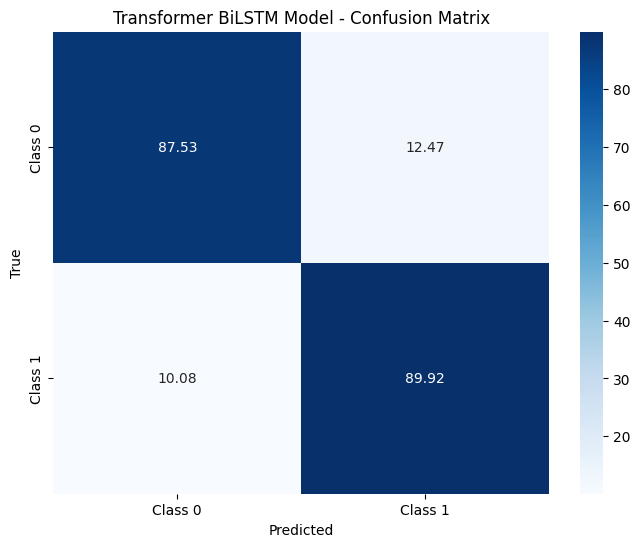

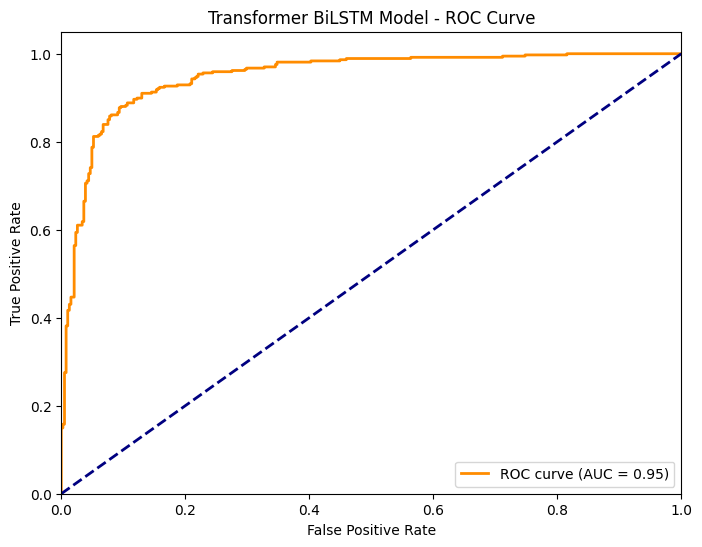

In [ ]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, roc_auc_score, matthews_corrcoef, roc_curve
import seaborn as sns
import matplotlib.pyplot as plt
import os

# تعریف دیتاست سفارشی برای تست
class CustomTestDataset(Dataset):
    def __init__(self, data, labels=None):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if self.labels is not None:
            return torch.tensor(self.data[idx], dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.long)
        else:
            return torch.tensor(self.data[idx], dtype=torch.float32)

# تابع برای بارگذاری داده‌های تست به عنوان DataLoader
def load_test_data_as_dataloader(file_paths, labels=None, batch_size=32):
    data = []
    for file_path in file_paths:
        data.append(np.load(file_path))
    data = np.concatenate(data, axis=0)
    dataset = CustomTestDataset(data, labels)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    return dataloader

# مدل ترنسفورمر با BiLSTM برای تست
class TransformerWithBiLSTM(nn.Module):
    def __init__(self, input_dim, num_classes, num_heads=8, num_layers=3, lstm_hidden_dim=32, dropout_rate=0.3):
        super(TransformerWithBiLSTM, self).__init__()

        # لایه‌های BiLSTM
        self.bilstm = nn.LSTM(input_size=input_dim, hidden_size=lstm_hidden_dim,
                              num_layers=num_layers, batch_first=True, bidirectional=True, dropout=dropout_rate)

        self.attention_layers = nn.ModuleList([nn.MultiheadAttention(embed_dim=lstm_hidden_dim * 2, num_heads=num_heads) for _ in range(num_layers)])

        self.layer_norm = nn.LayerNorm(lstm_hidden_dim * 2)
        self.fc1 = nn.Linear(lstm_hidden_dim * 2, 64)  # کاهش ابعاد لایه خطی
        self.dropout = nn.Dropout(dropout_rate)        # تغییر نرخ Dropout
        self.fc2 = nn.Linear(64, num_classes)          # سازگاری با ابعاد جدید

    def forward(self, x):
        # عبور از لایه BiLSTM
        lstm_out, _ = self.bilstm(x)

        # عبور از لایه‌های ترنسفورمر
        lstm_out = lstm_out.transpose(0, 1)  # برای سازگاری با PyTorch
        for attention in self.attention_layers:
            lstm_out, _ = attention(lstm_out, lstm_out, lstm_out)

        lstm_out = lstm_out.transpose(0, 1)  # بازگشت به شکل اولیه
        lstm_out = self.layer_norm(lstm_out)
        lstm_out = torch.mean(lstm_out, dim=1)  # GlobalAveragePooling
        lstm_out = torch.relu(self.fc1(lstm_out))
        lstm_out = self.dropout(lstm_out)       # اعمال Dropout
        lstm_out = torch.softmax(self.fc2(lstm_out), dim=-1)
        return lstm_out

# تابع تست مدل
def test_transformer_model(test_loader, model_load_path, input_dim=1024, num_classes=2):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = TransformerWithBiLSTM(input_dim=input_dim, num_classes=num_classes)
    model.to(device)

    # بارگذاری مدل ذخیره‌شده
    model.load_state_dict(torch.load(model_load_path, map_location=device))
    model.eval()

    all_predictions = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for data, labels in test_loader:
            data, labels = data.to(device), labels.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(outputs.cpu().numpy()[:, 1])  # احتمال برچسب مثبت

    all_probs = np.array(all_probs)
    return np.array(all_labels), np.array(all_predictions), all_probs

# محاسبه و نمایش معیارهای عملکرد
def calculate_metrics(y_true, y_pred_labels, y_pred_probs):
    cm = confusion_matrix(y_true, y_pred_labels)
    tn, fp, fn, tp = cm.ravel()
    sensitivity = tp / (tp + fn) * 100
    specificity = tn / (tn + fp) * 100
    accuracy = accuracy_score(y_true, y_pred_labels) * 100
    f1 = f1_score(y_true, y_pred_labels) * 100
    mcc = matthews_corrcoef(y_true, y_pred_labels) * 100
    auroc = roc_auc_score(y_true, y_pred_probs) * 100
    print(f"Sensitivity:     {sensitivity:.2f}%")
    print(f"Specificity:     {specificity:.2f}%")
    print(f"Accuracy:        {accuracy:.2f}%")
    print(f"F1 Score:        {f1:.2f}%")
    print(f"MCC:             {mcc:.2f}%")
    print(f"auROC:           {auroc:.2f}%")

# نمایش ماتریس کانفیوژن درصدی و ذخیره تصویر
def display_conf_matrix(y_true, y_pred_labels, title, filename):
    cm = confusion_matrix(y_true, y_pred_labels)
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_percent, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=['Class 0', 'Class 1'],
                yticklabels=['Class 0', 'Class 1'])
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig(filename)
    plt.show()

# رسم نمودار ROC
def plot_roc_curve(y_true, y_pred_probs, title, filename):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_score(y_true, y_pred_probs):.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.savefig(filename)
    plt.show()

# مسیر فایل‌های تست
test_save_paths_X = ['/content/drive/MyDrive/LM-RESULT2/resized_X_TEST.npy']
test_label_csv_path = '/content/drive/MyDrive/LM-RESULT2/y_test_final.csv'

# بارگذاری برچسب‌های تست
y_test = np.loadtxt(test_label_csv_path, delimiter=',', dtype=int)

# آماده‌سازی داده‌ها به عنوان DataLoader برای تست
test_loader = load_test_data_as_dataloader(test_save_paths_X, labels=y_test, batch_size=32)

# مسیر مدل ذخیره شده
model_load_path = '/content/drive/MyDrive/LM-RESULT2/best31_model.pth'

# تست مدل
y_true, y_pred_labels, predicted_probs = test_transformer_model(test_loader, model_load_path)

# محاسبه معیارها
calculate_metrics(y_true, y_pred_labels, predicted_probs)

# ایجاد دایرکتوری برای ذخیره تصاویر در صورت عدم وجود
output_dir = '/content/drive/MyDrive/my_project/LMPred_AMP_Prediction/Figuresfinal'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# نمایش و ذخیره ماتریس کانفیوژن
output_file_cm = os.path.join(output_dir, 'Transformer_BiLSTM3_Model_CM.png')
display_conf_matrix(y_true, y_pred_labels, 'Transformer BiLSTM Model - Confusion Matrix', output_file_cm)

# نمایش و ذخیره نمودار ROC
output_file_roc = os.path.join(output_dir, 'Transformer_BiLSTM3_Model_ROC.png')
plot_roc_curve(y_true, predicted_probs, 'Transformer BiLSTM Model - ROC Curve', output_file_roc)


In [ ]:
num layer 5

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt

# تعریف دیتاست سفارشی
class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return torch.tensor(self.data[idx], dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.long)

# تابع برای بارگذاری داده‌ها به عنوان DataLoader
def load_data_as_dataloader(file_paths, labels, batch_size, percentage=1.0):
    data = []
    for file_path in file_paths:
        data.append(np.load(file_path))
    data = np.concatenate(data, axis=0)

    # استفاده از درصدی از داده‌ها
    num_samples = data.shape[0]
    subset_size = int(num_samples * percentage)
    data = data[:subset_size]
    labels = labels[:subset_size]

    dataset = CustomDataset(data, labels)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return dataloader

# مدل ترنسفورمر با لایه‌های BiLSTM در PyTorch
class TransformerWithBiLSTM(nn.Module):
    def __init__(self, input_dim, num_classes, num_heads=8, num_layers=5, lstm_hidden_dim=32, dropout_rate=0.3):
        super(TransformerWithBiLSTM, self).__init__()

        # لایه‌های BiLSTM
        self.bilstm = nn.LSTM(input_size=input_dim, hidden_size=lstm_hidden_dim,
                              num_layers=num_layers, batch_first=True, bidirectional=True, dropout=dropout_rate)

        self.attention_layers = nn.ModuleList([
            nn.MultiheadAttention(embed_dim=lstm_hidden_dim * 2, num_heads=num_heads) for _ in range(num_layers)
        ])

        self.layer_norm = nn.LayerNorm(lstm_hidden_dim * 2)
        self.fc1 = nn.Linear(lstm_hidden_dim * 2, 64)  # کاهش ابعاد لایه خطی
        self.dropout = nn.Dropout(dropout_rate)        # تغییر نرخ Dropout
        self.fc2 = nn.Linear(64, num_classes)          # سازگاری با ابعاد جدید

    def forward(self, x):
        # عبور از لایه BiLSTM
        lstm_out, _ = self.bilstm(x)

        # عبور از لایه‌های ترنسفورمر
        lstm_out = lstm_out.transpose(0, 1)  # برای سازگاری با PyTorch
        for attention in self.attention_layers:
            lstm_out, _ = attention(lstm_out, lstm_out, lstm_out)

        lstm_out = lstm_out.transpose(0, 1)  # بازگشت به شکل اولیه
        lstm_out = self.layer_norm(lstm_out)
        lstm_out = torch.mean(lstm_out, dim=1)  # GlobalAveragePooling
        lstm_out = torch.relu(self.fc1(lstm_out))
        lstm_out = self.dropout(lstm_out)       # اعمال Dropout
        lstm_out = self.fc2(lstm_out)           # عدم نیاز به Softmax چون CrossEntropyLoss آن را خودکار انجام می‌دهد
        return lstm_out

# تابع آموزش مدل
def train_transformer_model(train_loader, val_loader, input_dim, num_classes, model_save_path, plot_save_path, epochs=100, batch_size=32):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # ایجاد مدل و انتقال به GPU
    model = TransformerWithBiLSTM(input_dim=input_dim, num_classes=num_classes)
    model.to(device)

    optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=1e-4)  # استفاده از AdamW
    criterion = nn.CrossEntropyLoss()

    # تنظیم نرخ یادگیری
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)

    # لیست‌های ذخیره تاریخچه خطا و دقت
    train_loss_history = []
    val_loss_history = []

    best_val_accuracy = 0.0
    early_stopping_counter = 0  # شمارش برای Early Stopping
    patience = 10  # تعداد ایپوک‌ها برای توقف

    # آموزش مدل
    for epoch in range(epochs):
        model.train()
        total_train_loss = 0
        correct_train = 0
        total_train = 0

        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_train += batch_y.size(0)
            correct_train += (predicted == batch_y).sum().item()

        train_accuracy = 100 * correct_train / total_train

        # اعتبارسنجی مدل
        model.eval()
        total_val_loss = 0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for val_X, val_y in val_loader:
                val_X, val_y = val_X.to(device), val_y.to(device)
                outputs = model(val_X)
                loss = criterion(outputs, val_y)
                total_val_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total_val += val_y.size(0)
                correct_val += (predicted == val_y).sum().item()

        val_accuracy = 100 * correct_val / total_val

        train_loss_history.append(total_train_loss / len(train_loader))
        val_loss_history.append(total_val_loss / len(val_loader))

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {total_train_loss / len(train_loader):.4f}, Val Loss: {total_val_loss / len(val_loader):.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Accuracy: {val_accuracy:.2f}%")

        # ذخیره مدل اگر دقت اعتبارسنجی بهبود یافته باشد
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            torch.save(model.state_dict(), model_save_path)
            print(f"New best model saved with Val Accuracy: {val_accuracy:.2f}%")
            early_stopping_counter = 0  # بازنشانی شمارش
        else:
            early_stopping_counter += 1  # افزایش شمارش

        # بروزرسانی نرخ یادگیری
        scheduler.step(total_val_loss)  # به روز رسانی نرخ یادگیری با توجه به ولیدیشن Loss

        # اگر دقت ولیدیشن بهبود نیافت، آموزش متوقف شود
        if early_stopping_counter >= patience:
            print(f"Early stopping triggered after {epoch + 1} epochs.")
            break

    # ذخیره نمودارها
    plt.figure(figsize=(10, 5))
    plt.plot(train_loss_history, label='Train Loss')
    plt.plot(val_loss_history, label='Val Loss')
    plt.title('Model Performance')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(plot_save_path)
    plt.close()
    print(f"Plots saved to {plot_save_path}")

# فراخوانی تابع train_transformer_model

# مسیر فایل‌ها
save_paths_X = [
    '/content/drive/MyDrive/LM-RESULT2/resized_X_TRAIN_batch_1.npy',
    '/content/drive/MyDrive/LM-RESULT2/resized_X_TRAIN_batch_2.npy',
    '/content/drive/MyDrive/LM-RESULT2/resized_X_TRAIN_batch_3.npy',
    '/content/drive/MyDrive/LM-RESULT2/resized_X_TRAIN_batch_4.npy',
    '/content/drive/MyDrive/LM-RESULT2/resized_X_TRAIN_batch_5.npy',
    '/content/drive/MyDrive/LM-RESULT2/resized_X_TRAIN_batch_6.npy'
]
val_save_path_X = '/content/drive/MyDrive/LM-RESULT2/resized_X_val.npy'
val_label_csv_path = '/content/drive/MyDrive/LM-RESULT2/y_val_final.csv'

# بارگذاری برچسب‌ها
train_labels = np.loadtxt('/content/drive/MyDrive/LM-RESULT2/y_train_final.csv', delimiter=',', dtype=int)
val_labels = np.loadtxt(val_label_csv_path, delimiter=',', dtype=int)

# آماده‌سازی داده‌ها به عنوان DataLoader برای 100 درصد داده‌ها
train_loader = load_data_as_dataloader(save_paths_X, train_labels, batch_size=32, percentage=1.0)
val_loader = load_data_as_dataloader([val_save_path_X], val_labels, batch_size=32, percentage=1.0)

# تنظیمات مدل و آموزش با 100 ایپوک
input_dim = 1024  # ابعاد ورودی داده‌ها (باید با داده‌ها سازگار باشد)
num_classes = 2   # تعداد کلاس‌ها (برچسب‌ها)

train_transformer_model(
    train_loader,          # داده‌های آموزشی
    val_loader,            # داده‌های اعتبارسنجی
    input_dim=input_dim,   # ابعاد ورودی
    num_classes=num_classes,  # تعداد کلاس‌ها
    model_save_path='/content/drive/MyDrive/LM-RESULT2/best32_model.pth',  # مسیر ذخیره مدل
    plot_save_path='/content/drive/MyDrive/LM-RESULT2/training32_plot.png',  # مسیر ذخیره نمودار
    epochs=100,            # تعداد ایپوک‌ها
    batch_size=32          # اندازه بچ
)


Epoch 1/100, Train Loss: 0.6962, Val Loss: 0.6934, Train Accuracy: 50.50%, Val Accuracy: 50.43%
New best model saved with Val Accuracy: 50.43%
Epoch 2/100, Train Loss: 0.6954, Val Loss: 0.6927, Train Accuracy: 49.82%, Val Accuracy: 50.43%
Epoch 3/100, Train Loss: 0.5147, Val Loss: 0.4320, Train Accuracy: 76.70%, Val Accuracy: 83.90%
New best model saved with Val Accuracy: 83.90%
Epoch 4/100, Train Loss: 0.3789, Val Loss: 0.3955, Train Accuracy: 86.49%, Val Accuracy: 84.90%
New best model saved with Val Accuracy: 84.90%
Epoch 5/100, Train Loss: 0.3481, Val Loss: 0.3712, Train Accuracy: 87.68%, Val Accuracy: 86.63%
New best model saved with Val Accuracy: 86.63%
Epoch 6/100, Train Loss: 0.3168, Val Loss: 0.3417, Train Accuracy: 88.99%, Val Accuracy: 87.09%
New best model saved with Val Accuracy: 87.09%
Epoch 7/100, Train Loss: 0.2911, Val Loss: 0.3318, Train Accuracy: 89.94%, Val Accuracy: 87.09%
Epoch 8/100, Train Loss: 0.2765, Val Loss: 0.3157, Train Accuracy: 90.65%, Val Accuracy: 88.8

<ipython-input-2-06d756a69375>:76: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_load_path, map_location=device))


Sensitivity:     88.01%
Specificity:     90.91%
Accuracy:        89.49%
F1 Score:        89.10%
MCC:             78.99%
auROC:           94.48%


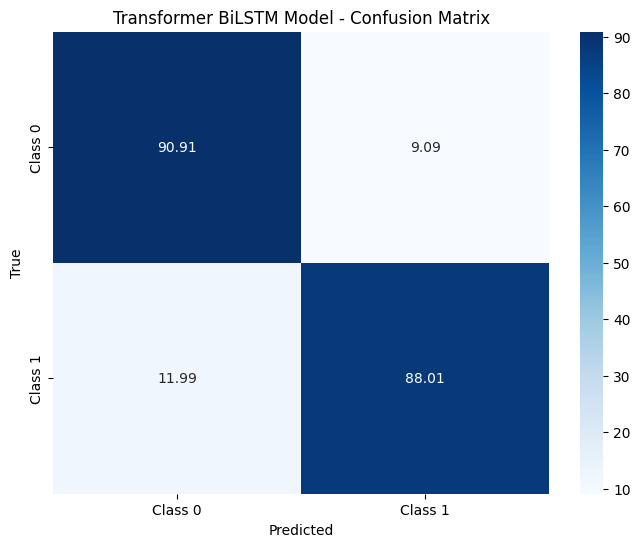

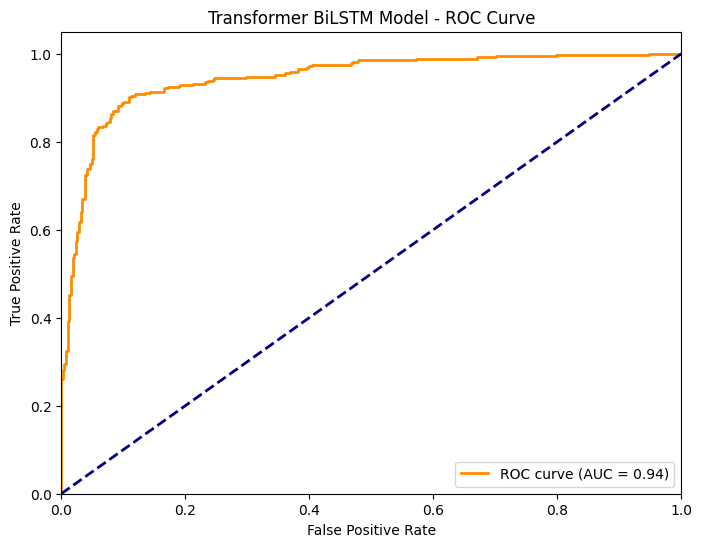

In [ ]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, roc_auc_score, matthews_corrcoef, roc_curve
import seaborn as sns
import matplotlib.pyplot as plt
import os

# تعریف دیتاست سفارشی برای تست
class CustomTestDataset(Dataset):
    def __init__(self, data, labels=None):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if self.labels is not None:
            return torch.tensor(self.data[idx], dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.long)
        else:
            return torch.tensor(self.data[idx], dtype=torch.float32)

# تابع برای بارگذاری داده‌های تست به عنوان DataLoader
def load_test_data_as_dataloader(file_paths, labels=None, batch_size=32):
    data = []
    for file_path in file_paths:
        data.append(np.load(file_path))
    data = np.concatenate(data, axis=0)
    dataset = CustomTestDataset(data, labels)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    return dataloader

# مدل ترنسفورمر با BiLSTM برای تست
class TransformerWithBiLSTM(nn.Module):
    def __init__(self, input_dim, num_classes, num_heads=8, num_layers=5, lstm_hidden_dim=32, dropout_rate=0.3):
        super(TransformerWithBiLSTM, self).__init__()

        # لایه‌های BiLSTM
        self.bilstm = nn.LSTM(input_size=input_dim, hidden_size=lstm_hidden_dim,
                              num_layers=num_layers, batch_first=True, bidirectional=True, dropout=dropout_rate)

        self.attention_layers = nn.ModuleList([nn.MultiheadAttention(embed_dim=lstm_hidden_dim * 2, num_heads=num_heads) for _ in range(num_layers)])

        self.layer_norm = nn.LayerNorm(lstm_hidden_dim * 2)
        self.fc1 = nn.Linear(lstm_hidden_dim * 2, 64)  # کاهش ابعاد لایه خطی
        self.dropout = nn.Dropout(dropout_rate)        # تغییر نرخ Dropout
        self.fc2 = nn.Linear(64, num_classes)          # سازگاری با ابعاد جدید

    def forward(self, x):
        # عبور از لایه BiLSTM
        lstm_out, _ = self.bilstm(x)

        # عبور از لایه‌های ترنسفورمر
        lstm_out = lstm_out.transpose(0, 1)  # برای سازگاری با PyTorch
        for attention in self.attention_layers:
            lstm_out, _ = attention(lstm_out, lstm_out, lstm_out)

        lstm_out = lstm_out.transpose(0, 1)  # بازگشت به شکل اولیه
        lstm_out = self.layer_norm(lstm_out)
        lstm_out = torch.mean(lstm_out, dim=1)  # GlobalAveragePooling
        lstm_out = torch.relu(self.fc1(lstm_out))
        lstm_out = self.dropout(lstm_out)       # اعمال Dropout
        lstm_out = torch.softmax(self.fc2(lstm_out), dim=-1)
        return lstm_out

# تابع تست مدل
def test_transformer_model(test_loader, model_load_path, input_dim=1024, num_classes=2):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = TransformerWithBiLSTM(input_dim=input_dim, num_classes=num_classes)
    model.to(device)

    # بارگذاری مدل ذخیره‌شده
    model.load_state_dict(torch.load(model_load_path, map_location=device))
    model.eval()

    all_predictions = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for data, labels in test_loader:
            data, labels = data.to(device), labels.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(outputs.cpu().numpy()[:, 1])  # احتمال برچسب مثبت

    all_probs = np.array(all_probs)
    return np.array(all_labels), np.array(all_predictions), all_probs

# محاسبه و نمایش معیارهای عملکرد
def calculate_metrics(y_true, y_pred_labels, y_pred_probs):
    cm = confusion_matrix(y_true, y_pred_labels)
    tn, fp, fn, tp = cm.ravel()
    sensitivity = tp / (tp + fn) * 100
    specificity = tn / (tn + fp) * 100
    accuracy = accuracy_score(y_true, y_pred_labels) * 100
    f1 = f1_score(y_true, y_pred_labels) * 100
    mcc = matthews_corrcoef(y_true, y_pred_labels) * 100
    auroc = roc_auc_score(y_true, y_pred_probs) * 100
    print(f"Sensitivity:     {sensitivity:.2f}%")
    print(f"Specificity:     {specificity:.2f}%")
    print(f"Accuracy:        {accuracy:.2f}%")
    print(f"F1 Score:        {f1:.2f}%")
    print(f"MCC:             {mcc:.2f}%")
    print(f"auROC:           {auroc:.2f}%")

# نمایش ماتریس کانفیوژن درصدی و ذخیره تصویر
def display_conf_matrix(y_true, y_pred_labels, title, filename):
    cm = confusion_matrix(y_true, y_pred_labels)
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_percent, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=['Class 0', 'Class 1'],
                yticklabels=['Class 0', 'Class 1'])
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig(filename)
    plt.show()

# رسم نمودار ROC
def plot_roc_curve(y_true, y_pred_probs, title, filename):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_score(y_true, y_pred_probs):.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.savefig(filename)
    plt.show()

# مسیر فایل‌های تست
test_save_paths_X = ['/content/drive/MyDrive/LM-RESULT2/resized_X_TEST.npy']
test_label_csv_path = '/content/drive/MyDrive/LM-RESULT2/y_test_final.csv'

# بارگذاری برچسب‌های تست
y_test = np.loadtxt(test_label_csv_path, delimiter=',', dtype=int)

# آماده‌سازی داده‌ها به عنوان DataLoader برای تست
test_loader = load_test_data_as_dataloader(test_save_paths_X, labels=y_test, batch_size=32)

# مسیر مدل ذخیره شده
model_load_path = '/content/drive/MyDrive/LM-RESULT2/best32_model.pth'

# تست مدل
y_true, y_pred_labels, predicted_probs = test_transformer_model(test_loader, model_load_path)

# محاسبه معیارها
calculate_metrics(y_true, y_pred_labels, predicted_probs)

# ایجاد دایرکتوری برای ذخیره تصاویر در صورت عدم وجود
output_dir = '/content/drive/MyDrive/my_project/LMPred_AMP_Prediction/Figuresfinal'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# نمایش و ذخیره ماتریس کانفیوژن
output_file_cm = os.path.join(output_dir, 'Transformer_BiLSTM3_Model_CM.png')
display_conf_matrix(y_true, y_pred_labels, 'Transformer BiLSTM Model - Confusion Matrix', output_file_cm)

# نمایش و ذخیره نمودار ROC
output_file_roc = os.path.join(output_dir, 'Transformer_BiLSTM3_Model_ROC.png')
plot_roc_curve(y_true, predicted_probs, 'Transformer BiLSTM Model - ROC Curve', output_file_roc)


In [ ]:
num 6

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt

# تعریف دیتاست سفارشی
class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return torch.tensor(self.data[idx], dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.long)

# تابع برای بارگذاری داده‌ها به عنوان DataLoader
def load_data_as_dataloader(file_paths, labels, batch_size, percentage=1.0):
    data = []
    for file_path in file_paths:
        data.append(np.load(file_path))
    data = np.concatenate(data, axis=0)

    # استفاده از درصدی از داده‌ها
    num_samples = data.shape[0]
    subset_size = int(num_samples * percentage)
    data = data[:subset_size]
    labels = labels[:subset_size]

    dataset = CustomDataset(data, labels)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return dataloader

# مدل ترنسفورمر با لایه‌های BiLSTM در PyTorch
class TransformerWithBiLSTM(nn.Module):
    def __init__(self, input_dim, num_classes, num_heads=8, num_layers=6, lstm_hidden_dim=32, dropout_rate=0.3):
        super(TransformerWithBiLSTM, self).__init__()

        # لایه‌های BiLSTM
        self.bilstm = nn.LSTM(input_size=input_dim, hidden_size=lstm_hidden_dim,
                              num_layers=num_layers, batch_first=True, bidirectional=True, dropout=dropout_rate)

        self.attention_layers = nn.ModuleList([
            nn.MultiheadAttention(embed_dim=lstm_hidden_dim * 2, num_heads=num_heads) for _ in range(num_layers)
        ])

        self.layer_norm = nn.LayerNorm(lstm_hidden_dim * 2)
        self.fc1 = nn.Linear(lstm_hidden_dim * 2, 64)  # کاهش ابعاد لایه خطی
        self.dropout = nn.Dropout(dropout_rate)        # تغییر نرخ Dropout
        self.fc2 = nn.Linear(64, num_classes)          # سازگاری با ابعاد جدید

    def forward(self, x):
        # عبور از لایه BiLSTM
        lstm_out, _ = self.bilstm(x)

        # عبور از لایه‌های ترنسفورمر
        lstm_out = lstm_out.transpose(0, 1)  # برای سازگاری با PyTorch
        for attention in self.attention_layers:
            lstm_out, _ = attention(lstm_out, lstm_out, lstm_out)

        lstm_out = lstm_out.transpose(0, 1)  # بازگشت به شکل اولیه
        lstm_out = self.layer_norm(lstm_out)
        lstm_out = torch.mean(lstm_out, dim=1)  # GlobalAveragePooling
        lstm_out = torch.relu(self.fc1(lstm_out))
        lstm_out = self.dropout(lstm_out)       # اعمال Dropout
        lstm_out = self.fc2(lstm_out)           # عدم نیاز به Softmax چون CrossEntropyLoss آن را خودکار انجام می‌دهد
        return lstm_out

# تابع آموزش مدل
def train_transformer_model(train_loader, val_loader, input_dim, num_classes, model_save_path, plot_save_path, epochs=100, batch_size=32):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # ایجاد مدل و انتقال به GPU
    model = TransformerWithBiLSTM(input_dim=input_dim, num_classes=num_classes)
    model.to(device)

    optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=1e-4)  # استفاده از AdamW
    criterion = nn.CrossEntropyLoss()

    # تنظیم نرخ یادگیری
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)

    # لیست‌های ذخیره تاریخچه خطا و دقت
    train_loss_history = []
    val_loss_history = []

    best_val_accuracy = 0.0
    early_stopping_counter = 0  # شمارش برای Early Stopping
    patience = 10  # تعداد ایپوک‌ها برای توقف

    # آموزش مدل
    for epoch in range(epochs):
        model.train()
        total_train_loss = 0
        correct_train = 0
        total_train = 0

        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_train += batch_y.size(0)
            correct_train += (predicted == batch_y).sum().item()

        train_accuracy = 100 * correct_train / total_train

        # اعتبارسنجی مدل
        model.eval()
        total_val_loss = 0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for val_X, val_y in val_loader:
                val_X, val_y = val_X.to(device), val_y.to(device)
                outputs = model(val_X)
                loss = criterion(outputs, val_y)
                total_val_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total_val += val_y.size(0)
                correct_val += (predicted == val_y).sum().item()

        val_accuracy = 100 * correct_val / total_val

        train_loss_history.append(total_train_loss / len(train_loader))
        val_loss_history.append(total_val_loss / len(val_loader))

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {total_train_loss / len(train_loader):.4f}, Val Loss: {total_val_loss / len(val_loader):.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Accuracy: {val_accuracy:.2f}%")

        # ذخیره مدل اگر دقت اعتبارسنجی بهبود یافته باشد
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            torch.save(model.state_dict(), model_save_path)
            print(f"New best model saved with Val Accuracy: {val_accuracy:.2f}%")
            early_stopping_counter = 0  # بازنشانی شمارش
        else:
            early_stopping_counter += 1  # افزایش شمارش

        # بروزرسانی نرخ یادگیری
        scheduler.step(total_val_loss)  # به روز رسانی نرخ یادگیری با توجه به ولیدیشن Loss

        # اگر دقت ولیدیشن بهبود نیافت، آموزش متوقف شود
        if early_stopping_counter >= patience:
            print(f"Early stopping triggered after {epoch + 1} epochs.")
            break

    # ذخیره نمودارها
    plt.figure(figsize=(10, 5))
    plt.plot(train_loss_history, label='Train Loss')
    plt.plot(val_loss_history, label='Val Loss')
    plt.title('Model Performance')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(plot_save_path)
    plt.close()
    print(f"Plots saved to {plot_save_path}")

# فراخوانی تابع train_transformer_model

# مسیر فایل‌ها
save_paths_X = [
    '/content/drive/MyDrive/LM-RESULT2/resized_X_TRAIN_batch_1.npy',
    '/content/drive/MyDrive/LM-RESULT2/resized_X_TRAIN_batch_2.npy',
    '/content/drive/MyDrive/LM-RESULT2/resized_X_TRAIN_batch_3.npy',
    '/content/drive/MyDrive/LM-RESULT2/resized_X_TRAIN_batch_4.npy',
    '/content/drive/MyDrive/LM-RESULT2/resized_X_TRAIN_batch_5.npy',
    '/content/drive/MyDrive/LM-RESULT2/resized_X_TRAIN_batch_6.npy'
]
val_save_path_X = '/content/drive/MyDrive/LM-RESULT2/resized_X_val.npy'
val_label_csv_path = '/content/drive/MyDrive/LM-RESULT2/y_val_final.csv'

# بارگذاری برچسب‌ها
train_labels = np.loadtxt('/content/drive/MyDrive/LM-RESULT2/y_train_final.csv', delimiter=',', dtype=int)
val_labels = np.loadtxt(val_label_csv_path, delimiter=',', dtype=int)

# آماده‌سازی داده‌ها به عنوان DataLoader برای 100 درصد داده‌ها
train_loader = load_data_as_dataloader(save_paths_X, train_labels, batch_size=32, percentage=1.0)
val_loader = load_data_as_dataloader([val_save_path_X], val_labels, batch_size=32, percentage=1.0)

# تنظیمات مدل و آموزش با 100 ایپوک
input_dim = 1024  # ابعاد ورودی داده‌ها (باید با داده‌ها سازگار باشد)
num_classes = 2   # تعداد کلاس‌ها (برچسب‌ها)

train_transformer_model(
    train_loader,          # داده‌های آموزشی
    val_loader,            # داده‌های اعتبارسنجی
    input_dim=input_dim,   # ابعاد ورودی
    num_classes=num_classes,  # تعداد کلاس‌ها
    model_save_path='/content/drive/MyDrive/LM-RESULT2/best33_model.pth',  # مسیر ذخیره مدل
    plot_save_path='/content/drive/MyDrive/LM-RESULT2/training33_plot.png',  # مسیر ذخیره نمودار
    epochs=100,            # تعداد ایپوک‌ها
    batch_size=32          # اندازه بچ
)


Epoch 1/100, Train Loss: 0.6959, Val Loss: 0.6932, Train Accuracy: 49.69%, Val Accuracy: 49.57%
New best model saved with Val Accuracy: 49.57%
Epoch 2/100, Train Loss: 0.6951, Val Loss: 0.6915, Train Accuracy: 49.67%, Val Accuracy: 50.43%
New best model saved with Val Accuracy: 50.43%
Epoch 3/100, Train Loss: 0.4937, Val Loss: 0.4475, Train Accuracy: 79.15%, Val Accuracy: 82.37%
New best model saved with Val Accuracy: 82.37%
Epoch 4/100, Train Loss: 0.4006, Val Loss: 0.4155, Train Accuracy: 85.76%, Val Accuracy: 84.56%
New best model saved with Val Accuracy: 84.56%
Epoch 5/100, Train Loss: 0.3665, Val Loss: 0.4004, Train Accuracy: 86.75%, Val Accuracy: 84.63%
New best model saved with Val Accuracy: 84.63%
Epoch 6/100, Train Loss: 0.3418, Val Loss: 0.3744, Train Accuracy: 88.22%, Val Accuracy: 85.50%
New best model saved with Val Accuracy: 85.50%
Epoch 7/100, Train Loss: 0.3098, Val Loss: 0.3383, Train Accuracy: 89.43%, Val Accuracy: 87.96%
New best model saved with Val Accuracy: 87.96%

<ipython-input-2-7d196ea1a000>:76: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_load_path, map_location=device))


Sensitivity:     89.65%
Specificity:     89.09%
Accuracy:        89.36%
F1 Score:        89.16%
MCC:             78.72%
auROC:           93.91%


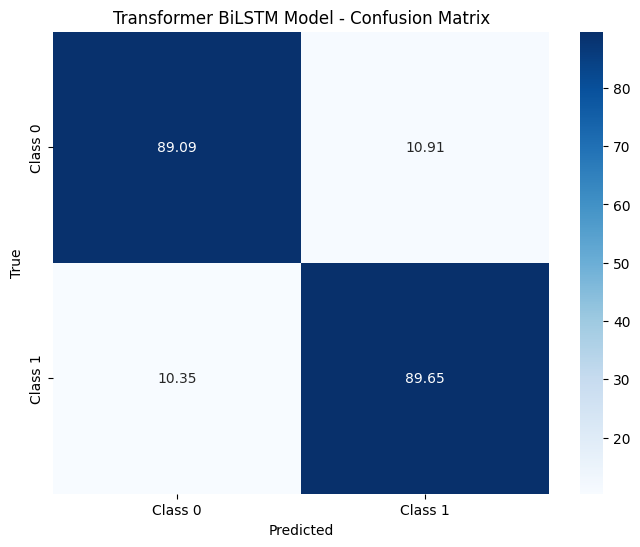

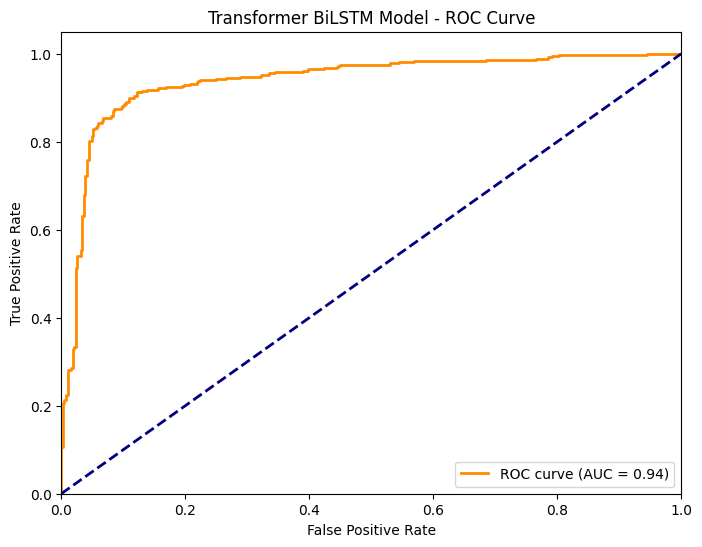

In [ ]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, roc_auc_score, matthews_corrcoef, roc_curve
import seaborn as sns
import matplotlib.pyplot as plt
import os

# تعریف دیتاست سفارشی برای تست
class CustomTestDataset(Dataset):
    def __init__(self, data, labels=None):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if self.labels is not None:
            return torch.tensor(self.data[idx], dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.long)
        else:
            return torch.tensor(self.data[idx], dtype=torch.float32)

# تابع برای بارگذاری داده‌های تست به عنوان DataLoader
def load_test_data_as_dataloader(file_paths, labels=None, batch_size=32):
    data = []
    for file_path in file_paths:
        data.append(np.load(file_path))
    data = np.concatenate(data, axis=0)
    dataset = CustomTestDataset(data, labels)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    return dataloader

# مدل ترنسفورمر با BiLSTM برای تست
class TransformerWithBiLSTM(nn.Module):
    def __init__(self, input_dim, num_classes, num_heads=8, num_layers=6, lstm_hidden_dim=32, dropout_rate=0.3):
        super(TransformerWithBiLSTM, self).__init__()

        # لایه‌های BiLSTM
        self.bilstm = nn.LSTM(input_size=input_dim, hidden_size=lstm_hidden_dim,
                              num_layers=num_layers, batch_first=True, bidirectional=True, dropout=dropout_rate)

        self.attention_layers = nn.ModuleList([nn.MultiheadAttention(embed_dim=lstm_hidden_dim * 2, num_heads=num_heads) for _ in range(num_layers)])

        self.layer_norm = nn.LayerNorm(lstm_hidden_dim * 2)
        self.fc1 = nn.Linear(lstm_hidden_dim * 2, 64)  # کاهش ابعاد لایه خطی
        self.dropout = nn.Dropout(dropout_rate)        # تغییر نرخ Dropout
        self.fc2 = nn.Linear(64, num_classes)          # سازگاری با ابعاد جدید

    def forward(self, x):
        # عبور از لایه BiLSTM
        lstm_out, _ = self.bilstm(x)

        # عبور از لایه‌های ترنسفورمر
        lstm_out = lstm_out.transpose(0, 1)  # برای سازگاری با PyTorch
        for attention in self.attention_layers:
            lstm_out, _ = attention(lstm_out, lstm_out, lstm_out)

        lstm_out = lstm_out.transpose(0, 1)  # بازگشت به شکل اولیه
        lstm_out = self.layer_norm(lstm_out)
        lstm_out = torch.mean(lstm_out, dim=1)  # GlobalAveragePooling
        lstm_out = torch.relu(self.fc1(lstm_out))
        lstm_out = self.dropout(lstm_out)       # اعمال Dropout
        lstm_out = torch.softmax(self.fc2(lstm_out), dim=-1)
        return lstm_out

# تابع تست مدل
def test_transformer_model(test_loader, model_load_path, input_dim=1024, num_classes=2):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = TransformerWithBiLSTM(input_dim=input_dim, num_classes=num_classes)
    model.to(device)

    # بارگذاری مدل ذخیره‌شده
    model.load_state_dict(torch.load(model_load_path, map_location=device))
    model.eval()

    all_predictions = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for data, labels in test_loader:
            data, labels = data.to(device), labels.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(outputs.cpu().numpy()[:, 1])  # احتمال برچسب مثبت

    all_probs = np.array(all_probs)
    return np.array(all_labels), np.array(all_predictions), all_probs

# محاسبه و نمایش معیارهای عملکرد
def calculate_metrics(y_true, y_pred_labels, y_pred_probs):
    cm = confusion_matrix(y_true, y_pred_labels)
    tn, fp, fn, tp = cm.ravel()
    sensitivity = tp / (tp + fn) * 100
    specificity = tn / (tn + fp) * 100
    accuracy = accuracy_score(y_true, y_pred_labels) * 100
    f1 = f1_score(y_true, y_pred_labels) * 100
    mcc = matthews_corrcoef(y_true, y_pred_labels) * 100
    auroc = roc_auc_score(y_true, y_pred_probs) * 100
    print(f"Sensitivity:     {sensitivity:.2f}%")
    print(f"Specificity:     {specificity:.2f}%")
    print(f"Accuracy:        {accuracy:.2f}%")
    print(f"F1 Score:        {f1:.2f}%")
    print(f"MCC:             {mcc:.2f}%")
    print(f"auROC:           {auroc:.2f}%")

# نمایش ماتریس کانفیوژن درصدی و ذخیره تصویر
def display_conf_matrix(y_true, y_pred_labels, title, filename):
    cm = confusion_matrix(y_true, y_pred_labels)
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_percent, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=['Class 0', 'Class 1'],
                yticklabels=['Class 0', 'Class 1'])
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig(filename)
    plt.show()

# رسم نمودار ROC
def plot_roc_curve(y_true, y_pred_probs, title, filename):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_score(y_true, y_pred_probs):.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.savefig(filename)
    plt.show()

# مسیر فایل‌های تست
test_save_paths_X = ['/content/drive/MyDrive/LM-RESULT2/resized_X_TEST.npy']
test_label_csv_path = '/content/drive/MyDrive/LM-RESULT2/y_test_final.csv'

# بارگذاری برچسب‌های تست
y_test = np.loadtxt(test_label_csv_path, delimiter=',', dtype=int)

# آماده‌سازی داده‌ها به عنوان DataLoader برای تست
test_loader = load_test_data_as_dataloader(test_save_paths_X, labels=y_test, batch_size=32)

# مسیر مدل ذخیره شده
model_load_path = '/content/drive/MyDrive/LM-RESULT2/best33_model.pth'

# تست مدل
y_true, y_pred_labels, predicted_probs = test_transformer_model(test_loader, model_load_path)

# محاسبه معیارها
calculate_metrics(y_true, y_pred_labels, predicted_probs)

# ایجاد دایرکتوری برای ذخیره تصاویر در صورت عدم وجود
output_dir = '/content/drive/MyDrive/my_project/LMPred_AMP_Prediction/Figuresfinal'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# نمایش و ذخیره ماتریس کانفیوژن
output_file_cm = os.path.join(output_dir, 'Transformer_BiLSTM3_Model_CM.png')
display_conf_matrix(y_true, y_pred_labels, 'Transformer BiLSTM Model - Confusion Matrix', output_file_cm)

# نمایش و ذخیره نمودار ROC
output_file_roc = os.path.join(output_dir, 'Transformer_BiLSTM3_Model_ROC.png')
plot_roc_curve(y_true, predicted_probs, 'Transformer BiLSTM Model - ROC Curve', output_file_roc)


In [ ]:
num head 2

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt

# تعریف دیتاست سفارشی
class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return torch.tensor(self.data[idx], dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.long)

# تابع برای بارگذاری داده‌ها به عنوان DataLoader
def load_data_as_dataloader(file_paths, labels, batch_size, percentage=1.0):
    data = []
    for file_path in file_paths:
        data.append(np.load(file_path))
    data = np.concatenate(data, axis=0)

    # استفاده از درصدی از داده‌ها
    num_samples = data.shape[0]
    subset_size = int(num_samples * percentage)
    data = data[:subset_size]
    labels = labels[:subset_size]

    dataset = CustomDataset(data, labels)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return dataloader

# مدل ترنسفورمر با لایه‌های BiLSTM در PyTorch
class TransformerWithBiLSTM(nn.Module):
    def __init__(self, input_dim, num_classes, num_heads=2, num_layers=2, lstm_hidden_dim=32, dropout_rate=0.3):
        super(TransformerWithBiLSTM, self).__init__()

        # لایه‌های BiLSTM
        self.bilstm = nn.LSTM(input_size=input_dim, hidden_size=lstm_hidden_dim,
                              num_layers=num_layers, batch_first=True, bidirectional=True, dropout=dropout_rate)

        self.attention_layers = nn.ModuleList([
            nn.MultiheadAttention(embed_dim=lstm_hidden_dim * 2, num_heads=num_heads) for _ in range(num_layers)
        ])

        self.layer_norm = nn.LayerNorm(lstm_hidden_dim * 2)
        self.fc1 = nn.Linear(lstm_hidden_dim * 2, 64)  # کاهش ابعاد لایه خطی
        self.dropout = nn.Dropout(dropout_rate)        # تغییر نرخ Dropout
        self.fc2 = nn.Linear(64, num_classes)          # سازگاری با ابعاد جدید

    def forward(self, x):
        # عبور از لایه BiLSTM
        lstm_out, _ = self.bilstm(x)

        # عبور از لایه‌های ترنسفورمر
        lstm_out = lstm_out.transpose(0, 1)  # برای سازگاری با PyTorch
        for attention in self.attention_layers:
            lstm_out, _ = attention(lstm_out, lstm_out, lstm_out)

        lstm_out = lstm_out.transpose(0, 1)  # بازگشت به شکل اولیه
        lstm_out = self.layer_norm(lstm_out)
        lstm_out = torch.mean(lstm_out, dim=1)  # GlobalAveragePooling
        lstm_out = torch.relu(self.fc1(lstm_out))
        lstm_out = self.dropout(lstm_out)       # اعمال Dropout
        lstm_out = self.fc2(lstm_out)           # عدم نیاز به Softmax چون CrossEntropyLoss آن را خودکار انجام می‌دهد
        return lstm_out

# تابع آموزش مدل
def train_transformer_model(train_loader, val_loader, input_dim, num_classes, model_save_path, plot_save_path, epochs=100, batch_size=32):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # ایجاد مدل و انتقال به GPU
    model = TransformerWithBiLSTM(input_dim=input_dim, num_classes=num_classes)
    model.to(device)

    optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=1e-4)  # استفاده از AdamW
    criterion = nn.CrossEntropyLoss()

    # تنظیم نرخ یادگیری
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)

    # لیست‌های ذخیره تاریخچه خطا و دقت
    train_loss_history = []
    val_loss_history = []

    best_val_accuracy = 0.0
    early_stopping_counter = 0  # شمارش برای Early Stopping
    patience = 10  # تعداد ایپوک‌ها برای توقف

    # آموزش مدل
    for epoch in range(epochs):
        model.train()
        total_train_loss = 0
        correct_train = 0
        total_train = 0

        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_train += batch_y.size(0)
            correct_train += (predicted == batch_y).sum().item()

        train_accuracy = 100 * correct_train / total_train

        # اعتبارسنجی مدل
        model.eval()
        total_val_loss = 0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for val_X, val_y in val_loader:
                val_X, val_y = val_X.to(device), val_y.to(device)
                outputs = model(val_X)
                loss = criterion(outputs, val_y)
                total_val_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total_val += val_y.size(0)
                correct_val += (predicted == val_y).sum().item()

        val_accuracy = 100 * correct_val / total_val

        train_loss_history.append(total_train_loss / len(train_loader))
        val_loss_history.append(total_val_loss / len(val_loader))

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {total_train_loss / len(train_loader):.4f}, Val Loss: {total_val_loss / len(val_loader):.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Accuracy: {val_accuracy:.2f}%")

        # ذخیره مدل اگر دقت اعتبارسنجی بهبود یافته باشد
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            torch.save(model.state_dict(), model_save_path)
            print(f"New best model saved with Val Accuracy: {val_accuracy:.2f}%")
            early_stopping_counter = 0  # بازنشانی شمارش
        else:
            early_stopping_counter += 1  # افزایش شمارش

        # بروزرسانی نرخ یادگیری
        scheduler.step(total_val_loss)  # به روز رسانی نرخ یادگیری با توجه به ولیدیشن Loss

        # اگر دقت ولیدیشن بهبود نیافت، آموزش متوقف شود
        if early_stopping_counter >= patience:
            print(f"Early stopping triggered after {epoch + 1} epochs.")
            break

    # ذخیره نمودارها
    plt.figure(figsize=(10, 5))
    plt.plot(train_loss_history, label='Train Loss')
    plt.plot(val_loss_history, label='Val Loss')
    plt.title('Model Performance')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(plot_save_path)
    plt.close()
    print(f"Plots saved to {plot_save_path}")

# فراخوانی تابع train_transformer_model

# مسیر فایل‌ها
save_paths_X = [
    '/content/drive/MyDrive/LM-RESULT2/resized_X_TRAIN_batch_1.npy',
    '/content/drive/MyDrive/LM-RESULT2/resized_X_TRAIN_batch_2.npy',
    '/content/drive/MyDrive/LM-RESULT2/resized_X_TRAIN_batch_3.npy',
    '/content/drive/MyDrive/LM-RESULT2/resized_X_TRAIN_batch_4.npy',
    '/content/drive/MyDrive/LM-RESULT2/resized_X_TRAIN_batch_5.npy',
    '/content/drive/MyDrive/LM-RESULT2/resized_X_TRAIN_batch_6.npy'
]
val_save_path_X = '/content/drive/MyDrive/LM-RESULT2/resized_X_val.npy'
val_label_csv_path = '/content/drive/MyDrive/LM-RESULT2/y_val_final.csv'

# بارگذاری برچسب‌ها
train_labels = np.loadtxt('/content/drive/MyDrive/LM-RESULT2/y_train_final.csv', delimiter=',', dtype=int)
val_labels = np.loadtxt(val_label_csv_path, delimiter=',', dtype=int)

# آماده‌سازی داده‌ها به عنوان DataLoader برای 100 درصد داده‌ها
train_loader = load_data_as_dataloader(save_paths_X, train_labels, batch_size=32, percentage=1.0)
val_loader = load_data_as_dataloader([val_save_path_X], val_labels, batch_size=32, percentage=1.0)

# تنظیمات مدل و آموزش با 100 ایپوک
input_dim = 1024  # ابعاد ورودی داده‌ها (باید با داده‌ها سازگار باشد)
num_classes = 2   # تعداد کلاس‌ها (برچسب‌ها)

train_transformer_model(
    train_loader,          # داده‌های آموزشی
    val_loader,            # داده‌های اعتبارسنجی
    input_dim=input_dim,   # ابعاد ورودی
    num_classes=num_classes,  # تعداد کلاس‌ها
    model_save_path='/content/drive/MyDrive/LM-RESULT2/best34_model.pth',  # مسیر ذخیره مدل
    plot_save_path='/content/drive/MyDrive/LM-RESULT2/training34_plot.png',  # مسیر ذخیره نمودار
    epochs=100,            # تعداد ایپوک‌ها
    batch_size=32          # اندازه بچ
)


Epoch 1/100, Train Loss: 0.5761, Val Loss: 0.4211, Train Accuracy: 68.79%, Val Accuracy: 83.70%
New best model saved with Val Accuracy: 83.70%
Epoch 2/100, Train Loss: 0.3677, Val Loss: 0.3737, Train Accuracy: 85.23%, Val Accuracy: 84.23%
New best model saved with Val Accuracy: 84.23%
Epoch 3/100, Train Loss: 0.3250, Val Loss: 0.3306, Train Accuracy: 87.38%, Val Accuracy: 86.63%
New best model saved with Val Accuracy: 86.63%
Epoch 4/100, Train Loss: 0.2968, Val Loss: 0.3044, Train Accuracy: 88.42%, Val Accuracy: 88.09%
New best model saved with Val Accuracy: 88.09%
Epoch 5/100, Train Loss: 0.2762, Val Loss: 0.3071, Train Accuracy: 89.83%, Val Accuracy: 87.76%
Epoch 6/100, Train Loss: 0.2612, Val Loss: 0.3009, Train Accuracy: 90.10%, Val Accuracy: 88.49%
New best model saved with Val Accuracy: 88.49%
Epoch 7/100, Train Loss: 0.2476, Val Loss: 0.2968, Train Accuracy: 91.09%, Val Accuracy: 88.49%
Epoch 8/100, Train Loss: 0.2360, Val Loss: 0.2760, Train Accuracy: 91.31%, Val Accuracy: 89.6

<ipython-input-2-2669e031f00e>:76: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_load_path, map_location=device))


Sensitivity:     88.28%
Specificity:     89.87%
Accuracy:        89.10%
F1 Score:        88.77%
MCC:             78.18%
auROC:           94.53%


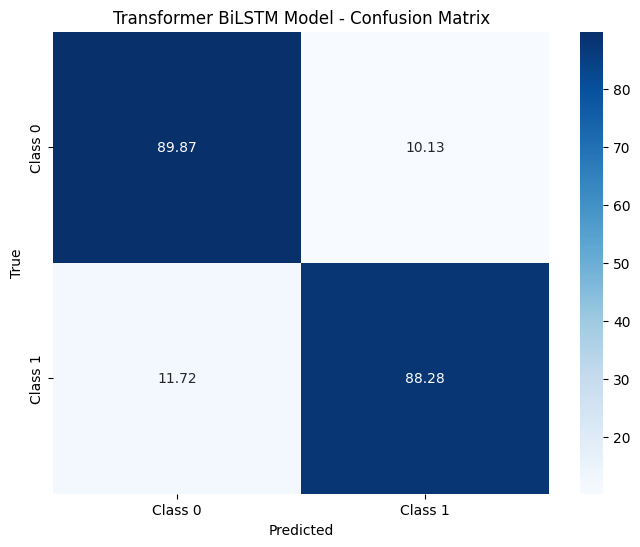

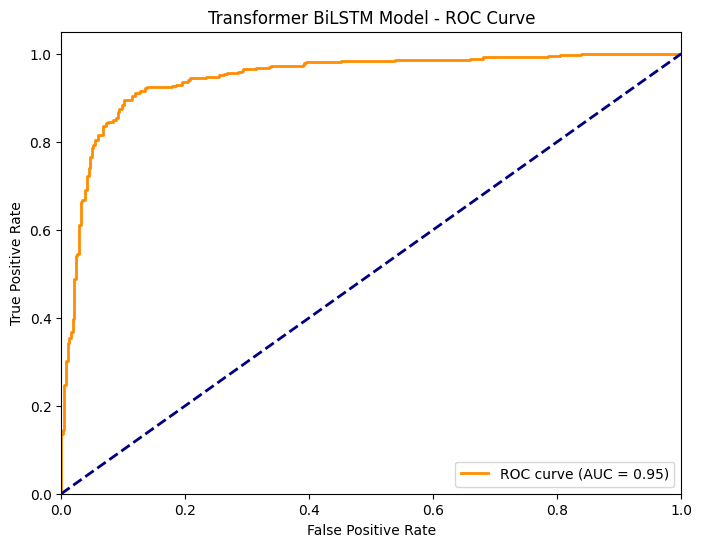

In [ ]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, roc_auc_score, matthews_corrcoef, roc_curve
import seaborn as sns
import matplotlib.pyplot as plt
import os

# تعریف دیتاست سفارشی برای تست
class CustomTestDataset(Dataset):
    def __init__(self, data, labels=None):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if self.labels is not None:
            return torch.tensor(self.data[idx], dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.long)
        else:
            return torch.tensor(self.data[idx], dtype=torch.float32)

# تابع برای بارگذاری داده‌های تست به عنوان DataLoader
def load_test_data_as_dataloader(file_paths, labels=None, batch_size=32):
    data = []
    for file_path in file_paths:
        data.append(np.load(file_path))
    data = np.concatenate(data, axis=0)
    dataset = CustomTestDataset(data, labels)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    return dataloader

# مدل ترنسفورمر با BiLSTM برای تست
class TransformerWithBiLSTM(nn.Module):
    def __init__(self, input_dim, num_classes, num_heads=2, num_layers=2, lstm_hidden_dim=32, dropout_rate=0.3):
        super(TransformerWithBiLSTM, self).__init__()

        # لایه‌های BiLSTM
        self.bilstm = nn.LSTM(input_size=input_dim, hidden_size=lstm_hidden_dim,
                              num_layers=num_layers, batch_first=True, bidirectional=True, dropout=dropout_rate)

        self.attention_layers = nn.ModuleList([nn.MultiheadAttention(embed_dim=lstm_hidden_dim * 2, num_heads=num_heads) for _ in range(num_layers)])

        self.layer_norm = nn.LayerNorm(lstm_hidden_dim * 2)
        self.fc1 = nn.Linear(lstm_hidden_dim * 2, 64)  # کاهش ابعاد لایه خطی
        self.dropout = nn.Dropout(dropout_rate)        # تغییر نرخ Dropout
        self.fc2 = nn.Linear(64, num_classes)          # سازگاری با ابعاد جدید

    def forward(self, x):
        # عبور از لایه BiLSTM
        lstm_out, _ = self.bilstm(x)

        # عبور از لایه‌های ترنسفورمر
        lstm_out = lstm_out.transpose(0, 1)  # برای سازگاری با PyTorch
        for attention in self.attention_layers:
            lstm_out, _ = attention(lstm_out, lstm_out, lstm_out)

        lstm_out = lstm_out.transpose(0, 1)  # بازگشت به شکل اولیه
        lstm_out = self.layer_norm(lstm_out)
        lstm_out = torch.mean(lstm_out, dim=1)  # GlobalAveragePooling
        lstm_out = torch.relu(self.fc1(lstm_out))
        lstm_out = self.dropout(lstm_out)       # اعمال Dropout
        lstm_out = torch.softmax(self.fc2(lstm_out), dim=-1)
        return lstm_out

# تابع تست مدل
def test_transformer_model(test_loader, model_load_path, input_dim=1024, num_classes=2):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = TransformerWithBiLSTM(input_dim=input_dim, num_classes=num_classes)
    model.to(device)

    # بارگذاری مدل ذخیره‌شده
    model.load_state_dict(torch.load(model_load_path, map_location=device))
    model.eval()

    all_predictions = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for data, labels in test_loader:
            data, labels = data.to(device), labels.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(outputs.cpu().numpy()[:, 1])  # احتمال برچسب مثبت

    all_probs = np.array(all_probs)
    return np.array(all_labels), np.array(all_predictions), all_probs

# محاسبه و نمایش معیارهای عملکرد
def calculate_metrics(y_true, y_pred_labels, y_pred_probs):
    cm = confusion_matrix(y_true, y_pred_labels)
    tn, fp, fn, tp = cm.ravel()
    sensitivity = tp / (tp + fn) * 100
    specificity = tn / (tn + fp) * 100
    accuracy = accuracy_score(y_true, y_pred_labels) * 100
    f1 = f1_score(y_true, y_pred_labels) * 100
    mcc = matthews_corrcoef(y_true, y_pred_labels) * 100
    auroc = roc_auc_score(y_true, y_pred_probs) * 100
    print(f"Sensitivity:     {sensitivity:.2f}%")
    print(f"Specificity:     {specificity:.2f}%")
    print(f"Accuracy:        {accuracy:.2f}%")
    print(f"F1 Score:        {f1:.2f}%")
    print(f"MCC:             {mcc:.2f}%")
    print(f"auROC:           {auroc:.2f}%")

# نمایش ماتریس کانفیوژن درصدی و ذخیره تصویر
def display_conf_matrix(y_true, y_pred_labels, title, filename):
    cm = confusion_matrix(y_true, y_pred_labels)
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_percent, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=['Class 0', 'Class 1'],
                yticklabels=['Class 0', 'Class 1'])
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig(filename)
    plt.show()

# رسم نمودار ROC
def plot_roc_curve(y_true, y_pred_probs, title, filename):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_score(y_true, y_pred_probs):.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.savefig(filename)
    plt.show()

# مسیر فایل‌های تست
test_save_paths_X = ['/content/drive/MyDrive/LM-RESULT2/resized_X_TEST.npy']
test_label_csv_path = '/content/drive/MyDrive/LM-RESULT2/y_test_final.csv'

# بارگذاری برچسب‌های تست
y_test = np.loadtxt(test_label_csv_path, delimiter=',', dtype=int)

# آماده‌سازی داده‌ها به عنوان DataLoader برای تست
test_loader = load_test_data_as_dataloader(test_save_paths_X, labels=y_test, batch_size=32)

# مسیر مدل ذخیره شده
model_load_path = '/content/drive/MyDrive/LM-RESULT2/best34_model.pth'

# تست مدل
y_true, y_pred_labels, predicted_probs = test_transformer_model(test_loader, model_load_path)

# محاسبه معیارها
calculate_metrics(y_true, y_pred_labels, predicted_probs)

# ایجاد دایرکتوری برای ذخیره تصاویر در صورت عدم وجود
output_dir = '/content/drive/MyDrive/my_project/LMPred_AMP_Prediction/Figuresfinal'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# نمایش و ذخیره ماتریس کانفیوژن
output_file_cm = os.path.join(output_dir, 'Transformer_BiLSTM3_Model_CM.png')
display_conf_matrix(y_true, y_pred_labels, 'Transformer BiLSTM Model - Confusion Matrix', output_file_cm)

# نمایش و ذخیره نمودار ROC
output_file_roc = os.path.join(output_dir, 'Transformer_BiLSTM3_Model_ROC.png')
plot_roc_curve(y_true, predicted_probs, 'Transformer BiLSTM Model - ROC Curve', output_file_roc)


In [ ]:
head4

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt

# تعریف دیتاست سفارشی
class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return torch.tensor(self.data[idx], dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.long)

# تابع برای بارگذاری داده‌ها به عنوان DataLoader
def load_data_as_dataloader(file_paths, labels, batch_size, percentage=1.0):
    data = []
    for file_path in file_paths:
        data.append(np.load(file_path))
    data = np.concatenate(data, axis=0)

    # استفاده از درصدی از داده‌ها
    num_samples = data.shape[0]
    subset_size = int(num_samples * percentage)
    data = data[:subset_size]
    labels = labels[:subset_size]

    dataset = CustomDataset(data, labels)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return dataloader

# مدل ترنسفورمر با لایه‌های BiLSTM در PyTorch
class TransformerWithBiLSTM(nn.Module):
    def __init__(self, input_dim, num_classes, num_heads=4, num_layers=2, lstm_hidden_dim=32, dropout_rate=0.3):
        super(TransformerWithBiLSTM, self).__init__()

        # لایه‌های BiLSTM
        self.bilstm = nn.LSTM(input_size=input_dim, hidden_size=lstm_hidden_dim,
                              num_layers=num_layers, batch_first=True, bidirectional=True, dropout=dropout_rate)

        self.attention_layers = nn.ModuleList([
            nn.MultiheadAttention(embed_dim=lstm_hidden_dim * 2, num_heads=num_heads) for _ in range(num_layers)
        ])

        self.layer_norm = nn.LayerNorm(lstm_hidden_dim * 2)
        self.fc1 = nn.Linear(lstm_hidden_dim * 2, 64)  # کاهش ابعاد لایه خطی
        self.dropout = nn.Dropout(dropout_rate)        # تغییر نرخ Dropout
        self.fc2 = nn.Linear(64, num_classes)          # سازگاری با ابعاد جدید

    def forward(self, x):
        # عبور از لایه BiLSTM
        lstm_out, _ = self.bilstm(x)

        # عبور از لایه‌های ترنسفورمر
        lstm_out = lstm_out.transpose(0, 1)  # برای سازگاری با PyTorch
        for attention in self.attention_layers:
            lstm_out, _ = attention(lstm_out, lstm_out, lstm_out)

        lstm_out = lstm_out.transpose(0, 1)  # بازگشت به شکل اولیه
        lstm_out = self.layer_norm(lstm_out)
        lstm_out = torch.mean(lstm_out, dim=1)  # GlobalAveragePooling
        lstm_out = torch.relu(self.fc1(lstm_out))
        lstm_out = self.dropout(lstm_out)       # اعمال Dropout
        lstm_out = self.fc2(lstm_out)           # عدم نیاز به Softmax چون CrossEntropyLoss آن را خودکار انجام می‌دهد
        return lstm_out

# تابع آموزش مدل
def train_transformer_model(train_loader, val_loader, input_dim, num_classes, model_save_path, plot_save_path, epochs=100, batch_size=32):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # ایجاد مدل و انتقال به GPU
    model = TransformerWithBiLSTM(input_dim=input_dim, num_classes=num_classes)
    model.to(device)

    optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=1e-4)  # استفاده از AdamW
    criterion = nn.CrossEntropyLoss()

    # تنظیم نرخ یادگیری
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)

    # لیست‌های ذخیره تاریخچه خطا و دقت
    train_loss_history = []
    val_loss_history = []

    best_val_accuracy = 0.0
    early_stopping_counter = 0  # شمارش برای Early Stopping
    patience = 10  # تعداد ایپوک‌ها برای توقف

    # آموزش مدل
    for epoch in range(epochs):
        model.train()
        total_train_loss = 0
        correct_train = 0
        total_train = 0

        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_train += batch_y.size(0)
            correct_train += (predicted == batch_y).sum().item()

        train_accuracy = 100 * correct_train / total_train

        # اعتبارسنجی مدل
        model.eval()
        total_val_loss = 0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for val_X, val_y in val_loader:
                val_X, val_y = val_X.to(device), val_y.to(device)
                outputs = model(val_X)
                loss = criterion(outputs, val_y)
                total_val_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total_val += val_y.size(0)
                correct_val += (predicted == val_y).sum().item()

        val_accuracy = 100 * correct_val / total_val

        train_loss_history.append(total_train_loss / len(train_loader))
        val_loss_history.append(total_val_loss / len(val_loader))

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {total_train_loss / len(train_loader):.4f}, Val Loss: {total_val_loss / len(val_loader):.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Accuracy: {val_accuracy:.2f}%")

        # ذخیره مدل اگر دقت اعتبارسنجی بهبود یافته باشد
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            torch.save(model.state_dict(), model_save_path)
            print(f"New best model saved with Val Accuracy: {val_accuracy:.2f}%")
            early_stopping_counter = 0  # بازنشانی شمارش
        else:
            early_stopping_counter += 1  # افزایش شمارش

        # بروزرسانی نرخ یادگیری
        scheduler.step(total_val_loss)  # به روز رسانی نرخ یادگیری با توجه به ولیدیشن Loss

        # اگر دقت ولیدیشن بهبود نیافت، آموزش متوقف شود
        if early_stopping_counter >= patience:
            print(f"Early stopping triggered after {epoch + 1} epochs.")
            break

    # ذخیره نمودارها
    plt.figure(figsize=(10, 5))
    plt.plot(train_loss_history, label='Train Loss')
    plt.plot(val_loss_history, label='Val Loss')
    plt.title('Model Performance')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(plot_save_path)
    plt.close()
    print(f"Plots saved to {plot_save_path}")

# فراخوانی تابع train_transformer_model

# مسیر فایل‌ها
save_paths_X = [
    '/content/drive/MyDrive/LM-RESULT2/resized_X_TRAIN_batch_1.npy',
    '/content/drive/MyDrive/LM-RESULT2/resized_X_TRAIN_batch_2.npy',
    '/content/drive/MyDrive/LM-RESULT2/resized_X_TRAIN_batch_3.npy',
    '/content/drive/MyDrive/LM-RESULT2/resized_X_TRAIN_batch_4.npy',
    '/content/drive/MyDrive/LM-RESULT2/resized_X_TRAIN_batch_5.npy',
    '/content/drive/MyDrive/LM-RESULT2/resized_X_TRAIN_batch_6.npy'
]
val_save_path_X = '/content/drive/MyDrive/LM-RESULT2/resized_X_val.npy'
val_label_csv_path = '/content/drive/MyDrive/LM-RESULT2/y_val_final.csv'

# بارگذاری برچسب‌ها
train_labels = np.loadtxt('/content/drive/MyDrive/LM-RESULT2/y_train_final.csv', delimiter=',', dtype=int)
val_labels = np.loadtxt(val_label_csv_path, delimiter=',', dtype=int)

# آماده‌سازی داده‌ها به عنوان DataLoader برای 100 درصد داده‌ها
train_loader = load_data_as_dataloader(save_paths_X, train_labels, batch_size=32, percentage=1.0)
val_loader = load_data_as_dataloader([val_save_path_X], val_labels, batch_size=32, percentage=1.0)

# تنظیمات مدل و آموزش با 100 ایپوک
input_dim = 1024  # ابعاد ورودی داده‌ها (باید با داده‌ها سازگار باشد)
num_classes = 2   # تعداد کلاس‌ها (برچسب‌ها)

train_transformer_model(
    train_loader,          # داده‌های آموزشی
    val_loader,            # داده‌های اعتبارسنجی
    input_dim=input_dim,   # ابعاد ورودی
    num_classes=num_classes,  # تعداد کلاس‌ها
    model_save_path='/content/drive/MyDrive/LM-RESULT2/best35_model.pth',  # مسیر ذخیره مدل
    plot_save_path='/content/drive/MyDrive/LM-RESULT2/training35_plot.png',  # مسیر ذخیره نمودار
    epochs=100,            # تعداد ایپوک‌ها
    batch_size=32          # اندازه بچ
)


Epoch 1/100, Train Loss: 0.6015, Val Loss: 0.4407, Train Accuracy: 65.82%, Val Accuracy: 80.90%
New best model saved with Val Accuracy: 80.90%
Epoch 2/100, Train Loss: 0.3756, Val Loss: 0.3460, Train Accuracy: 85.17%, Val Accuracy: 86.23%
New best model saved with Val Accuracy: 86.23%
Epoch 3/100, Train Loss: 0.3076, Val Loss: 0.3169, Train Accuracy: 88.35%, Val Accuracy: 87.96%
New best model saved with Val Accuracy: 87.96%
Epoch 4/100, Train Loss: 0.2862, Val Loss: 0.3124, Train Accuracy: 89.22%, Val Accuracy: 87.76%
Epoch 5/100, Train Loss: 0.2787, Val Loss: 0.3276, Train Accuracy: 89.74%, Val Accuracy: 87.03%
Epoch 6/100, Train Loss: 0.2510, Val Loss: 0.2897, Train Accuracy: 90.90%, Val Accuracy: 89.22%
New best model saved with Val Accuracy: 89.22%
Epoch 7/100, Train Loss: 0.2433, Val Loss: 0.2948, Train Accuracy: 91.03%, Val Accuracy: 89.09%
Epoch 8/100, Train Loss: 0.2316, Val Loss: 0.2867, Train Accuracy: 91.94%, Val Accuracy: 89.02%
Epoch 9/100, Train Loss: 0.2110, Val Loss: 0

<ipython-input-5-b6638e8b075f>:76: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_load_path, map_location=device))


Sensitivity:     87.74%
Specificity:     91.95%
Accuracy:        89.89%
F1 Score:        89.44%
MCC:             79.81%
auROC:           95.27%


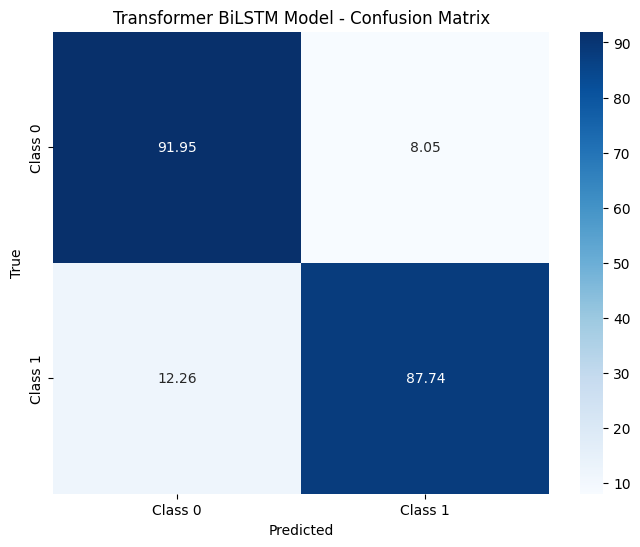

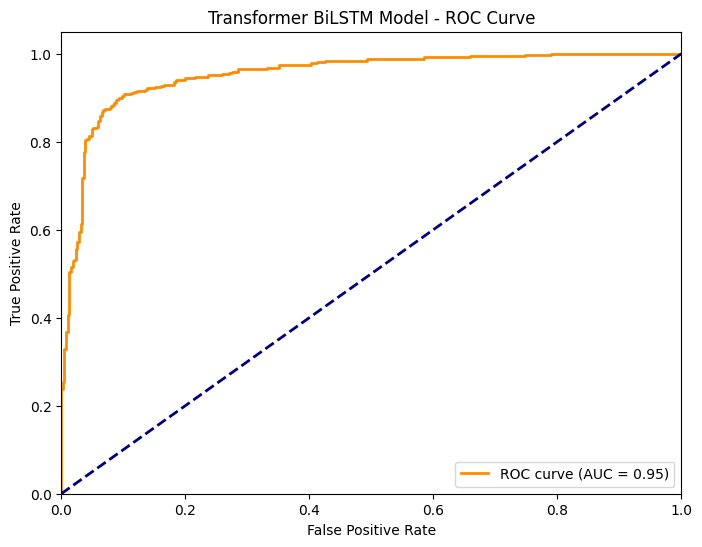

In [ ]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, roc_auc_score, matthews_corrcoef, roc_curve
import seaborn as sns
import matplotlib.pyplot as plt
import os

# تعریف دیتاست سفارشی برای تست
class CustomTestDataset(Dataset):
    def __init__(self, data, labels=None):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if self.labels is not None:
            return torch.tensor(self.data[idx], dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.long)
        else:
            return torch.tensor(self.data[idx], dtype=torch.float32)

# تابع برای بارگذاری داده‌های تست به عنوان DataLoader
def load_test_data_as_dataloader(file_paths, labels=None, batch_size=32):
    data = []
    for file_path in file_paths:
        data.append(np.load(file_path))
    data = np.concatenate(data, axis=0)
    dataset = CustomTestDataset(data, labels)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    return dataloader

# مدل ترنسفورمر با BiLSTM برای تست
class TransformerWithBiLSTM(nn.Module):
    def __init__(self, input_dim, num_classes, num_heads=4, num_layers=2, lstm_hidden_dim=32, dropout_rate=0.3):
        super(TransformerWithBiLSTM, self).__init__()

        # لایه‌های BiLSTM
        self.bilstm = nn.LSTM(input_size=input_dim, hidden_size=lstm_hidden_dim,
                              num_layers=num_layers, batch_first=True, bidirectional=True, dropout=dropout_rate)

        self.attention_layers = nn.ModuleList([nn.MultiheadAttention(embed_dim=lstm_hidden_dim * 2, num_heads=num_heads) for _ in range(num_layers)])

        self.layer_norm = nn.LayerNorm(lstm_hidden_dim * 2)
        self.fc1 = nn.Linear(lstm_hidden_dim * 2, 64)  # کاهش ابعاد لایه خطی
        self.dropout = nn.Dropout(dropout_rate)        # تغییر نرخ Dropout
        self.fc2 = nn.Linear(64, num_classes)          # سازگاری با ابعاد جدید

    def forward(self, x):
        # عبور از لایه BiLSTM
        lstm_out, _ = self.bilstm(x)

        # عبور از لایه‌های ترنسفورمر
        lstm_out = lstm_out.transpose(0, 1)  # برای سازگاری با PyTorch
        for attention in self.attention_layers:
            lstm_out, _ = attention(lstm_out, lstm_out, lstm_out)

        lstm_out = lstm_out.transpose(0, 1)  # بازگشت به شکل اولیه
        lstm_out = self.layer_norm(lstm_out)
        lstm_out = torch.mean(lstm_out, dim=1)  # GlobalAveragePooling
        lstm_out = torch.relu(self.fc1(lstm_out))
        lstm_out = self.dropout(lstm_out)       # اعمال Dropout
        lstm_out = torch.softmax(self.fc2(lstm_out), dim=-1)
        return lstm_out

# تابع تست مدل
def test_transformer_model(test_loader, model_load_path, input_dim=1024, num_classes=2):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = TransformerWithBiLSTM(input_dim=input_dim, num_classes=num_classes)
    model.to(device)

    # بارگذاری مدل ذخیره‌شده
    model.load_state_dict(torch.load(model_load_path, map_location=device))
    model.eval()

    all_predictions = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for data, labels in test_loader:
            data, labels = data.to(device), labels.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(outputs.cpu().numpy()[:, 1])  # احتمال برچسب مثبت

    all_probs = np.array(all_probs)
    return np.array(all_labels), np.array(all_predictions), all_probs

# محاسبه و نمایش معیارهای عملکرد
def calculate_metrics(y_true, y_pred_labels, y_pred_probs):
    cm = confusion_matrix(y_true, y_pred_labels)
    tn, fp, fn, tp = cm.ravel()
    sensitivity = tp / (tp + fn) * 100
    specificity = tn / (tn + fp) * 100
    accuracy = accuracy_score(y_true, y_pred_labels) * 100
    f1 = f1_score(y_true, y_pred_labels) * 100
    mcc = matthews_corrcoef(y_true, y_pred_labels) * 100
    auroc = roc_auc_score(y_true, y_pred_probs) * 100
    print(f"Sensitivity:     {sensitivity:.2f}%")
    print(f"Specificity:     {specificity:.2f}%")
    print(f"Accuracy:        {accuracy:.2f}%")
    print(f"F1 Score:        {f1:.2f}%")
    print(f"MCC:             {mcc:.2f}%")
    print(f"auROC:           {auroc:.2f}%")

# نمایش ماتریس کانفیوژن درصدی و ذخیره تصویر
def display_conf_matrix(y_true, y_pred_labels, title, filename):
    cm = confusion_matrix(y_true, y_pred_labels)
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_percent, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=['Class 0', 'Class 1'],
                yticklabels=['Class 0', 'Class 1'])
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig(filename)
    plt.show()

# رسم نمودار ROC
def plot_roc_curve(y_true, y_pred_probs, title, filename):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_score(y_true, y_pred_probs):.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.savefig(filename)
    plt.show()

# مسیر فایل‌های تست
test_save_paths_X = ['/content/drive/MyDrive/LM-RESULT2/resized_X_TEST.npy']
test_label_csv_path = '/content/drive/MyDrive/LM-RESULT2/y_test_final.csv'

# بارگذاری برچسب‌های تست
y_test = np.loadtxt(test_label_csv_path, delimiter=',', dtype=int)

# آماده‌سازی داده‌ها به عنوان DataLoader برای تست
test_loader = load_test_data_as_dataloader(test_save_paths_X, labels=y_test, batch_size=32)

# مسیر مدل ذخیره شده
model_load_path = '/content/drive/MyDrive/LM-RESULT2/best35_model.pth'

# تست مدل
y_true, y_pred_labels, predicted_probs = test_transformer_model(test_loader, model_load_path)

# محاسبه معیارها
calculate_metrics(y_true, y_pred_labels, predicted_probs)

# ایجاد دایرکتوری برای ذخیره تصاویر در صورت عدم وجود
output_dir = '/content/drive/MyDrive/my_project/LMPred_AMP_Prediction/Figuresfinal'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# نمایش و ذخیره ماتریس کانفیوژن
output_file_cm = os.path.join(output_dir, 'Transformer_BiLSTM3_Model_CM.png')
display_conf_matrix(y_true, y_pred_labels, 'Transformer BiLSTM Model - Confusion Matrix', output_file_cm)

# نمایش و ذخیره نمودار ROC
output_file_roc = os.path.join(output_dir, 'Transformer_BiLSTM3_Model_ROC.png')
plot_roc_curve(y_true, predicted_probs, 'Transformer BiLSTM Model - ROC Curve', output_file_roc)


In [ ]:
head16

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt

# تعریف دیتاست سفارشی
class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return torch.tensor(self.data[idx], dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.long)

# تابع برای بارگذاری داده‌ها به عنوان DataLoader
def load_data_as_dataloader(file_paths, labels, batch_size, percentage=1.0):
    data = []
    for file_path in file_paths:
        data.append(np.load(file_path))
    data = np.concatenate(data, axis=0)

    # استفاده از درصدی از داده‌ها
    num_samples = data.shape[0]
    subset_size = int(num_samples * percentage)
    data = data[:subset_size]
    labels = labels[:subset_size]

    dataset = CustomDataset(data, labels)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return dataloader

# مدل ترنسفورمر با لایه‌های BiLSTM در PyTorch
class TransformerWithBiLSTM(nn.Module):
    def __init__(self, input_dim, num_classes, num_heads=16, num_layers=2, lstm_hidden_dim=32, dropout_rate=0.3):
        super(TransformerWithBiLSTM, self).__init__()

        # لایه‌های BiLSTM
        self.bilstm = nn.LSTM(input_size=input_dim, hidden_size=lstm_hidden_dim,
                              num_layers=num_layers, batch_first=True, bidirectional=True, dropout=dropout_rate)

        self.attention_layers = nn.ModuleList([
            nn.MultiheadAttention(embed_dim=lstm_hidden_dim * 2, num_heads=num_heads) for _ in range(num_layers)
        ])

        self.layer_norm = nn.LayerNorm(lstm_hidden_dim * 2)
        self.fc1 = nn.Linear(lstm_hidden_dim * 2, 64)  # کاهش ابعاد لایه خطی
        self.dropout = nn.Dropout(dropout_rate)        # تغییر نرخ Dropout
        self.fc2 = nn.Linear(64, num_classes)          # سازگاری با ابعاد جدید

    def forward(self, x):
        # عبور از لایه BiLSTM
        lstm_out, _ = self.bilstm(x)

        # عبور از لایه‌های ترنسفورمر
        lstm_out = lstm_out.transpose(0, 1)  # برای سازگاری با PyTorch
        for attention in self.attention_layers:
            lstm_out, _ = attention(lstm_out, lstm_out, lstm_out)

        lstm_out = lstm_out.transpose(0, 1)  # بازگشت به شکل اولیه
        lstm_out = self.layer_norm(lstm_out)
        lstm_out = torch.mean(lstm_out, dim=1)  # GlobalAveragePooling
        lstm_out = torch.relu(self.fc1(lstm_out))
        lstm_out = self.dropout(lstm_out)       # اعمال Dropout
        lstm_out = self.fc2(lstm_out)           # عدم نیاز به Softmax چون CrossEntropyLoss آن را خودکار انجام می‌دهد
        return lstm_out

# تابع آموزش مدل
def train_transformer_model(train_loader, val_loader, input_dim, num_classes, model_save_path, plot_save_path, epochs=100, batch_size=32):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # ایجاد مدل و انتقال به GPU
    model = TransformerWithBiLSTM(input_dim=input_dim, num_classes=num_classes)
    model.to(device)

    optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=1e-4)  # استفاده از AdamW
    criterion = nn.CrossEntropyLoss()

    # تنظیم نرخ یادگیری
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)

    # لیست‌های ذخیره تاریخچه خطا و دقت
    train_loss_history = []
    val_loss_history = []

    best_val_accuracy = 0.0
    early_stopping_counter = 0  # شمارش برای Early Stopping
    patience = 10  # تعداد ایپوک‌ها برای توقف

    # آموزش مدل
    for epoch in range(epochs):
        model.train()
        total_train_loss = 0
        correct_train = 0
        total_train = 0

        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_train += batch_y.size(0)
            correct_train += (predicted == batch_y).sum().item()

        train_accuracy = 100 * correct_train / total_train

        # اعتبارسنجی مدل
        model.eval()
        total_val_loss = 0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for val_X, val_y in val_loader:
                val_X, val_y = val_X.to(device), val_y.to(device)
                outputs = model(val_X)
                loss = criterion(outputs, val_y)
                total_val_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total_val += val_y.size(0)
                correct_val += (predicted == val_y).sum().item()

        val_accuracy = 100 * correct_val / total_val

        train_loss_history.append(total_train_loss / len(train_loader))
        val_loss_history.append(total_val_loss / len(val_loader))

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {total_train_loss / len(train_loader):.4f}, Val Loss: {total_val_loss / len(val_loader):.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Accuracy: {val_accuracy:.2f}%")

        # ذخیره مدل اگر دقت اعتبارسنجی بهبود یافته باشد
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            torch.save(model.state_dict(), model_save_path)
            print(f"New best model saved with Val Accuracy: {val_accuracy:.2f}%")
            early_stopping_counter = 0  # بازنشانی شمارش
        else:
            early_stopping_counter += 1  # افزایش شمارش

        # بروزرسانی نرخ یادگیری
        scheduler.step(total_val_loss)  # به روز رسانی نرخ یادگیری با توجه به ولیدیشن Loss

        # اگر دقت ولیدیشن بهبود نیافت، آموزش متوقف شود
        if early_stopping_counter >= patience:
            print(f"Early stopping triggered after {epoch + 1} epochs.")
            break

    # ذخیره نمودارها
    plt.figure(figsize=(10, 5))
    plt.plot(train_loss_history, label='Train Loss')
    plt.plot(val_loss_history, label='Val Loss')
    plt.title('Model Performance')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(plot_save_path)
    plt.close()
    print(f"Plots saved to {plot_save_path}")

# فراخوانی تابع train_transformer_model

# مسیر فایل‌ها
save_paths_X = [
    '/content/drive/MyDrive/LM-RESULT2/resized_X_TRAIN_batch_1.npy',
    '/content/drive/MyDrive/LM-RESULT2/resized_X_TRAIN_batch_2.npy',
    '/content/drive/MyDrive/LM-RESULT2/resized_X_TRAIN_batch_3.npy',
    '/content/drive/MyDrive/LM-RESULT2/resized_X_TRAIN_batch_4.npy',
    '/content/drive/MyDrive/LM-RESULT2/resized_X_TRAIN_batch_5.npy',
    '/content/drive/MyDrive/LM-RESULT2/resized_X_TRAIN_batch_6.npy'
]
val_save_path_X = '/content/drive/MyDrive/LM-RESULT2/resized_X_val.npy'
val_label_csv_path = '/content/drive/MyDrive/LM-RESULT2/y_val_final.csv'

# بارگذاری برچسب‌ها
train_labels = np.loadtxt('/content/drive/MyDrive/LM-RESULT2/y_train_final.csv', delimiter=',', dtype=int)
val_labels = np.loadtxt(val_label_csv_path, delimiter=',', dtype=int)

# آماده‌سازی داده‌ها به عنوان DataLoader برای 100 درصد داده‌ها
train_loader = load_data_as_dataloader(save_paths_X, train_labels, batch_size=32, percentage=1.0)
val_loader = load_data_as_dataloader([val_save_path_X], val_labels, batch_size=32, percentage=1.0)

# تنظیمات مدل و آموزش با 100 ایپوک
input_dim = 1024  # ابعاد ورودی داده‌ها (باید با داده‌ها سازگار باشد)
num_classes = 2   # تعداد کلاس‌ها (برچسب‌ها)

train_transformer_model(
    train_loader,          # داده‌های آموزشی
    val_loader,            # داده‌های اعتبارسنجی
    input_dim=input_dim,   # ابعاد ورودی
    num_classes=num_classes,  # تعداد کلاس‌ها
    model_save_path='/content/drive/MyDrive/LM-RESULT2/best36_model.pth',  # مسیر ذخیره مدل
    plot_save_path='/content/drive/MyDrive/LM-RESULT2/training36_plot.png',  # مسیر ذخیره نمودار
    epochs=100,            # تعداد ایپوک‌ها
    batch_size=32          # اندازه بچ
)


Epoch 1/100, Train Loss: 0.6433, Val Loss: 0.4592, Train Accuracy: 60.71%, Val Accuracy: 81.37%
New best model saved with Val Accuracy: 81.37%
Epoch 2/100, Train Loss: 0.3817, Val Loss: 0.3979, Train Accuracy: 84.64%, Val Accuracy: 83.90%
New best model saved with Val Accuracy: 83.90%
Epoch 3/100, Train Loss: 0.3185, Val Loss: 0.3325, Train Accuracy: 87.59%, Val Accuracy: 87.16%
New best model saved with Val Accuracy: 87.16%
Epoch 4/100, Train Loss: 0.3006, Val Loss: 0.3137, Train Accuracy: 88.77%, Val Accuracy: 87.69%
New best model saved with Val Accuracy: 87.69%
Epoch 5/100, Train Loss: 0.2731, Val Loss: 0.3047, Train Accuracy: 89.83%, Val Accuracy: 88.49%
New best model saved with Val Accuracy: 88.49%
Epoch 6/100, Train Loss: 0.2566, Val Loss: 0.3029, Train Accuracy: 90.40%, Val Accuracy: 88.56%
New best model saved with Val Accuracy: 88.56%
Epoch 7/100, Train Loss: 0.2389, Val Loss: 0.3020, Train Accuracy: 91.45%, Val Accuracy: 88.42%
Epoch 8/100, Train Loss: 0.2282, Val Loss: 0.3

<ipython-input-2-6998a86d405e>:76: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_load_path, map_location=device))


Sensitivity:     86.92%
Specificity:     91.43%
Accuracy:        89.23%
F1 Score:        88.73%
MCC:             78.49%
auROC:           94.98%


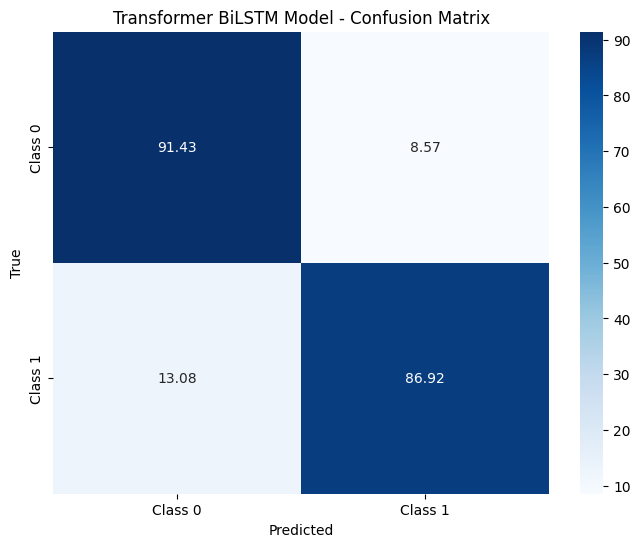

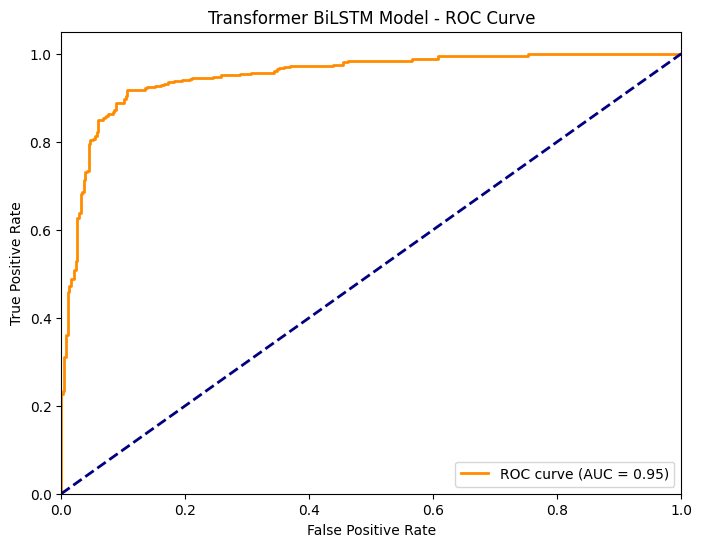

In [ ]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, roc_auc_score, matthews_corrcoef, roc_curve
import seaborn as sns
import matplotlib.pyplot as plt
import os

# تعریف دیتاست سفارشی برای تست
class CustomTestDataset(Dataset):
    def __init__(self, data, labels=None):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if self.labels is not None:
            return torch.tensor(self.data[idx], dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.long)
        else:
            return torch.tensor(self.data[idx], dtype=torch.float32)

# تابع برای بارگذاری داده‌های تست به عنوان DataLoader
def load_test_data_as_dataloader(file_paths, labels=None, batch_size=32):
    data = []
    for file_path in file_paths:
        data.append(np.load(file_path))
    data = np.concatenate(data, axis=0)
    dataset = CustomTestDataset(data, labels)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    return dataloader

# مدل ترنسفورمر با BiLSTM برای تست
class TransformerWithBiLSTM(nn.Module):
    def __init__(self, input_dim, num_classes, num_heads=16, num_layers=2, lstm_hidden_dim=32, dropout_rate=0.3):
        super(TransformerWithBiLSTM, self).__init__()

        # لایه‌های BiLSTM
        self.bilstm = nn.LSTM(input_size=input_dim, hidden_size=lstm_hidden_dim,
                              num_layers=num_layers, batch_first=True, bidirectional=True, dropout=dropout_rate)

        self.attention_layers = nn.ModuleList([nn.MultiheadAttention(embed_dim=lstm_hidden_dim * 2, num_heads=num_heads) for _ in range(num_layers)])

        self.layer_norm = nn.LayerNorm(lstm_hidden_dim * 2)
        self.fc1 = nn.Linear(lstm_hidden_dim * 2, 64)  # کاهش ابعاد لایه خطی
        self.dropout = nn.Dropout(dropout_rate)        # تغییر نرخ Dropout
        self.fc2 = nn.Linear(64, num_classes)          # سازگاری با ابعاد جدید

    def forward(self, x):
        # عبور از لایه BiLSTM
        lstm_out, _ = self.bilstm(x)

        # عبور از لایه‌های ترنسفورمر
        lstm_out = lstm_out.transpose(0, 1)  # برای سازگاری با PyTorch
        for attention in self.attention_layers:
            lstm_out, _ = attention(lstm_out, lstm_out, lstm_out)

        lstm_out = lstm_out.transpose(0, 1)  # بازگشت به شکل اولیه
        lstm_out = self.layer_norm(lstm_out)
        lstm_out = torch.mean(lstm_out, dim=1)  # GlobalAveragePooling
        lstm_out = torch.relu(self.fc1(lstm_out))
        lstm_out = self.dropout(lstm_out)       # اعمال Dropout
        lstm_out = torch.softmax(self.fc2(lstm_out), dim=-1)
        return lstm_out

# تابع تست مدل
def test_transformer_model(test_loader, model_load_path, input_dim=1024, num_classes=2):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = TransformerWithBiLSTM(input_dim=input_dim, num_classes=num_classes)
    model.to(device)

    # بارگذاری مدل ذخیره‌شده
    model.load_state_dict(torch.load(model_load_path, map_location=device))
    model.eval()

    all_predictions = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for data, labels in test_loader:
            data, labels = data.to(device), labels.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(outputs.cpu().numpy()[:, 1])  # احتمال برچسب مثبت

    all_probs = np.array(all_probs)
    return np.array(all_labels), np.array(all_predictions), all_probs

# محاسبه و نمایش معیارهای عملکرد
def calculate_metrics(y_true, y_pred_labels, y_pred_probs):
    cm = confusion_matrix(y_true, y_pred_labels)
    tn, fp, fn, tp = cm.ravel()
    sensitivity = tp / (tp + fn) * 100
    specificity = tn / (tn + fp) * 100
    accuracy = accuracy_score(y_true, y_pred_labels) * 100
    f1 = f1_score(y_true, y_pred_labels) * 100
    mcc = matthews_corrcoef(y_true, y_pred_labels) * 100
    auroc = roc_auc_score(y_true, y_pred_probs) * 100
    print(f"Sensitivity:     {sensitivity:.2f}%")
    print(f"Specificity:     {specificity:.2f}%")
    print(f"Accuracy:        {accuracy:.2f}%")
    print(f"F1 Score:        {f1:.2f}%")
    print(f"MCC:             {mcc:.2f}%")
    print(f"auROC:           {auroc:.2f}%")

# نمایش ماتریس کانفیوژن درصدی و ذخیره تصویر
def display_conf_matrix(y_true, y_pred_labels, title, filename):
    cm = confusion_matrix(y_true, y_pred_labels)
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_percent, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=['Class 0', 'Class 1'],
                yticklabels=['Class 0', 'Class 1'])
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig(filename)
    plt.show()

# رسم نمودار ROC
def plot_roc_curve(y_true, y_pred_probs, title, filename):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_score(y_true, y_pred_probs):.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.savefig(filename)
    plt.show()

# مسیر فایل‌های تست
test_save_paths_X = ['/content/drive/MyDrive/LM-RESULT2/resized_X_TEST.npy']
test_label_csv_path = '/content/drive/MyDrive/LM-RESULT2/y_test_final.csv'

# بارگذاری برچسب‌های تست
y_test = np.loadtxt(test_label_csv_path, delimiter=',', dtype=int)

# آماده‌سازی داده‌ها به عنوان DataLoader برای تست
test_loader = load_test_data_as_dataloader(test_save_paths_X, labels=y_test, batch_size=32)

# مسیر مدل ذخیره شده
model_load_path = '/content/drive/MyDrive/LM-RESULT2/best36_model.pth'

# تست مدل
y_true, y_pred_labels, predicted_probs = test_transformer_model(test_loader, model_load_path)

# محاسبه معیارها
calculate_metrics(y_true, y_pred_labels, predicted_probs)

# ایجاد دایرکتوری برای ذخیره تصاویر در صورت عدم وجود
output_dir = '/content/drive/MyDrive/my_project/LMPred_AMP_Prediction/Figuresfinal'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# نمایش و ذخیره ماتریس کانفیوژن
output_file_cm = os.path.join(output_dir, 'Transformer_BiLSTM3_Model_CM.png')
display_conf_matrix(y_true, y_pred_labels, 'Transformer BiLSTM Model - Confusion Matrix', output_file_cm)

# نمایش و ذخیره نمودار ROC
output_file_roc = os.path.join(output_dir, 'Transformer_BiLSTM3_Model_ROC.png')
plot_roc_curve(y_true, predicted_probs, 'Transformer BiLSTM Model - ROC Curve', output_file_roc)


In [ ]:
hidden-dim 64

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt

# تعریف دیتاست سفارشی
class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return torch.tensor(self.data[idx], dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.long)

# تابع برای بارگذاری داده‌ها به عنوان DataLoader
def load_data_as_dataloader(file_paths, labels, batch_size, percentage=1.0):
    data = []
    for file_path in file_paths:
        data.append(np.load(file_path))
    data = np.concatenate(data, axis=0)

    # استفاده از درصدی از داده‌ها
    num_samples = data.shape[0]
    subset_size = int(num_samples * percentage)
    data = data[:subset_size]
    labels = labels[:subset_size]

    dataset = CustomDataset(data, labels)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return dataloader

# مدل ترنسفورمر با لایه‌های BiLSTM در PyTorch
class TransformerWithBiLSTM(nn.Module):
    def __init__(self, input_dim, num_classes, num_heads=8, num_layers=2, lstm_hidden_dim=16, dropout_rate=0.3):
        super(TransformerWithBiLSTM, self).__init__()

        # لایه‌های BiLSTM
        self.bilstm = nn.LSTM(input_size=input_dim, hidden_size=lstm_hidden_dim,
                              num_layers=num_layers, batch_first=True, bidirectional=True, dropout=dropout_rate)

        self.attention_layers = nn.ModuleList([
            nn.MultiheadAttention(embed_dim=lstm_hidden_dim * 2, num_heads=num_heads) for _ in range(num_layers)
        ])

        self.layer_norm = nn.LayerNorm(lstm_hidden_dim * 2)
        self.fc1 = nn.Linear(lstm_hidden_dim * 2, 64)  # کاهش ابعاد لایه خطی
        self.dropout = nn.Dropout(dropout_rate)        # تغییر نرخ Dropout
        self.fc2 = nn.Linear(64, num_classes)          # سازگاری با ابعاد جدید

    def forward(self, x):
        # عبور از لایه BiLSTM
        lstm_out, _ = self.bilstm(x)

        # عبور از لایه‌های ترنسفورمر
        lstm_out = lstm_out.transpose(0, 1)  # برای سازگاری با PyTorch
        for attention in self.attention_layers:
            lstm_out, _ = attention(lstm_out, lstm_out, lstm_out)

        lstm_out = lstm_out.transpose(0, 1)  # بازگشت به شکل اولیه
        lstm_out = self.layer_norm(lstm_out)
        lstm_out = torch.mean(lstm_out, dim=1)  # GlobalAveragePooling
        lstm_out = torch.relu(self.fc1(lstm_out))
        lstm_out = self.dropout(lstm_out)       # اعمال Dropout
        lstm_out = self.fc2(lstm_out)           # عدم نیاز به Softmax چون CrossEntropyLoss آن را خودکار انجام می‌دهد
        return lstm_out

# تابع آموزش مدل
def train_transformer_model(train_loader, val_loader, input_dim, num_classes, model_save_path, plot_save_path, epochs=100, batch_size=32):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # ایجاد مدل و انتقال به GPU
    model = TransformerWithBiLSTM(input_dim=input_dim, num_classes=num_classes)
    model.to(device)

    optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=1e-4)  # استفاده از AdamW
    criterion = nn.CrossEntropyLoss()

    # تنظیم نرخ یادگیری
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)

    # لیست‌های ذخیره تاریخچه خطا و دقت
    train_loss_history = []
    val_loss_history = []

    best_val_accuracy = 0.0
    early_stopping_counter = 0  # شمارش برای Early Stopping
    patience = 10  # تعداد ایپوک‌ها برای توقف

    # آموزش مدل
    for epoch in range(epochs):
        model.train()
        total_train_loss = 0
        correct_train = 0
        total_train = 0

        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_train += batch_y.size(0)
            correct_train += (predicted == batch_y).sum().item()

        train_accuracy = 100 * correct_train / total_train

        # اعتبارسنجی مدل
        model.eval()
        total_val_loss = 0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for val_X, val_y in val_loader:
                val_X, val_y = val_X.to(device), val_y.to(device)
                outputs = model(val_X)
                loss = criterion(outputs, val_y)
                total_val_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total_val += val_y.size(0)
                correct_val += (predicted == val_y).sum().item()

        val_accuracy = 100 * correct_val / total_val

        train_loss_history.append(total_train_loss / len(train_loader))
        val_loss_history.append(total_val_loss / len(val_loader))

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {total_train_loss / len(train_loader):.4f}, Val Loss: {total_val_loss / len(val_loader):.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Accuracy: {val_accuracy:.2f}%")

        # ذخیره مدل اگر دقت اعتبارسنجی بهبود یافته باشد
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            torch.save(model.state_dict(), model_save_path)
            print(f"New best model saved with Val Accuracy: {val_accuracy:.2f}%")
            early_stopping_counter = 0  # بازنشانی شمارش
        else:
            early_stopping_counter += 1  # افزایش شمارش

        # بروزرسانی نرخ یادگیری
        scheduler.step(total_val_loss)  # به روز رسانی نرخ یادگیری با توجه به ولیدیشن Loss

        # اگر دقت ولیدیشن بهبود نیافت، آموزش متوقف شود
        if early_stopping_counter >= patience:
            print(f"Early stopping triggered after {epoch + 1} epochs.")
            break

    # ذخیره نمودارها
    plt.figure(figsize=(10, 5))
    plt.plot(train_loss_history, label='Train Loss')
    plt.plot(val_loss_history, label='Val Loss')
    plt.title('Model Performance')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(plot_save_path)
    plt.close()
    print(f"Plots saved to {plot_save_path}")

# فراخوانی تابع train_transformer_model

# مسیر فایل‌ها
save_paths_X = [
    '/content/drive/MyDrive/LM-RESULT2/resized_X_TRAIN_batch_1.npy',
    '/content/drive/MyDrive/LM-RESULT2/resized_X_TRAIN_batch_2.npy',
    '/content/drive/MyDrive/LM-RESULT2/resized_X_TRAIN_batch_3.npy',
    '/content/drive/MyDrive/LM-RESULT2/resized_X_TRAIN_batch_4.npy',
    '/content/drive/MyDrive/LM-RESULT2/resized_X_TRAIN_batch_5.npy',
    '/content/drive/MyDrive/LM-RESULT2/resized_X_TRAIN_batch_6.npy'
]
val_save_path_X = '/content/drive/MyDrive/LM-RESULT2/resized_X_val.npy'
val_label_csv_path = '/content/drive/MyDrive/LM-RESULT2/y_val_final.csv'

# بارگذاری برچسب‌ها
train_labels = np.loadtxt('/content/drive/MyDrive/LM-RESULT2/y_train_final.csv', delimiter=',', dtype=int)
val_labels = np.loadtxt(val_label_csv_path, delimiter=',', dtype=int)

# آماده‌سازی داده‌ها به عنوان DataLoader برای 100 درصد داده‌ها
train_loader = load_data_as_dataloader(save_paths_X, train_labels, batch_size=32, percentage=1.0)
val_loader = load_data_as_dataloader([val_save_path_X], val_labels, batch_size=32, percentage=1.0)

# تنظیمات مدل و آموزش با 100 ایپوک
input_dim = 1024  # ابعاد ورودی داده‌ها (باید با داده‌ها سازگار باشد)
num_classes = 2   # تعداد کلاس‌ها (برچسب‌ها)

train_transformer_model(
    train_loader,          # داده‌های آموزشی
    val_loader,            # داده‌های اعتبارسنجی
    input_dim=input_dim,   # ابعاد ورودی
    num_classes=num_classes,  # تعداد کلاس‌ها
    model_save_path='/content/drive/MyDrive/LM-RESULT2/best37_model.pth',  # مسیر ذخیره مدل
    plot_save_path='/content/drive/MyDrive/LM-RESULT2/training37_plot.png',  # مسیر ذخیره نمودار
    epochs=100,            # تعداد ایپوک‌ها
    batch_size=32          # اندازه بچ
)


Epoch 1/100, Train Loss: 0.6414, Val Loss: 0.5078, Train Accuracy: 63.70%, Val Accuracy: 81.84%
New best model saved with Val Accuracy: 81.84%
Epoch 2/100, Train Loss: 0.4236, Val Loss: 0.3923, Train Accuracy: 82.80%, Val Accuracy: 83.70%
New best model saved with Val Accuracy: 83.70%
Epoch 3/100, Train Loss: 0.3437, Val Loss: 0.3532, Train Accuracy: 86.56%, Val Accuracy: 85.50%
New best model saved with Val Accuracy: 85.50%
Epoch 4/100, Train Loss: 0.3083, Val Loss: 0.3416, Train Accuracy: 87.87%, Val Accuracy: 86.49%
New best model saved with Val Accuracy: 86.49%
Epoch 5/100, Train Loss: 0.2943, Val Loss: 0.3298, Train Accuracy: 88.99%, Val Accuracy: 87.36%
New best model saved with Val Accuracy: 87.36%
Epoch 6/100, Train Loss: 0.2827, Val Loss: 0.3203, Train Accuracy: 89.24%, Val Accuracy: 87.96%
New best model saved with Val Accuracy: 87.96%
Epoch 7/100, Train Loss: 0.2698, Val Loss: 0.3192, Train Accuracy: 89.96%, Val Accuracy: 87.49%
Epoch 8/100, Train Loss: 0.2492, Val Loss: 0.2

In [ ]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, roc_auc_score, matthews_corrcoef, roc_curve
import seaborn as sns
import matplotlib.pyplot as plt
import os

# تعریف دیتاست سفارشی برای تست
class CustomTestDataset(Dataset):
    def __init__(self, data, labels=None):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if self.labels is not None:
            return torch.tensor(self.data[idx], dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.long)
        else:
            return torch.tensor(self.data[idx], dtype=torch.float32)

# تابع برای بارگذاری داده‌های تست به عنوان DataLoader
def load_test_data_as_dataloader(file_paths, labels=None, batch_size=32):
    data = []
    for file_path in file_paths:
        data.append(np.load(file_path))
    data = np.concatenate(data, axis=0)
    dataset = CustomTestDataset(data, labels)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    return dataloader

# مدل ترنسفورمر با BiLSTM برای تست
class TransformerWithBiLSTM(nn.Module):
    def __init__(self, input_dim, num_classes, num_heads=8, num_layers=2, lstm_hidden_dim=16, dropout_rate=0.3):
        super(TransformerWithBiLSTM, self).__init__()

        # لایه‌های BiLSTM
        self.bilstm = nn.LSTM(input_size=input_dim, hidden_size=lstm_hidden_dim,
                              num_layers=num_layers, batch_first=True, bidirectional=True, dropout=dropout_rate)

        self.attention_layers = nn.ModuleList([nn.MultiheadAttention(embed_dim=lstm_hidden_dim * 2, num_heads=num_heads) for _ in range(num_layers)])

        self.layer_norm = nn.LayerNorm(lstm_hidden_dim * 2)
        self.fc1 = nn.Linear(lstm_hidden_dim * 2, 64)  # کاهش ابعاد لایه خطی
        self.dropout = nn.Dropout(dropout_rate)        # تغییر نرخ Dropout
        self.fc2 = nn.Linear(64, num_classes)          # سازگاری با ابعاد جدید

    def forward(self, x):
        # عبور از لایه BiLSTM
        lstm_out, _ = self.bilstm(x)

        # عبور از لایه‌های ترنسفورمر
        lstm_out = lstm_out.transpose(0, 1)  # برای سازگاری با PyTorch
        for attention in self.attention_layers:
            lstm_out, _ = attention(lstm_out, lstm_out, lstm_out)

        lstm_out = lstm_out.transpose(0, 1)  # بازگشت به شکل اولیه
        lstm_out = self.layer_norm(lstm_out)
        lstm_out = torch.mean(lstm_out, dim=1)  # GlobalAveragePooling
        lstm_out = torch.relu(self.fc1(lstm_out))
        lstm_out = self.dropout(lstm_out)       # اعمال Dropout
        lstm_out = torch.softmax(self.fc2(lstm_out), dim=-1)
        return lstm_out

# تابع تست مدل
def test_transformer_model(test_loader, model_load_path, input_dim=1024, num_classes=2):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = TransformerWithBiLSTM(input_dim=input_dim, num_classes=num_classes)
    model.to(device)

    # بارگذاری مدل ذخیره‌شده
    model.load_state_dict(torch.load(model_load_path, map_location=device))
    model.eval()

    all_predictions = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for data, labels in test_loader:
            data, labels = data.to(device), labels.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(outputs.cpu().numpy()[:, 1])  # احتمال برچسب مثبت

    all_probs = np.array(all_probs)
    return np.array(all_labels), np.array(all_predictions), all_probs

# محاسبه و نمایش معیارهای عملکرد
def calculate_metrics(y_true, y_pred_labels, y_pred_probs):
    cm = confusion_matrix(y_true, y_pred_labels)
    tn, fp, fn, tp = cm.ravel()
    sensitivity = tp / (tp + fn) * 100
    specificity = tn / (tn + fp) * 100
    accuracy = accuracy_score(y_true, y_pred_labels) * 100
    f1 = f1_score(y_true, y_pred_labels) * 100
    mcc = matthews_corrcoef(y_true, y_pred_labels) * 100
    auroc = roc_auc_score(y_true, y_pred_probs) * 100
    print(f"Sensitivity:     {sensitivity:.2f}%")
    print(f"Specificity:     {specificity:.2f}%")
    print(f"Accuracy:        {accuracy:.2f}%")
    print(f"F1 Score:        {f1:.2f}%")
    print(f"MCC:             {mcc:.2f}%")
    print(f"auROC:           {auroc:.2f}%")

# نمایش ماتریس کانفیوژن درصدی و ذخیره تصویر
def display_conf_matrix(y_true, y_pred_labels, title, filename):
    cm = confusion_matrix(y_true, y_pred_labels)
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_percent, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=['Class 0', 'Class 1'],
                yticklabels=['Class 0', 'Class 1'])
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig(filename)
    plt.show()

# رسم نمودار ROC
def plot_roc_curve(y_true, y_pred_probs, title, filename):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_score(y_true, y_pred_probs):.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.savefig(filename)
    plt.show()

# مسیر فایل‌های تست
test_save_paths_X = ['/content/drive/MyDrive/LM-RESULT2/resized_X_TEST.npy']
test_label_csv_path = '/content/drive/MyDrive/LM-RESULT2/y_test_final.csv'

# بارگذاری برچسب‌های تست
y_test = np.loadtxt(test_label_csv_path, delimiter=',', dtype=int)

# آماده‌سازی داده‌ها به عنوان DataLoader برای تست
test_loader = load_test_data_as_dataloader(test_save_paths_X, labels=y_test, batch_size=32)

# مسیر مدل ذخیره شده
model_load_path = '/content/drive/MyDrive/LM-RESULT2/best37_model.pth'

# تست مدل
y_true, y_pred_labels, predicted_probs = test_transformer_model(test_loader, model_load_path)

# محاسبه معیارها
calculate_metrics(y_true, y_pred_labels, predicted_probs)

# ایجاد دایرکتوری برای ذخیره تصاویر در صورت عدم وجود
output_dir = '/content/drive/MyDrive/my_project/LMPred_AMP_Prediction/Figuresfinal'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# نمایش و ذخیره ماتریس کانفیوژن
output_file_cm = os.path.join(output_dir, 'Transformer_BiLSTM3_Model_CM.png')
display_conf_matrix(y_true, y_pred_labels, 'Transformer BiLSTM Model - Confusion Matrix', output_file_cm)

# نمایش و ذخیره نمودار ROC
output_file_roc = os.path.join(output_dir, 'Transformer_BiLSTM3_Model_ROC.png')
plot_roc_curve(y_true, predicted_probs, 'Transformer BiLSTM Model - ROC Curve', output_file_roc)
